# Entendimiento de los Datos - Business Case: Nequi


#### Autor: William Albeiro Amaya Patiño

 Importar librerías y cargar el dataset en Python

In [2]:
# Preprocesamiento
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Modelos
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.cluster import KMeans

# Métricas y evaluación
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score,
    balanced_accuracy_score, accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, classification_report, make_scorer
)
from statistics import stdev

# Visualización
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Otros
import joblib
import shap
from collections import Counter

# Configuración para pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', None)     # Mostrar todas las filas
pd.options.display.float_format = '{:.4f}'.format

# Ajustar tamaño de la ventana en Jupyter Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Suprimir advertencias
import warnings
warnings.filterwarnings("ignore")


C:\Users\eusou\AppData\Local\Temp\ipykernel_28312\664918238.py:60: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:

files = ['sample_data_0006_part_00.parquet','sample_data_0007_part_00.parquet'] 
df = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)


In [4]:
df.shape

(21516918, 8)

In [5]:
# Muestreo aleatorio 
df = df.sample(n=1000000, random_state=42)


In [6]:
df.shape

(1000000, 8)

In [7]:
df.head()

merchant_id                               _id  \
15689388  817d18cd3c31e40e9bff0566baae7758  d282461568e06ebad6a14bc095937209   
1907514   817d18cd3c31e40e9bff0566baae7758  0e17de5693b04eacf7a5ede381c01635   
19555549  817d18cd3c31e40e9bff0566baae7758  ff57537a77f98c309a6beb86fa38da95   
15248322  817d18cd3c31e40e9bff0566baae7758  b7f32a750b25f21a2bf158bc557f41c8   
8022707   817d18cd3c31e40e9bff0566baae7758  eaba433eb231d0ca107e6c9505089e7f   

                                subsidiary    transaction_date  \
15689388  7d7a00374bd1b4a5a0c3c98cfa570062 2021-07-02 10:51:32   
1907514   73c9a18fafaa11a5c8e91f09acd3d89e 2021-05-19 19:13:54   
19555549  c70fed7f608d0ae18cd24b233e4a9af0 2021-11-15 19:34:04   
15248322  23b6e598e195241b496b81d95652870e 2021-06-10 14:40:21   
8022707   42b2dfb90bb2f4833e421b9869b5d0fa 2021-11-23 11:40:35   

                            account_number                           user_id  \
15689388  a5a126bb68a00284171f83d0be4ef91a  9a6d0b2a239499b6539b671edfe02cc6   
1907514   59c129c491017c85fd547de52e1f682a  5249a8ae1f4bde0cebf710ef5a80fbfe   
19555549  5c359af4a4957672688585ab015c3c10  e0098f13bb5c41446a2da8ff9ec657ba   
15248322  cb0c2593fad8a92c41d78842f7a5881a  d1a287c0765fe60064efd3c8427fdb7d   
8022707   7b999c12c69e06a3a4601f43c88f6c47  a0e966a5b35c2456e1a8b9848ef05b21   

         transaction_amount transaction_type  
15689388       130.77801027           DEBITO  
1907514        594.44550123           DEBITO  
19555549        23.77782004           DEBITO  
15248322       677.66787140           DEBITO  
8022707         59.44455012           DEBITO

# Paso 1: Alcance del proyecto.

### Fraccionamiento Transaccional:

Esta mala práctica consiste en dividir una transacción en varias transacciones de menor monto, cuyo total agrupado equivale al valor de la transacción original. Estas transacciones suelen realizarse dentro de un mismo período de tiempo, generalmente 24 horas, y tienen como origen o destino la misma cuenta o cliente.

In [8]:
df['fraccionamientos']=df.groupby(['subsidiary','account_number', pd.Grouper(key='transaction_date',freq='24h')])['transaction_date'].transform('count')

Se condiciona que si es mayor a 1 transacción por el mismo corresponsal y cuenta del cliente, se asume que podría ser fraude. 1: fraude 0: No fraude

In [9]:
# Identificación de posibles fraudes
# Si hay más de una transacción y cuenta del cliente en 24 horas, se marca como fraude
df['Fraude'] =df['fraccionamientos'].apply(lambda x: 0 if x==1 else 1)




In [10]:
df['monto_total_24h']=df.groupby(['subsidiary','account_number', pd.Grouper(key='transaction_date',freq='24h')])['transaction_amount'].transform('sum')

In [11]:
# Cálculo de proporción del monto fraccionado respecto al monto total
df['proporcion_monto_fraccionado'] = df['transaction_amount'] / df['monto_total_24h']

In [12]:
df['secuencia_transacciones'] = df.sort_values(by=['subsidiary', 'account_number', 'transaction_date'], ascending=True) \
    .groupby(['subsidiary', 'account_number', 'user_id', pd.Grouper(key='transaction_date', freq='24h')]) \
    .cumcount() + 1


In [13]:
df.head(5)

merchant_id                               _id  \
15689388  817d18cd3c31e40e9bff0566baae7758  d282461568e06ebad6a14bc095937209   
1907514   817d18cd3c31e40e9bff0566baae7758  0e17de5693b04eacf7a5ede381c01635   
19555549  817d18cd3c31e40e9bff0566baae7758  ff57537a77f98c309a6beb86fa38da95   
15248322  817d18cd3c31e40e9bff0566baae7758  b7f32a750b25f21a2bf158bc557f41c8   
8022707   817d18cd3c31e40e9bff0566baae7758  eaba433eb231d0ca107e6c9505089e7f   

                                subsidiary    transaction_date  \
15689388  7d7a00374bd1b4a5a0c3c98cfa570062 2021-07-02 10:51:32   
1907514   73c9a18fafaa11a5c8e91f09acd3d89e 2021-05-19 19:13:54   
19555549  c70fed7f608d0ae18cd24b233e4a9af0 2021-11-15 19:34:04   
15248322  23b6e598e195241b496b81d95652870e 2021-06-10 14:40:21   
8022707   42b2dfb90bb2f4833e421b9869b5d0fa 2021-11-23 11:40:35   

                            account_number                           user_id  \
15689388  a5a126bb68a00284171f83d0be4ef91a  9a6d0b2a239499b6539b671edfe02cc6   
1907514   59c129c491017c85fd547de52e1f682a  5249a8ae1f4bde0cebf710ef5a80fbfe   
19555549  5c359af4a4957672688585ab015c3c10  e0098f13bb5c41446a2da8ff9ec657ba   
15248322  cb0c2593fad8a92c41d78842f7a5881a  d1a287c0765fe60064efd3c8427fdb7d   
8022707   7b999c12c69e06a3a4601f43c88f6c47  a0e966a5b35c2456e1a8b9848ef05b21   

         transaction_amount transaction_type  fraccionamientos  Fraude  \
15689388       130.77801027           DEBITO                 1       0   
1907514        594.44550123           DEBITO                 1       0   
19555549        23.77782004           DEBITO                 1       0   
15248322       677.66787140           DEBITO                 1       0   
8022707         59.44455012           DEBITO                 1       0   

         monto_total_24h proporcion_monto_fraccionado  secuencia_transacciones  
15689388    130.77801027                            1                        1  
1907514     594.44550123                            1                        1  
19555549     23.77782004                            1                        1  
15248322    677.66787140                            1                        1  
8022707      59.44455012                            1                        1

## Paso 2: Explorar y evaluar los datos, el EDA.

### Descripcion de variables

Encontrarás las siguientes columnas:

• _id: identificador único del registro

• merchant_id: código único del comercio o aliado.

• subsidiary: código único de la sede o sucursal.

• transaction_date: fecha de transacción en el Core financiero.

• account_number: número único de cuenta.

• user_id: código único del usuario dueño de la cuenta desde donde se registran

• las transacciones.

• transaction_amount: monto de la transacción (en moneda ficticia).

• transaction_type: naturaleza de la transacción (crédito o débito).

In [14]:
df.duplicated().sum()

0

In [15]:
# Eliminar duplicados manteniendo la primera ocurrencia
df = df.drop_duplicates()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 15689388 to 15189115
Data columns (total 13 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   merchant_id                   1000000 non-null  object        
 1   _id                           1000000 non-null  object        
 2   subsidiary                    1000000 non-null  object        
 3   transaction_date              1000000 non-null  datetime64[ns]
 4   account_number                1000000 non-null  object        
 5   user_id                       1000000 non-null  object        
 6   transaction_amount            1000000 non-null  object        
 7   transaction_type              1000000 non-null  object        
 8   fraccionamientos              1000000 non-null  int64         
 9   Fraude                        1000000 non-null  int64         
 10  monto_total_24h               1000000 non-null  object        


In [17]:
df['transaction_amount']=df['transaction_amount'].astype(float)
df['monto_total_24h']=df['monto_total_24h'].astype(float)
df['proporcion_monto_fraccionado']=df['proporcion_monto_fraccionado'].astype(float)

In [18]:
# Contar valores nulos y no nulos
a = df.isnull().sum()  # Número de valores nulos por columna
b = df.notnull().sum()  # Número de valores no nulos por columna
c = df.shape[0]  # Número total de filas (constante para todas las columnas)

# Calcular porcentajes
d = round(a / c * 100, 4)  # % de valores nulos por columna
e = round(b / c * 100, 4)  # % de valores no nulos por columna

# Combinar resultados en un DataFrame
result = pd.concat([a, b, pd.Series(c, index=df.columns), d, e], axis=1)
result.columns = [
    "# of Unknown df",  # Nulos
    "# of Known df",    # No nulos
    "# of Total df",    # Total
    "% of Unknown df",  # % de nulos
    "% of Known df"     # % de no nulos
]
result

# of Unknown df  # of Known df  # of Total df  \
merchant_id                                 0        1000000        1000000   
_id                                         0        1000000        1000000   
subsidiary                                  0        1000000        1000000   
transaction_date                            0        1000000        1000000   
account_number                              0        1000000        1000000   
user_id                                     0        1000000        1000000   
transaction_amount                          0        1000000        1000000   
transaction_type                            0        1000000        1000000   
fraccionamientos                            0        1000000        1000000   
Fraude                                      0        1000000        1000000   
monto_total_24h                             0        1000000        1000000   
proporcion_monto_fraccionado                0        1000000        1000000   
secuencia_transacciones                     0        1000000        1000000   

                              % of Unknown df  % of Known df  
merchant_id                            0.0000       100.0000  
_id                                    0.0000       100.0000  
subsidiary                             0.0000       100.0000  
transaction_date                       0.0000       100.0000  
account_number                         0.0000       100.0000  
user_id                                0.0000       100.0000  
transaction_amount                     0.0000       100.0000  
transaction_type                       0.0000       100.0000  
fraccionamientos                       0.0000       100.0000  
Fraude                                 0.0000       100.0000  
monto_total_24h                        0.0000       100.0000  
proporcion_monto_fraccionado           0.0000       100.0000  
secuencia_transacciones                0.0000       100.0000

In [19]:
df.describe().round()

transaction_date  transaction_amount  fraccionamientos  \
count                        1000000        1000000.0000      1000000.0000   
mean   2021-06-27 03:07:14.747083520            191.0000            1.0000   
min              2021-01-01 00:15:39              6.0000            1.0000   
25%    2021-03-31 10:54:35.750000128             36.0000            1.0000   
50%       2021-07-03 17:38:04.500000            107.0000            1.0000   
75%              2021-09-23 09:14:40            238.0000            1.0000   
max              2021-11-30 23:59:03           3210.0000           22.0000   
std                              NaN            241.0000            1.0000   

            Fraude  monto_total_24h  proporcion_monto_fraccionado  \
count 1000000.0000     1000000.0000                  1000000.0000   
mean        0.0000         195.0000                        1.0000   
min         0.0000           6.0000                        0.0000   
25%         0.0000          36.0000                        1.0000   
50%         0.0000         107.0000                        1.0000   
75%         0.0000         238.0000                        1.0000   
max         1.0000        5350.0000                        1.0000   
std         0.0000         249.0000                        0.0000   

       secuencia_transacciones  
count             1000000.0000  
mean                    1.0000  
min                     1.0000  
25%                     1.0000  
50%                     1.0000  
75%                     1.0000  
max                    22.0000  
std                     1.0000

### Los valores únicos de cada variable categórica para confirmar la información que se ha obtenido previamente.

In [20]:
for obj in df.select_dtypes(include='object'):
    print(obj + ' contains: ' + str(df[obj].unique()))

print('\nNumber of unique values in each categorical/object feature')
print(df.select_dtypes(include='object').nunique())

merchant_id contains: ['817d18cd3c31e40e9bff0566baae7758' '075d178871d8d48502bf1f54887e52fe'
 '838a8fa992a4aa2fb5a0cf8b15b63755']
_id contains: ['d282461568e06ebad6a14bc095937209' '0e17de5693b04eacf7a5ede381c01635'
 'ff57537a77f98c309a6beb86fa38da95' ... '631a83946df447eb93e7f0e75770b408'
 '844cd543cd56b47308938ba7551002bb' '608e541dad3ac93d7ac5e95012d61470']
subsidiary contains: ['7d7a00374bd1b4a5a0c3c98cfa570062' '73c9a18fafaa11a5c8e91f09acd3d89e'
 'c70fed7f608d0ae18cd24b233e4a9af0' ... 'd5dbe7eab4a90e4a6fcd2ee6a4c36167'
 '0f8db05ba91042ca5cd9c6a4f7e0b92a' '1c7f898f5e67597d7e2ea95f02ee890e']
account_number contains: ['a5a126bb68a00284171f83d0be4ef91a' '59c129c491017c85fd547de52e1f682a'
 '5c359af4a4957672688585ab015c3c10' ... 'bd7800e6a46352083462809878d32738'
 'e98dad486b8f038bc3d32f08288b3dc3' 'b4a4fcaecb3458428df3c4e74e3489b6']
user_id contains: ['9a6d0b2a239499b6539b671edfe02cc6' '5249a8ae1f4bde0cebf710ef5a80fbfe'
 'e0098f13bb5c41446a2da8ff9ec657ba' ... '2f120fe8d2778fcbc0f4db6f0a

In [21]:
df.head()

merchant_id                               _id  \
15689388  817d18cd3c31e40e9bff0566baae7758  d282461568e06ebad6a14bc095937209   
1907514   817d18cd3c31e40e9bff0566baae7758  0e17de5693b04eacf7a5ede381c01635   
19555549  817d18cd3c31e40e9bff0566baae7758  ff57537a77f98c309a6beb86fa38da95   
15248322  817d18cd3c31e40e9bff0566baae7758  b7f32a750b25f21a2bf158bc557f41c8   
8022707   817d18cd3c31e40e9bff0566baae7758  eaba433eb231d0ca107e6c9505089e7f   

                                subsidiary    transaction_date  \
15689388  7d7a00374bd1b4a5a0c3c98cfa570062 2021-07-02 10:51:32   
1907514   73c9a18fafaa11a5c8e91f09acd3d89e 2021-05-19 19:13:54   
19555549  c70fed7f608d0ae18cd24b233e4a9af0 2021-11-15 19:34:04   
15248322  23b6e598e195241b496b81d95652870e 2021-06-10 14:40:21   
8022707   42b2dfb90bb2f4833e421b9869b5d0fa 2021-11-23 11:40:35   

                            account_number                           user_id  \
15689388  a5a126bb68a00284171f83d0be4ef91a  9a6d0b2a239499b6539b671edfe02cc6   
1907514   59c129c491017c85fd547de52e1f682a  5249a8ae1f4bde0cebf710ef5a80fbfe   
19555549  5c359af4a4957672688585ab015c3c10  e0098f13bb5c41446a2da8ff9ec657ba   
15248322  cb0c2593fad8a92c41d78842f7a5881a  d1a287c0765fe60064efd3c8427fdb7d   
8022707   7b999c12c69e06a3a4601f43c88f6c47  a0e966a5b35c2456e1a8b9848ef05b21   

          transaction_amount transaction_type  fraccionamientos  Fraude  \
15689388            130.7780           DEBITO                 1       0   
1907514             594.4455           DEBITO                 1       0   
19555549             23.7778           DEBITO                 1       0   
15248322            677.6679           DEBITO                 1       0   
8022707              59.4446           DEBITO                 1       0   

          monto_total_24h  proporcion_monto_fraccionado  \
15689388         130.7780                        1.0000   
1907514          594.4455                        1.0000   
19555549          23.7778                        1.0000   
15248322         677.6679                        1.0000   
8022707           59.4446                        1.0000   

          secuencia_transacciones  
15689388                        1  
1907514                         1  
19555549                        1  
15248322                        1  
8022707                         1

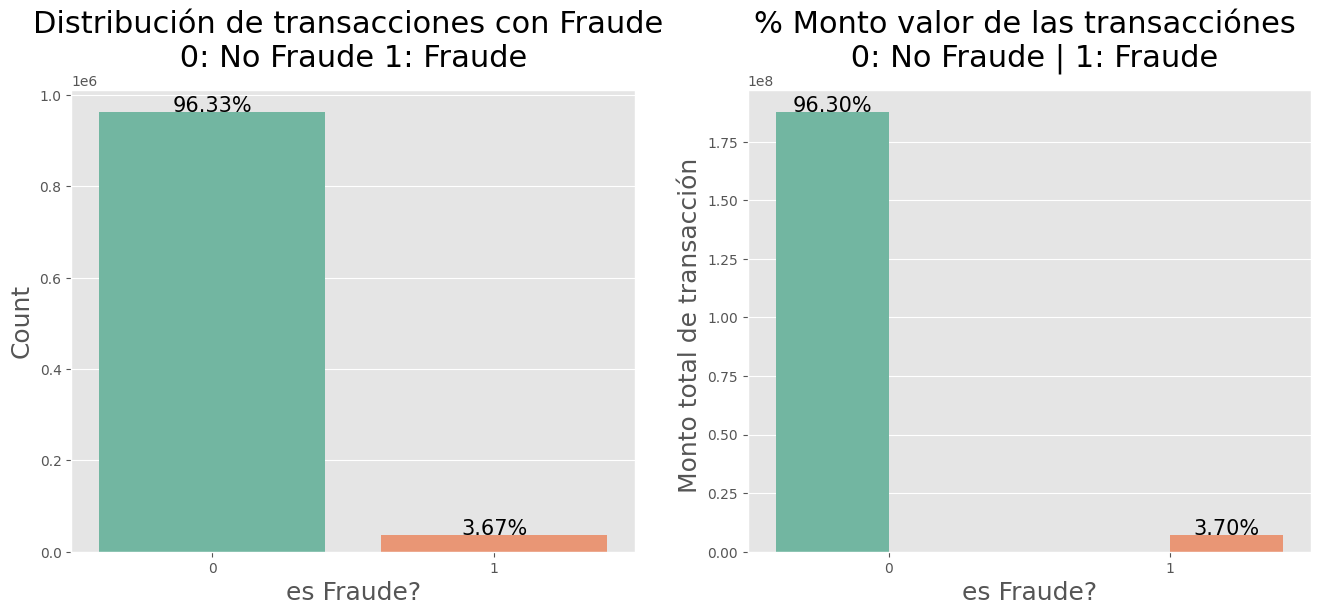

In [22]:
df['monto_total_24h'] = df['monto_total_24h'].astype(float)
total = len(df)
total_amt = df.groupby(['Fraude'])['monto_total_24h'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
grafica = sns.countplot(x='Fraude', data=df,palette='Set2' )
grafica.set_title("Distribución de transacciones con Fraude \n 0: No Fraude 1: Fraude ", fontsize=22)
grafica.set_xlabel("es Fraude?", fontsize=18)
grafica.set_ylabel('Count', fontsize=18)
for p in grafica.patches:
    height = p.get_height()
    grafica.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df.groupby(['Fraude'])['monto_total_24h'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
grafica1 = sns.barplot(x='Fraude', y='monto_total_24h',  dodge=True, data=perc_amt,palette='Set2')
grafica1.set_title("% Monto valor de las transacciónes \n 0: No Fraude | 1: Fraude", fontsize=22)
grafica1.set_xlabel("es Fraude?", fontsize=18)
grafica1.set_ylabel('Monto total de transacción ', fontsize=18)
for p in grafica1.patches:
    height = p.get_height()
    grafica1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

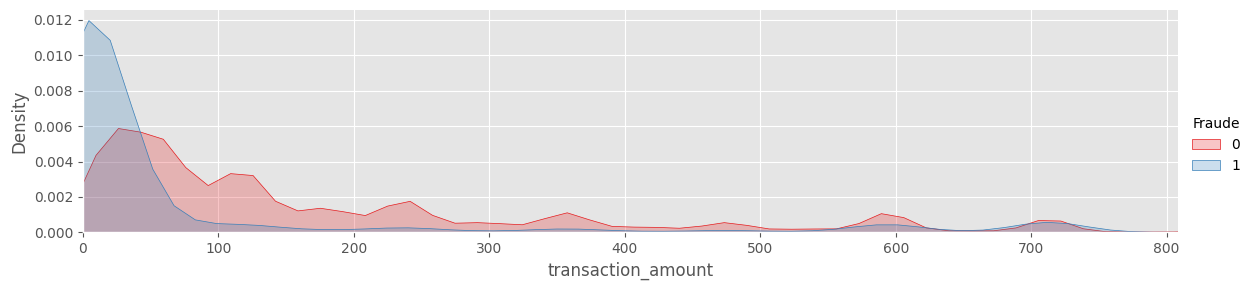

In [23]:
a = sns.FacetGrid(df, hue = 'Fraude', aspect=4, palette="Set1" )
a.map(sns.kdeplot, 'transaction_amount', shade= True )
a.set(xlim=(0 , df['transaction_amount'].quantile(0.98)))
a.add_legend()

In [24]:
var_numericas = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
var_categoricas = [col for col in df.columns if df[col].dtype == 'object']
print("var_numericas:", var_numericas)
print("var_categoricas:", var_categoricas)


var_numericas: ['transaction_amount', 'fraccionamientos', 'Fraude', 'monto_total_24h', 'proporcion_monto_fraccionado', 'secuencia_transacciones']
var_categoricas: ['merchant_id', '_id', 'subsidiary', 'account_number', 'user_id', 'transaction_type']


# Variables Categoricas

In [25]:
def plot_Fraude(data, variable):
    # Calculando los conteos para Fraude por la columna específica
    tmp = data[data['Fraude'] == 1][variable].value_counts(normalize=False).reset_index()
    tmp.columns = [variable, 'Fraude']

    # Definir el orden de los valores en la columna
    column_order = data[variable].value_counts().index

    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Distribución de Transaccion con Fraude por {variable}', fontsize=22)

    # Subplot 1: Distribución general de la columna
    plt.subplot(121)
    g = sns.countplot(x=variable, data=data, palette='Set3', order=column_order)
    g.set_title(f'Distribución general de {variable}', fontsize=19)
    g.set_xlabel(variable, fontsize=17)
    g.set_ylabel('Conteo', fontsize=17)
    g.set_ylim(0, data[variable].value_counts().max() * 1.1)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right") 

    total = len(data)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(height / total * 100),
               ha="center", fontsize=14)

    # Subplot 2: Conteo de Fraude por la columna específica
    plt.subplot(122)
    g2 = sns.barplot(x=variable, y='Fraude', data=tmp, palette='Set3', order=column_order)
    g2.set_title(f'Conteo de Fraude por {variable}', fontsize=19)
    g2.set_xlabel(variable, fontsize=17)
    g2.set_ylabel('Conteo de Fraude', fontsize=17)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=45, ha="right") 


    for p in g2.patches:
        height = p.get_height()
        category = tmp[variable][int(p.get_x() + p.get_width() / 2)]
        total_category = data[data[variable] == category].shape[0]
        mora_percentage = (height / total_category) * 100
        g2.text(p.get_x() + p.get_width() / 2., height + 3, f'{mora_percentage:.2f}%', ha="center", fontsize=14)

    plt.ylim(0, tmp['Fraude'].max() * 1.1)

    plt.tight_layout()
    plt.show()


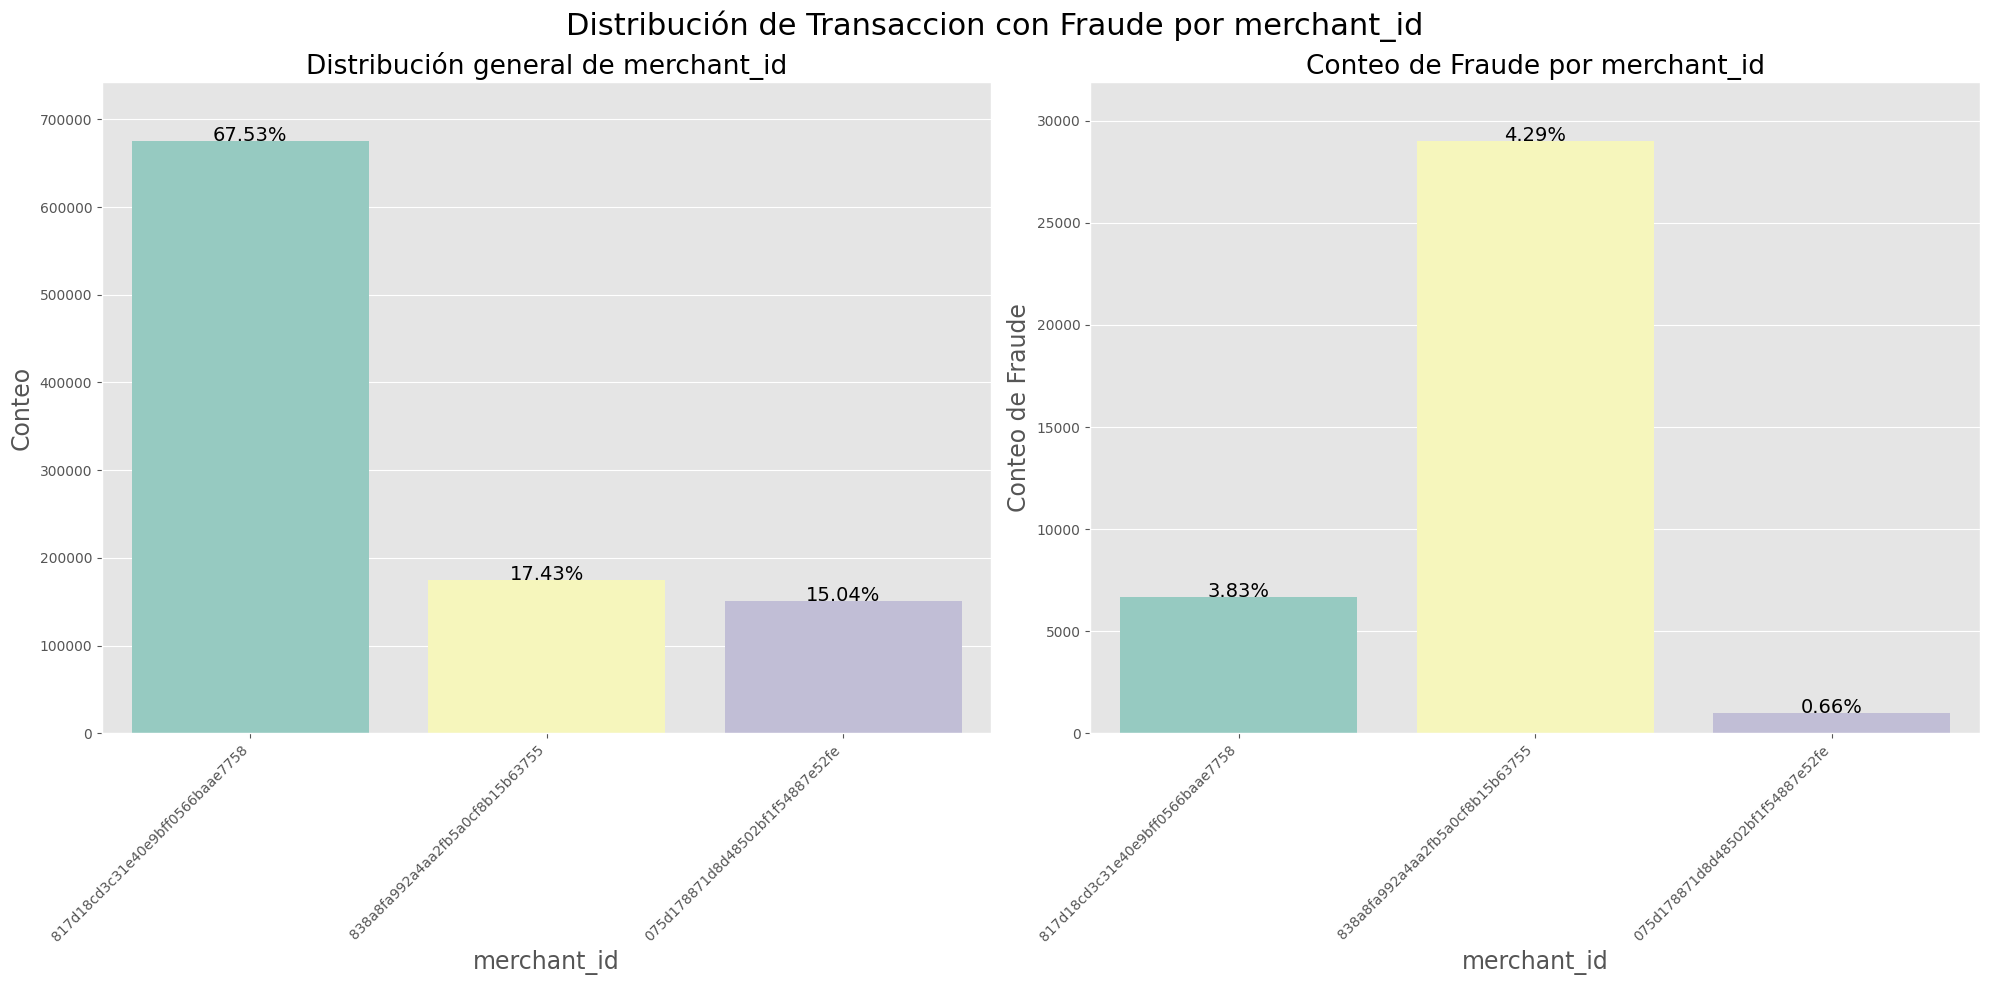

In [26]:
plot_Fraude(df, 'merchant_id')

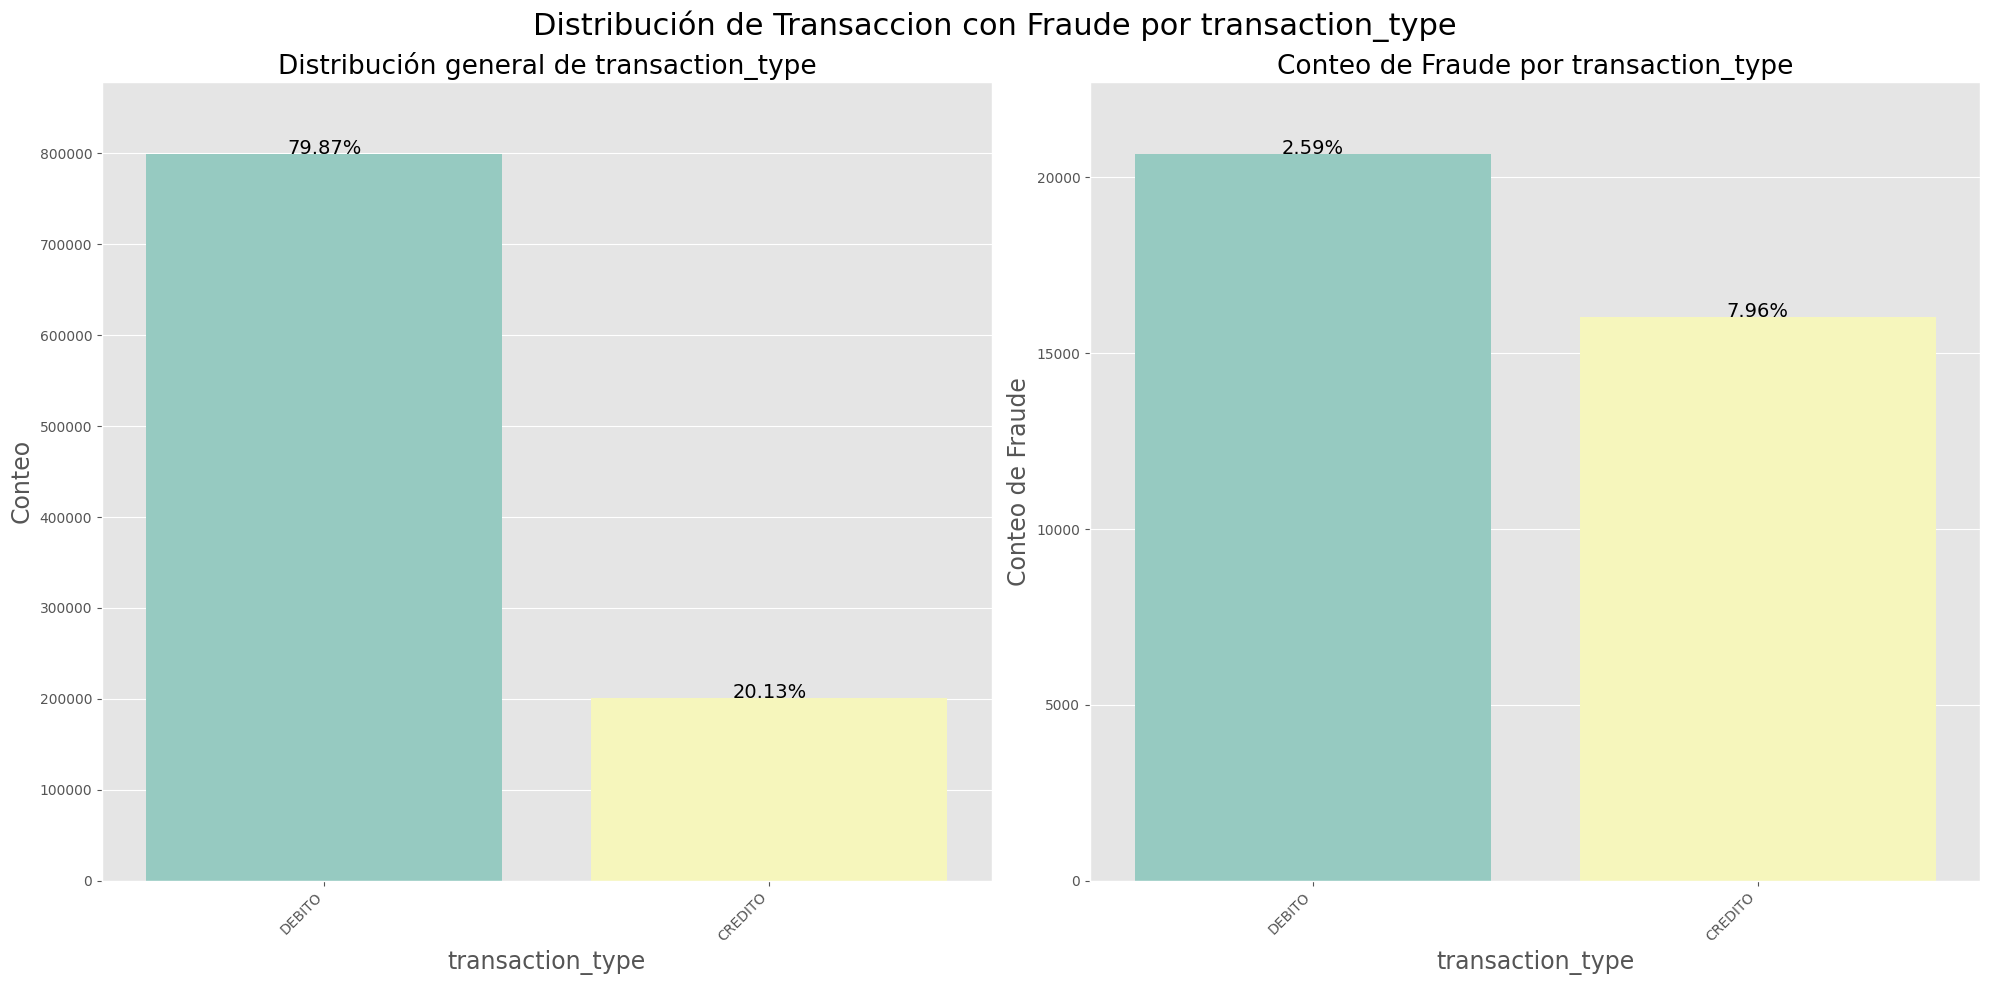

In [27]:
plot_Fraude(df, 'transaction_type')

## Variables Numericas

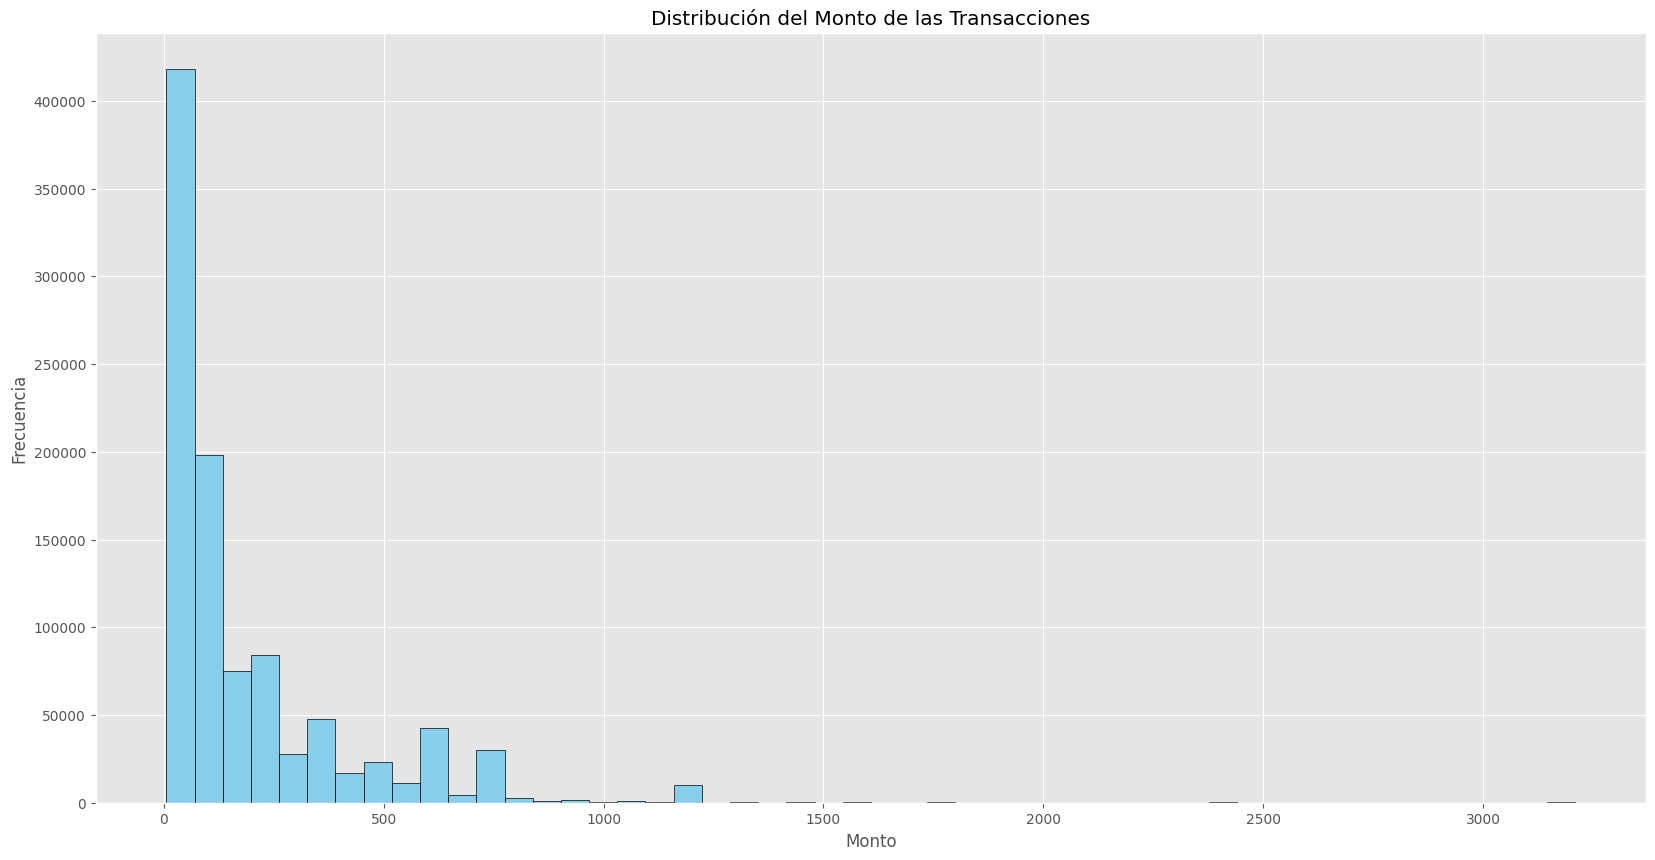

In [28]:
# Distribución del monto de las transacciones
plt.figure(figsize=(20, 10))
df['monto_transaccion'] = df['transaction_amount'].astype(float)
plt.hist(df['monto_transaccion'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución del Monto de las Transacciones")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()

In [29]:
# Crear variables de tiempo
df['hora'] = df['transaction_date'].dt.hour
df['dia'] = df['transaction_date'].dt.day
df['dia_semana'] = df['transaction_date'].dt.day_name(locale='Spanish')
df['mes'] = df['transaction_date'].dt.month
df['anio'] = df['transaction_date'].dt.year

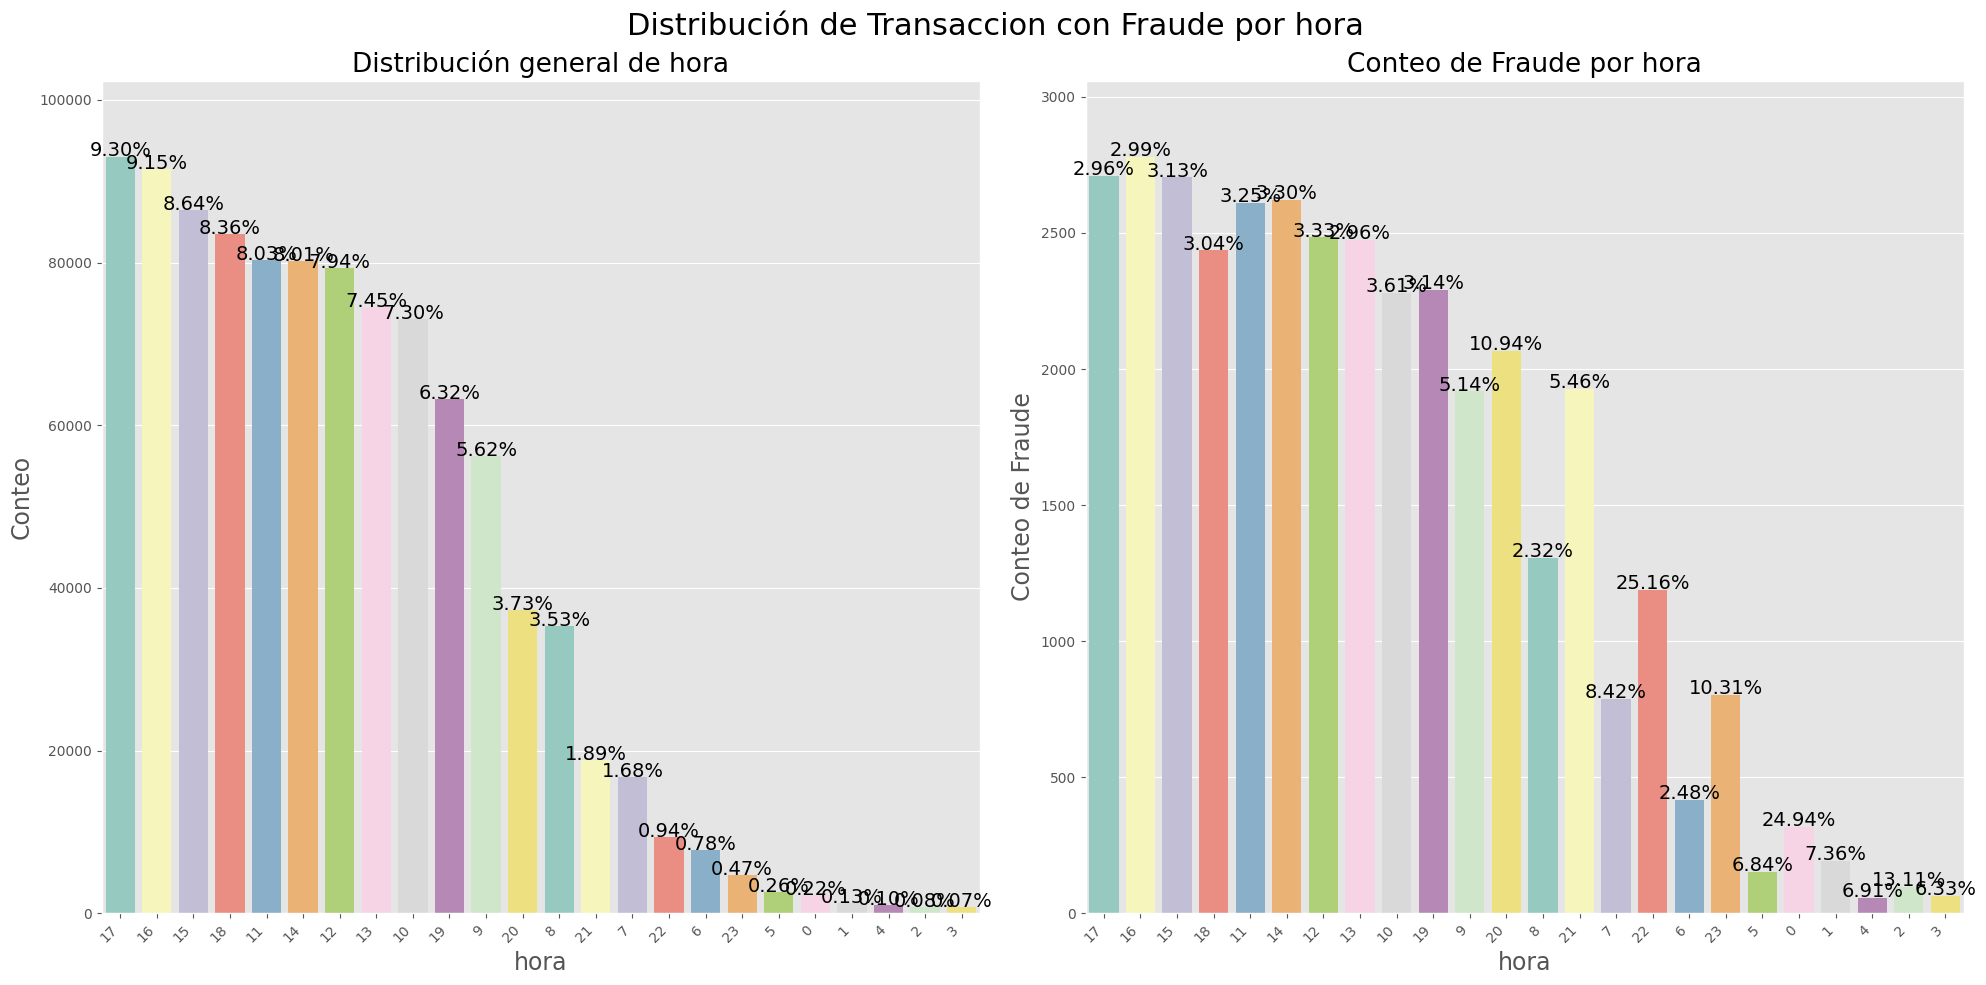

In [30]:
plot_Fraude(df, 'hora')

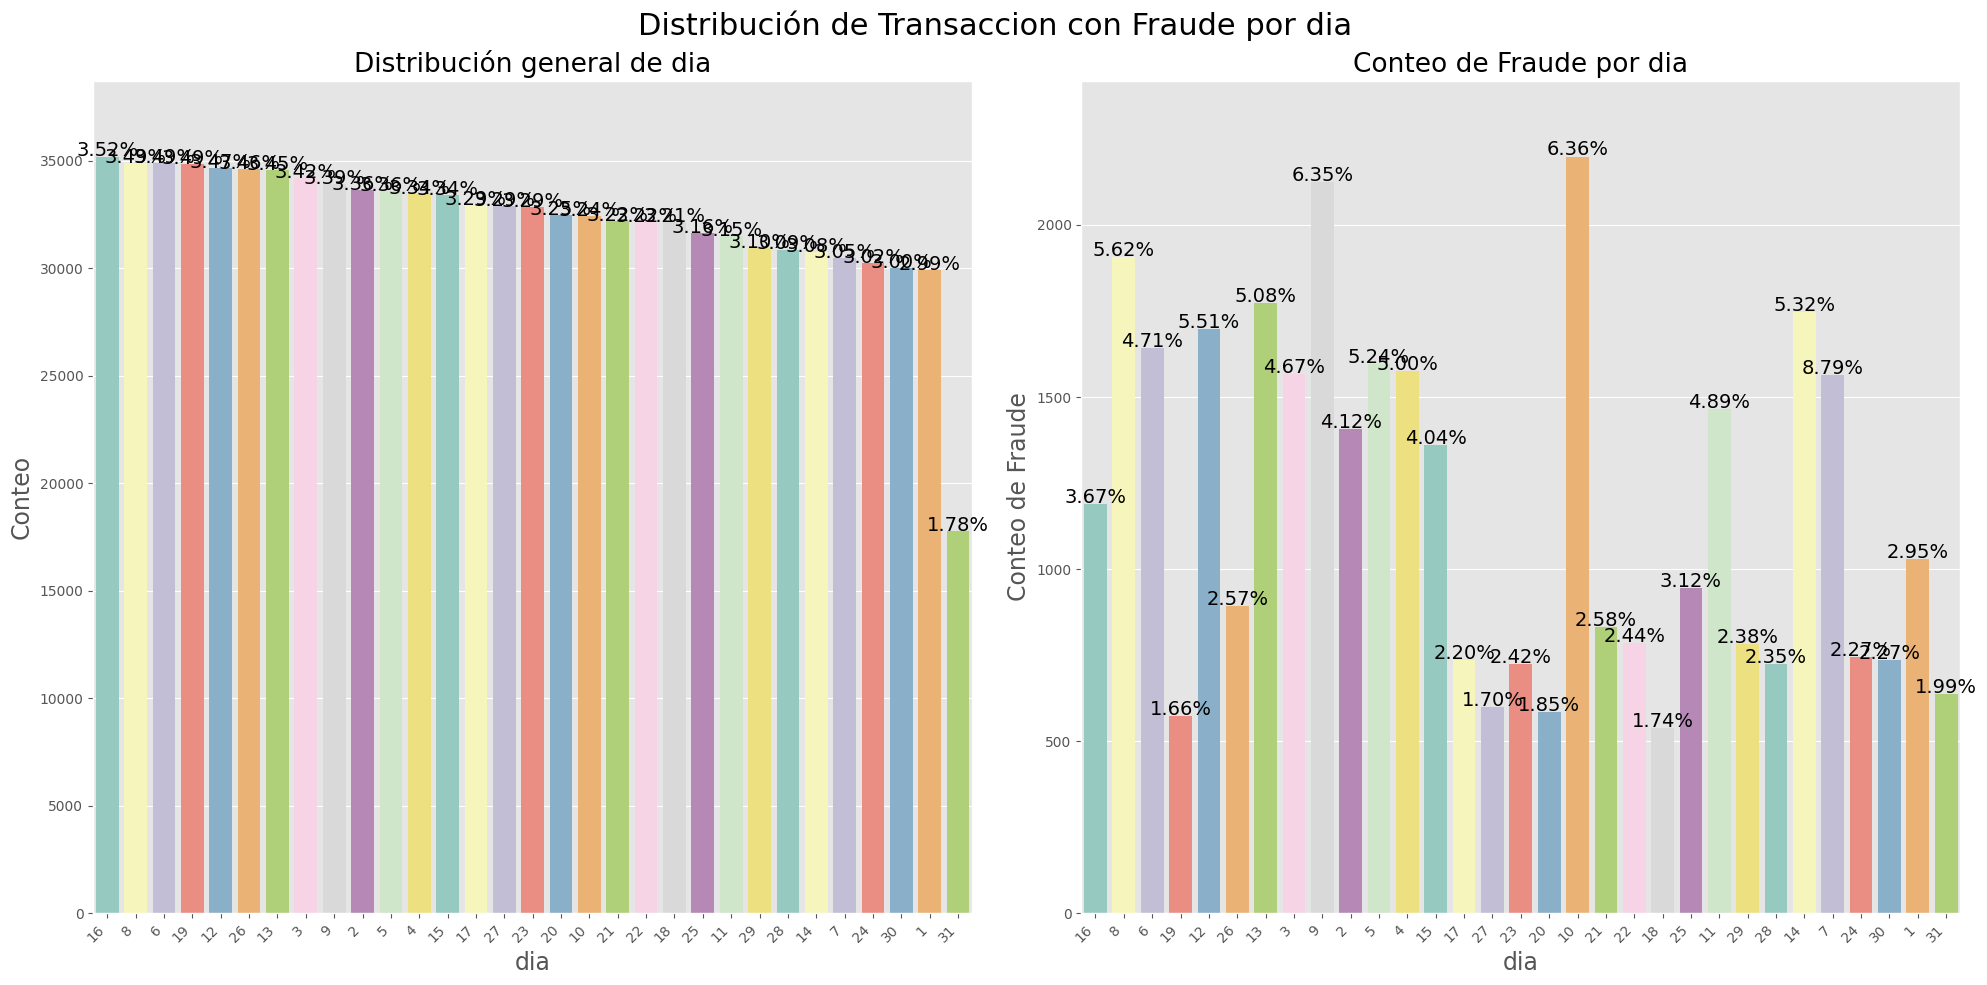

In [31]:
plot_Fraude(df, 'dia')

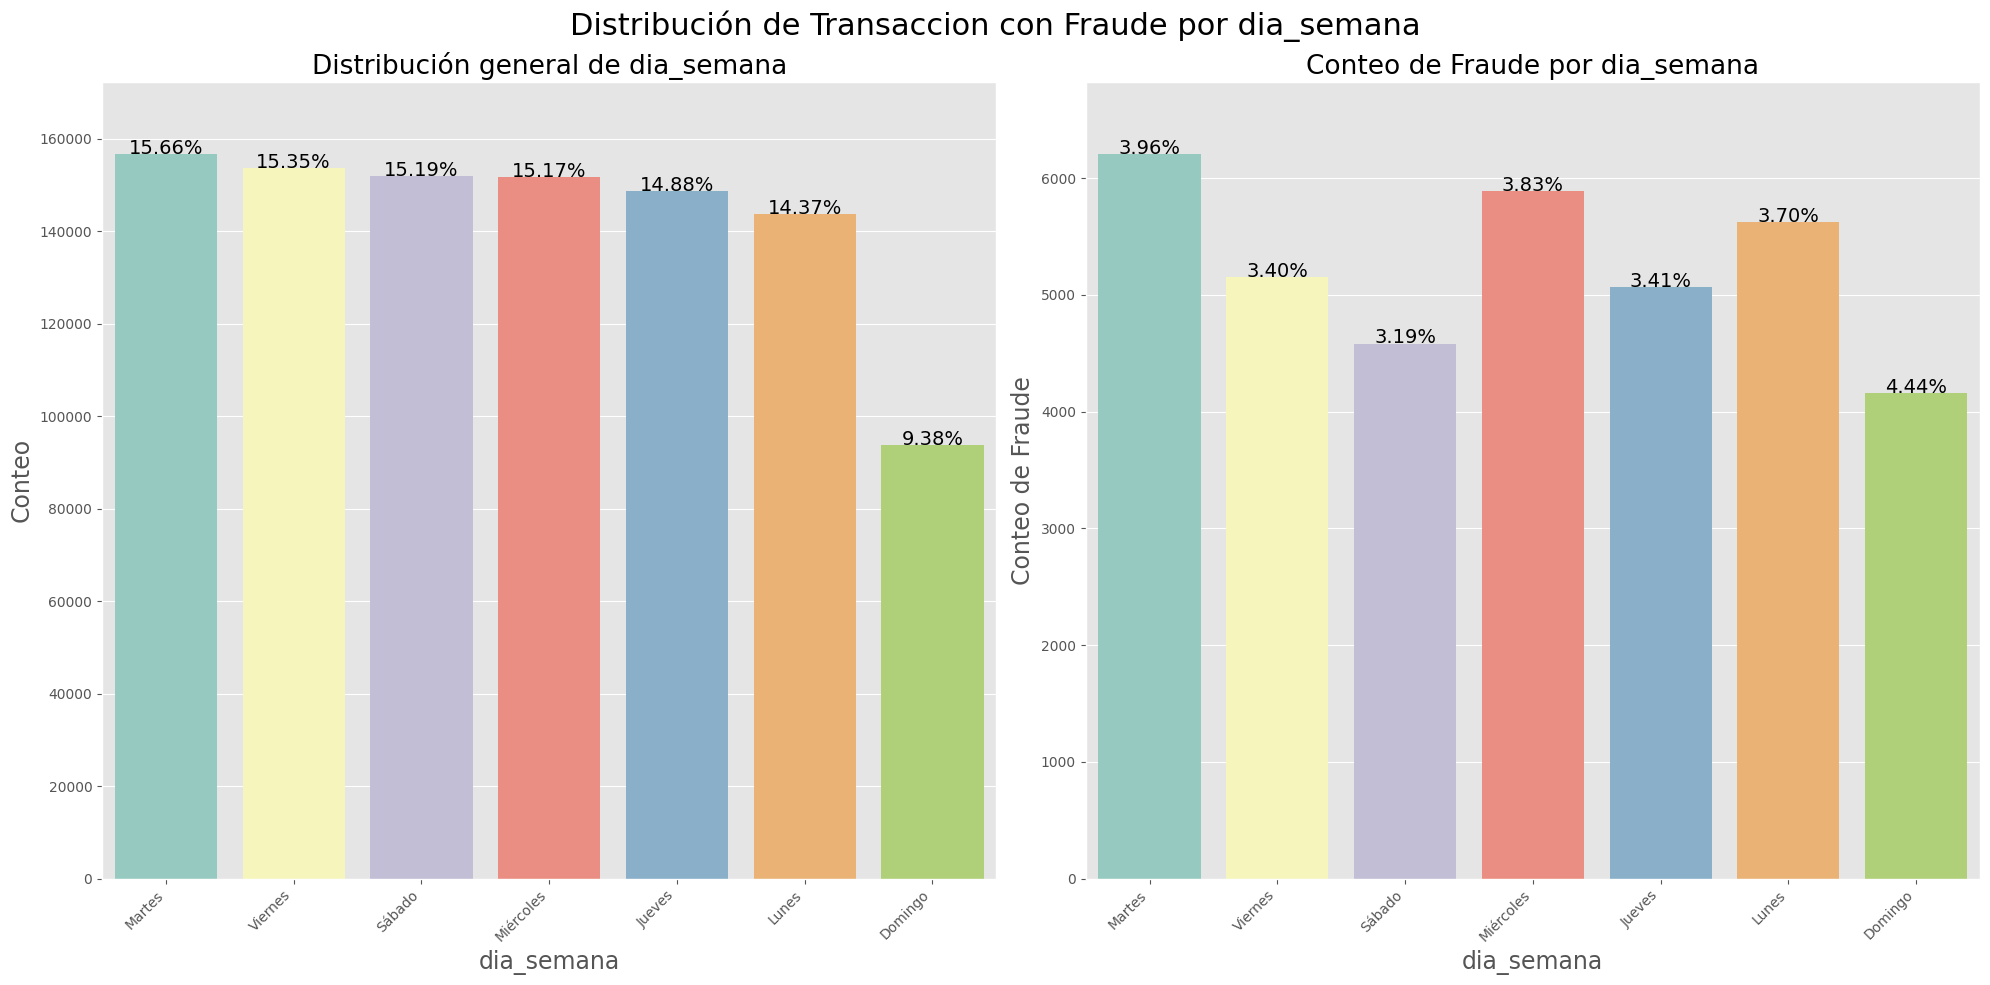

In [32]:
plot_Fraude(df, 'dia_semana')

## Análisis por hora

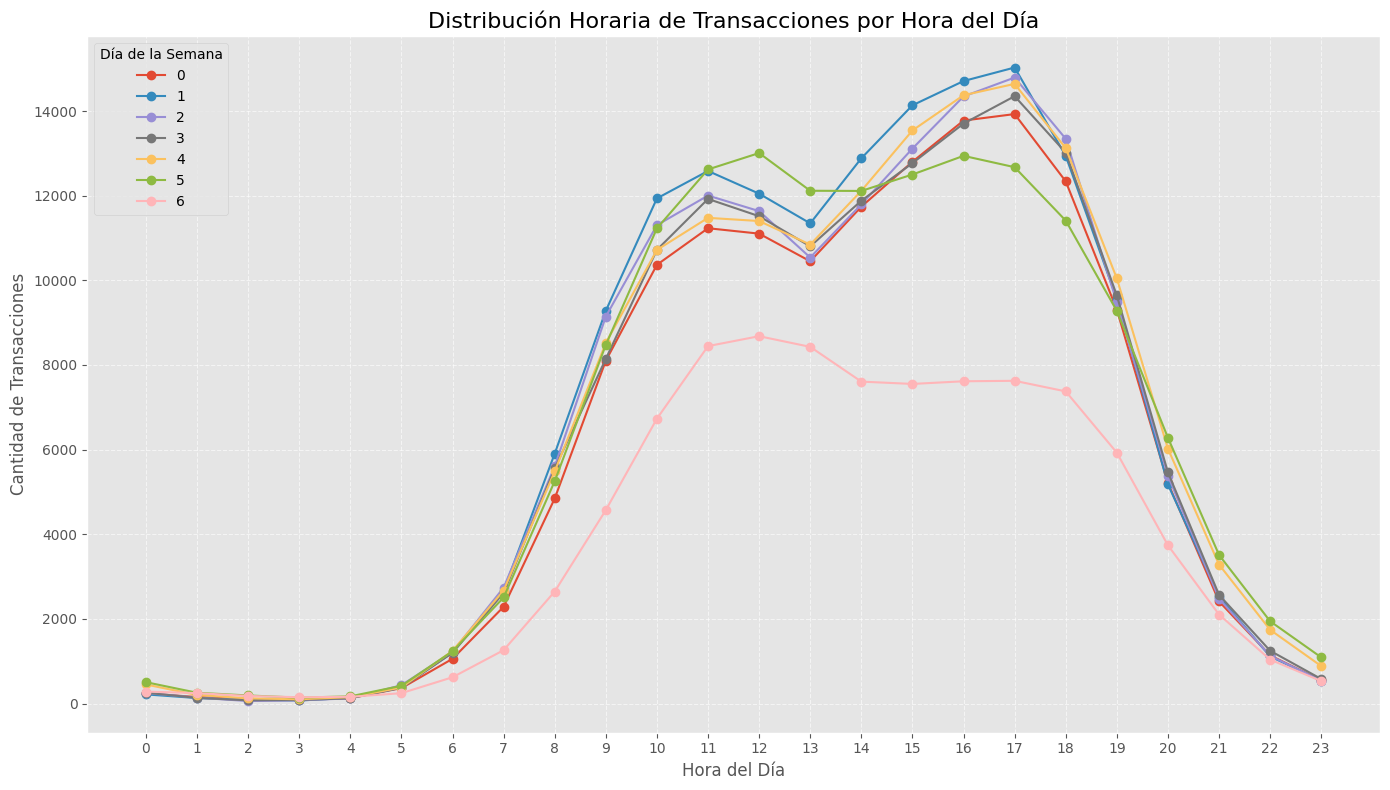

In [131]:


# Agrupar transacciones por hora y día de la semana
transacciones_agrupadas = df.groupby(['hora', 'dia_semana']).size().reset_index(name='cantidad')

# Reordenar los días de la semana
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
transacciones_agrupadas['dia_sem'] = pd.Categorical(transacciones_agrupadas['dia_semana'], categories=orden_dias, ordered=True)

# Pivotear datos para crear líneas por cada día
pivot_data = transacciones_agrupadas.pivot(index='hora', columns='dia_semana', values='cantidad').fillna(0)

# Gráfico de líneas múltiples
plt.figure(figsize=(14, 8))
for dia in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[dia], label=dia, marker='o')  # Líneas con marcadores

# Configuración del gráfico
plt.title("Distribución Horaria de Transacciones por Hora del Día", fontsize=16)
plt.xlabel("Hora del Día", fontsize=12)
plt.ylabel("Cantidad de Transacciones", fontsize=12)
plt.xticks(ticks=range(0, 24), labels=range(0, 24))  # Mostrar horas de 0 a 23
plt.legend(title="Día de la Semana", loc='upper left', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)  # Añadir una cuadrícula suave
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## Análisis Diario

  transaction_date  transaction_amount
0       2021-01-01          68569.3908
1       2021-01-02         248837.5000
2       2021-01-03         182690.8824
3       2021-01-04         451248.3236
4       2021-01-05         437419.1328


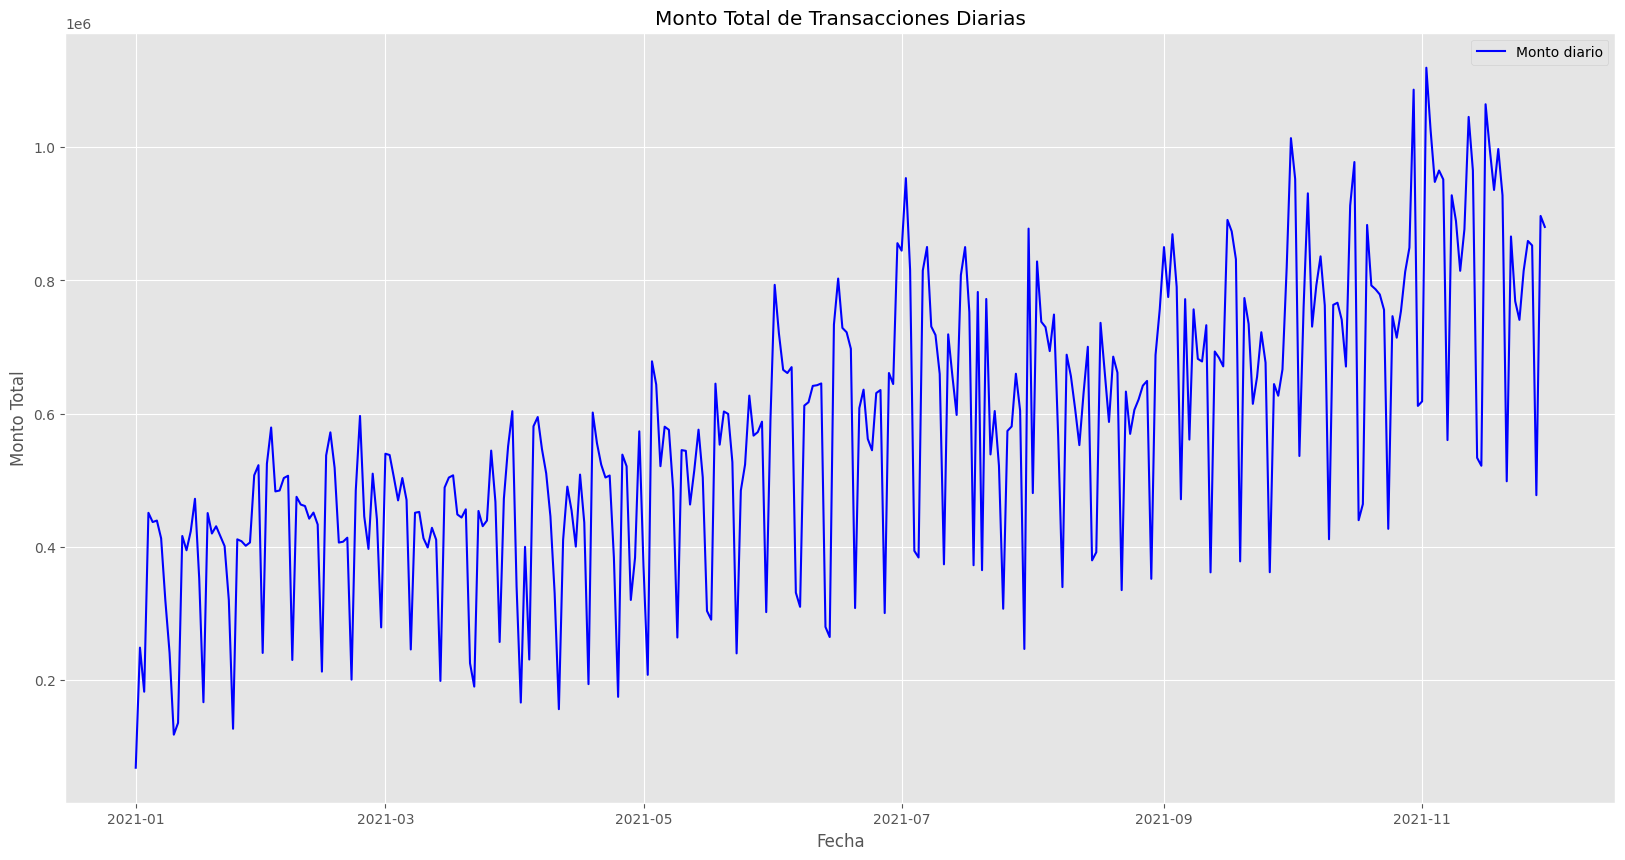

In [34]:
# Monto diario total de transacciones
monto_diario = df.groupby(pd.Grouper(key='transaction_date', freq='D'))['transaction_amount'].sum().reset_index()
print(monto_diario.head())

# Visualización del monto diario
plt.figure(figsize=(20, 10))
plt.plot(monto_diario['transaction_date'], monto_diario['transaction_amount'], color='blue', label='Monto diario')
plt.title("Monto Total de Transacciones Diarias")
plt.xlabel("Fecha")
plt.ylabel("Monto Total")
plt.legend()
plt.show()

  transaction_date transaction_type  transaction_amount
0       2021-01-01          CREDITO           3492.4791
1       2021-01-01           DEBITO          65076.9117
2       2021-01-02          CREDITO          33210.8629
3       2021-01-02           DEBITO         215626.6371
4       2021-01-03          CREDITO          21082.1666


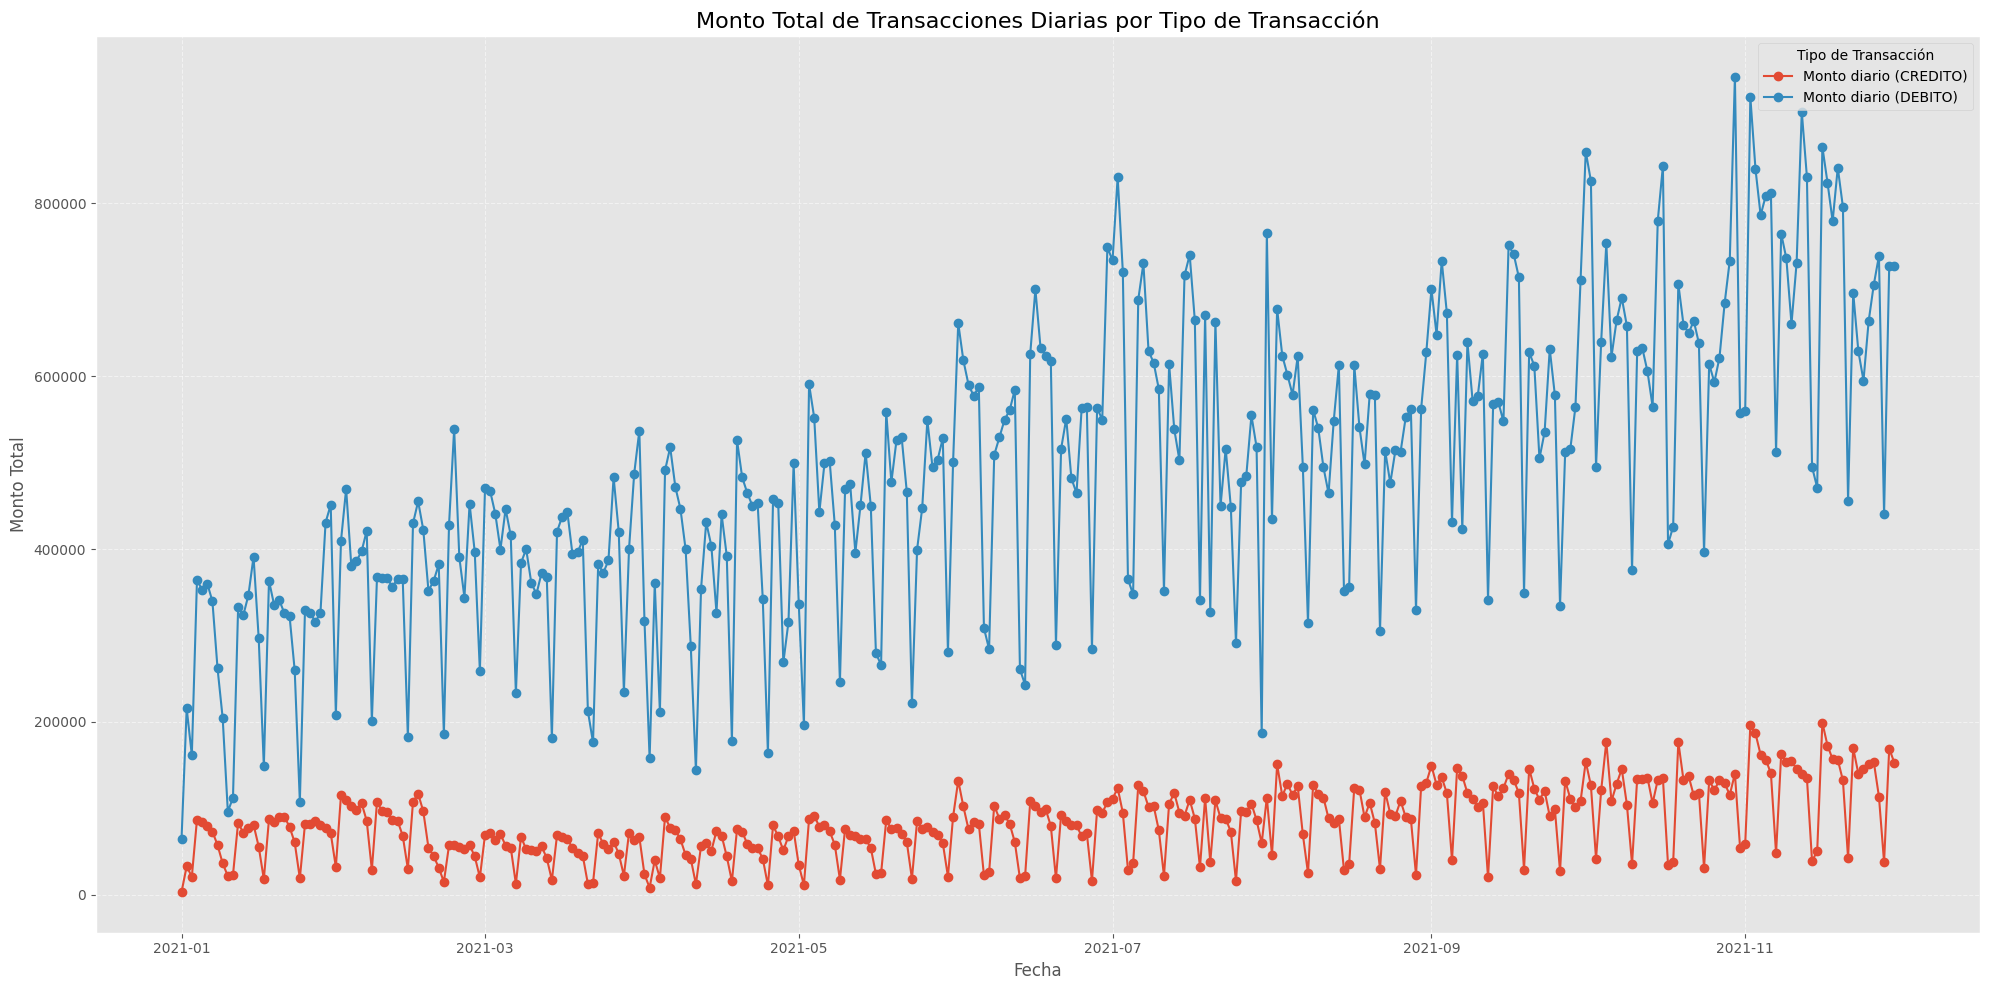

In [35]:
# Monto diario total por tipo de transacción
monto_diario_tipo = df.groupby([pd.Grouper(key='transaction_date', freq='D'), 'transaction_type']) \
    ['transaction_amount'].sum().reset_index()

print(monto_diario_tipo.head())

# Gráfico del monto diario total por tipo de transacción
plt.figure(figsize=(20, 10))

for tipo in monto_diario_tipo['transaction_type'].unique():
    data = monto_diario_tipo[monto_diario_tipo['transaction_type'] == tipo]
    plt.plot(data['transaction_date'], data['transaction_amount'], label=f'Monto diario ({tipo})', marker='o')

# Configuración del gráfico
plt.title("Monto Total de Transacciones Diarias por Tipo de Transacción", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Monto Total", fontsize=12)
plt.legend(title="Tipo de Transacción")
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


  transaction_date  cantidad
0       2021-01-01       839
1       2021-01-02      1936
2       2021-01-03      1692
3       2021-01-04      3164
4       2021-01-05      3165


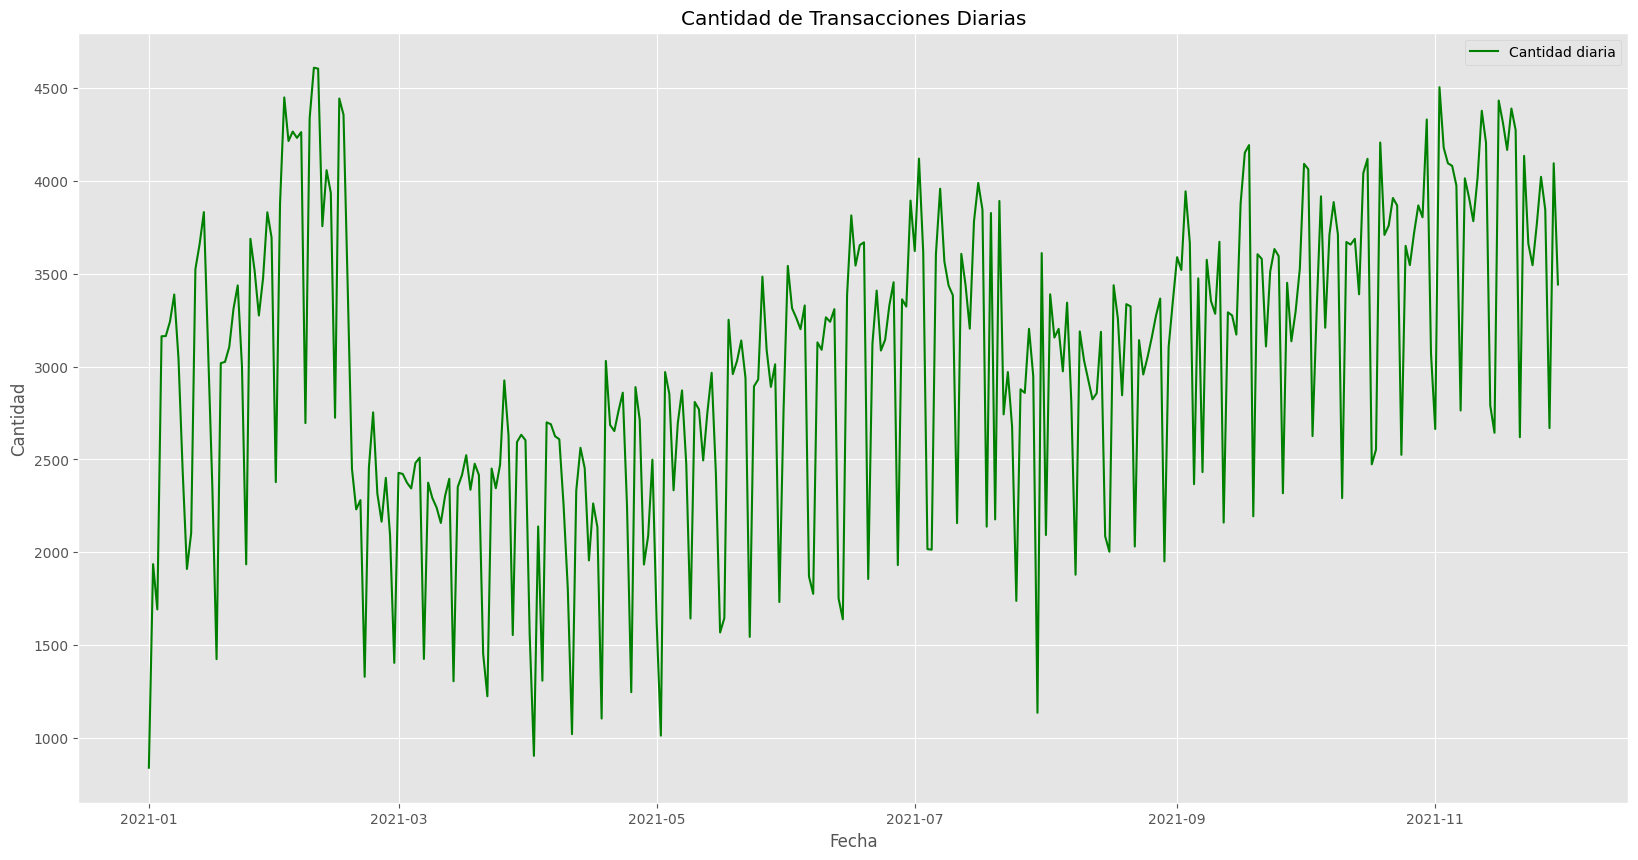

In [36]:
# Cantidad de transacciones diarias
transacciones_diarias = df.groupby(pd.Grouper(key='transaction_date', freq='D')).size().reset_index(name='cantidad')
print(transacciones_diarias.head())

# Gráfico de la cantidad de transacciones diarias
plt.figure(figsize=(20, 10))
plt.plot(transacciones_diarias['transaction_date'], transacciones_diarias['cantidad'], color='green', label='Cantidad diaria')
plt.title("Cantidad de Transacciones Diarias")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

  transaction_date transaction_type  cantidad
0       2021-01-01          CREDITO       299
1       2021-01-01           DEBITO       540
2       2021-01-02          CREDITO       631
3       2021-01-02           DEBITO      1305
4       2021-01-03          CREDITO       552


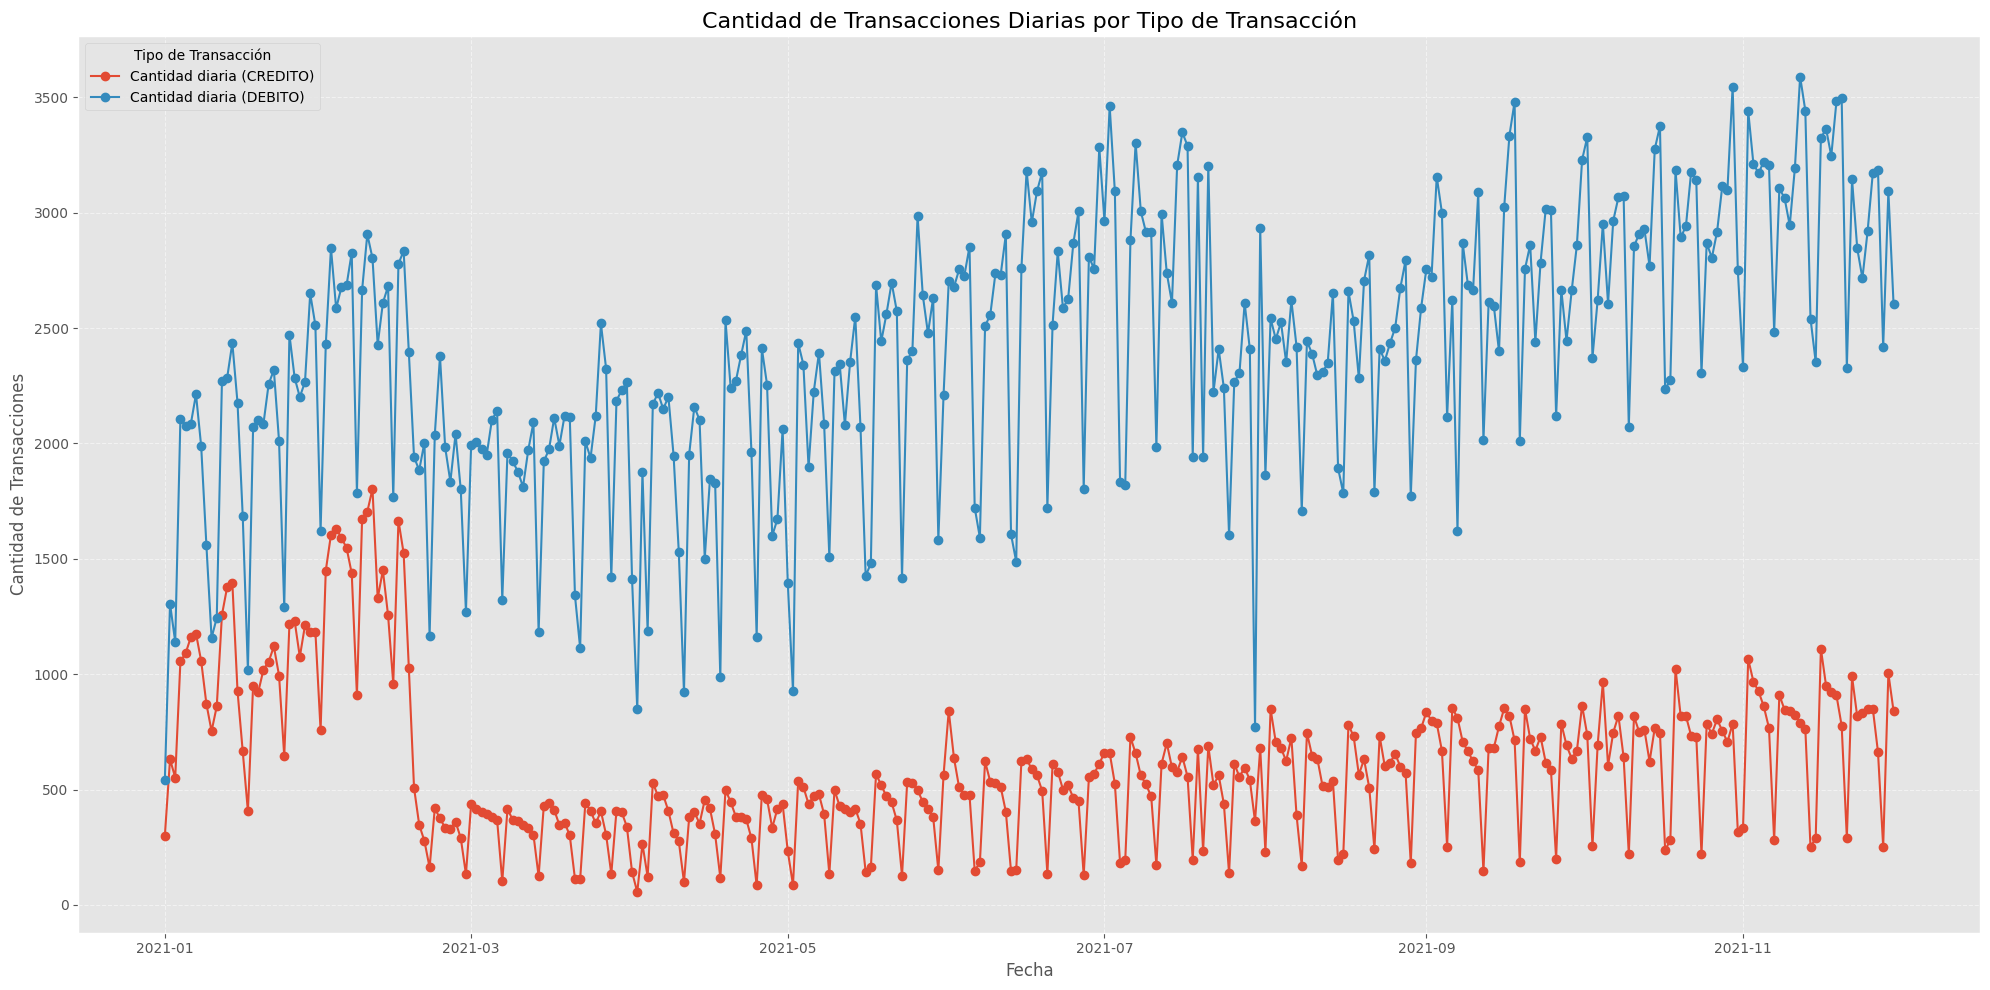

In [37]:
# Cantidad de transacciones diarias por tipo de transacción
transacciones_diarias_tipo = df.groupby([pd.Grouper(key='transaction_date', freq='D'), 'transaction_type']) \
    .size().reset_index(name='cantidad')

print(transacciones_diarias_tipo.head())

# Gráfico de la cantidad de transacciones diarias por tipo
plt.figure(figsize=(20, 10))

for tipo in transacciones_diarias_tipo['transaction_type'].unique():
    data = transacciones_diarias_tipo[transacciones_diarias_tipo['transaction_type'] == tipo]
    plt.plot(data['transaction_date'], data['cantidad'], label=f'Cantidad diaria ({tipo})', marker='o')

# Configuración del gráfico
plt.title("Cantidad de Transacciones Diarias por Tipo de Transacción", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Cantidad de Transacciones", fontsize=12)
plt.legend(title="Tipo de Transacción")
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Análisis por día de la semana

  dia_semana  cantidad
0      Lunes    143746
1     Martes    156610
2  Miércoles    151682
3     Jueves    148763
4    Viernes    153547
5     Sábado    151876
6    Domingo     93776


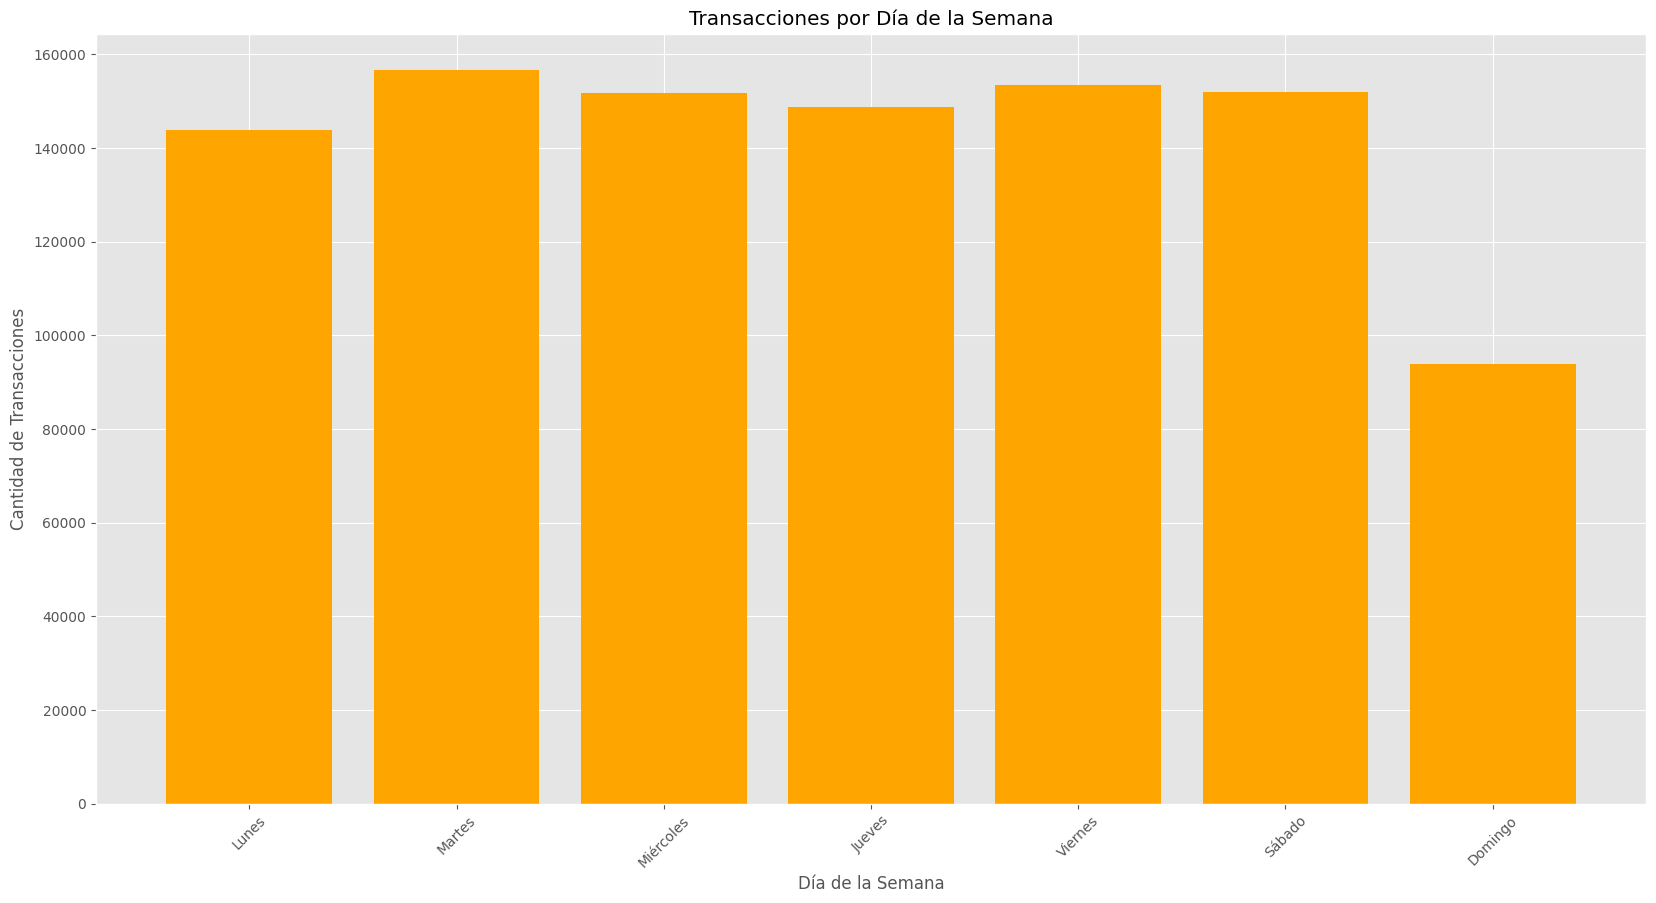

In [38]:
# Análisis por día de la semana
df['dia_semana'] = df['transaction_date'].dt.dayofweek
dias_semana = transacciones_diarias.copy()
dias_semana['dia_semana'] = dias_semana['transaction_date'].dt.dayofweek
cantidad_por_dia = dias_semana.groupby('dia_semana')['cantidad'].sum().reset_index()
cantidad_por_dia['dia_semana'] = cantidad_por_dia['dia_semana'].replace({
    0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
})
print(cantidad_por_dia)

# Gráfico de transacciones por día de la semana
plt.figure(figsize=(20, 10))
plt.bar(cantidad_por_dia['dia_semana'], cantidad_por_dia['cantidad'], color='orange')
plt.title("Transacciones por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Cantidad de Transacciones")
plt.xticks(rotation=45)
plt.show()

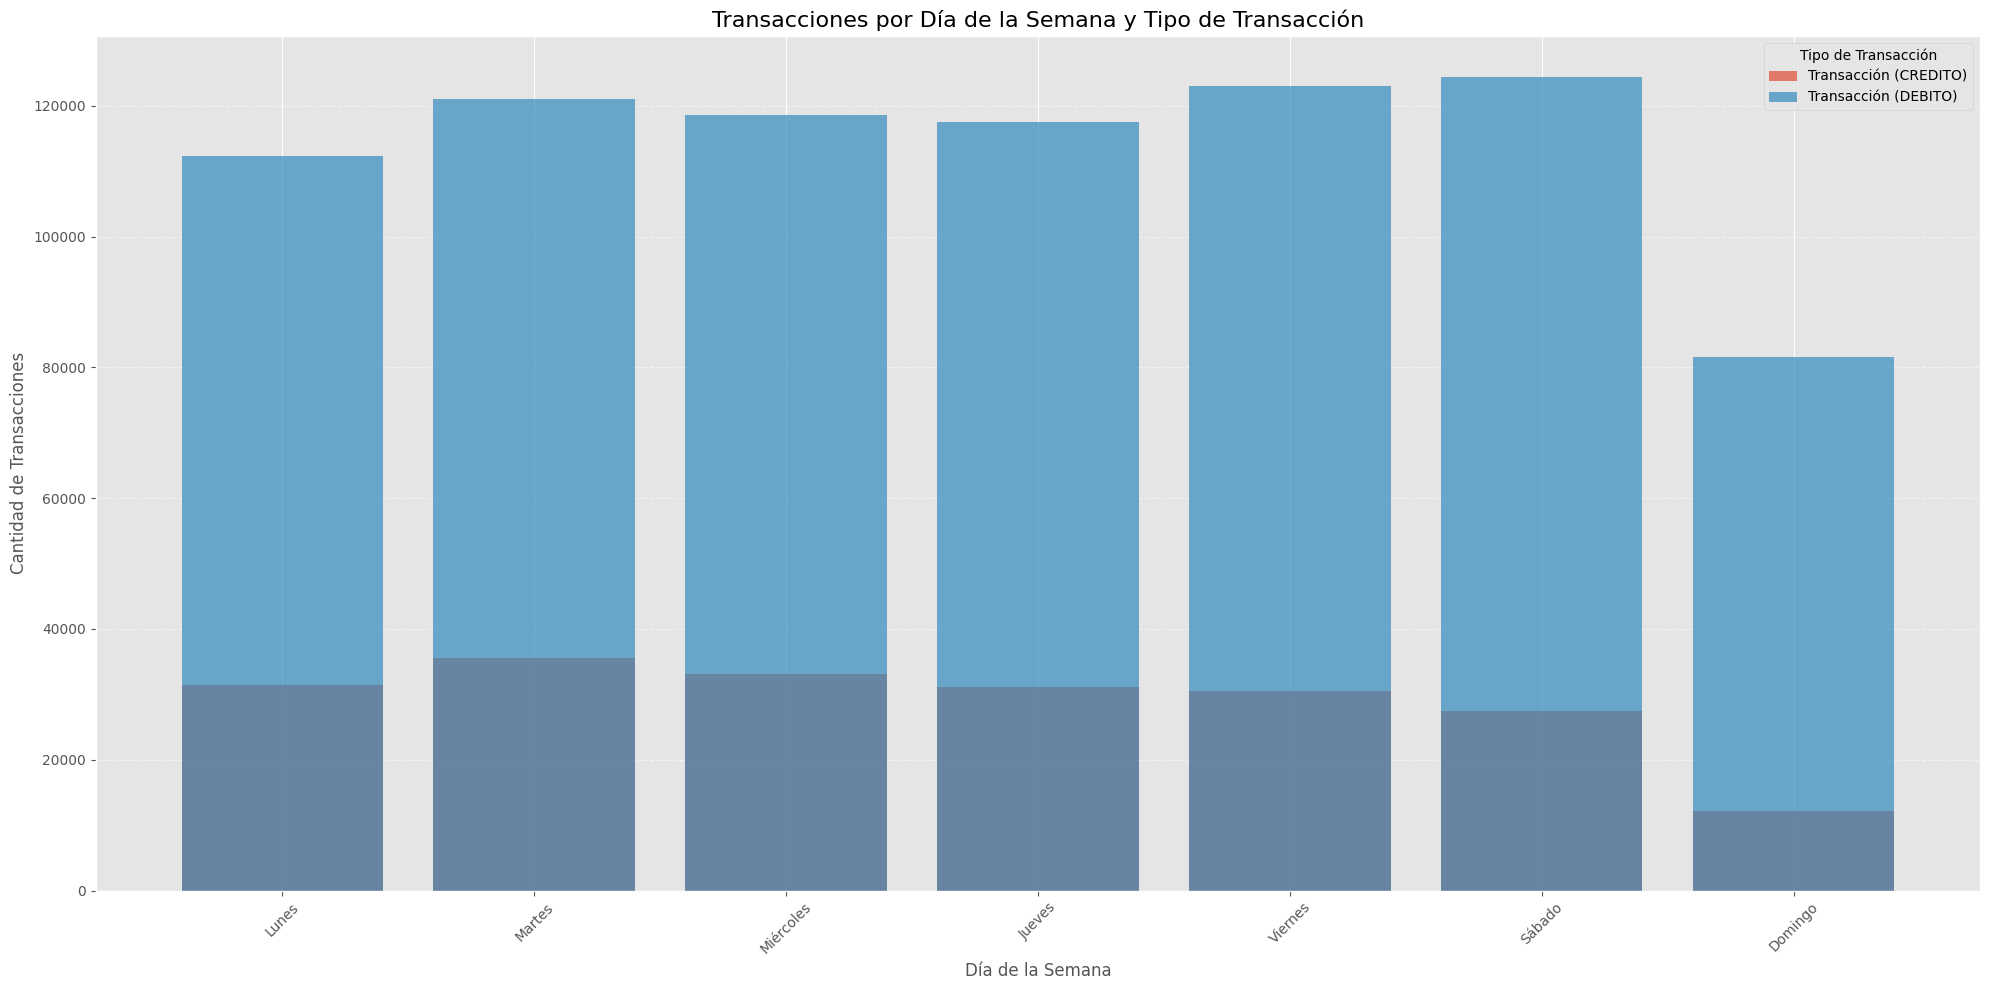

In [39]:
# Agregar columna del día de la semana
df['dia_semana'] = df['transaction_date'].dt.dayofweek

# Análisis por día de la semana y tipo de transacción
cantidad_por_dia_tipo = df.groupby(['dia_semana', 'transaction_type']).size().reset_index(name='cantidad')

# Reemplazar los valores numéricos de los días de la semana por sus nombres
cantidad_por_dia_tipo['dia_semana'] = cantidad_por_dia_tipo['dia_semana'].replace({
    0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
})

# Reordenar los días de la semana
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
cantidad_por_dia_tipo['dia_semana'] = pd.Categorical(cantidad_por_dia_tipo['dia_semana'], categories=orden_dias, ordered=True)

# Gráfico de barras agrupadas por día de la semana y tipo de transacción
plt.figure(figsize=(20, 10))
for tipo in cantidad_por_dia_tipo['transaction_type'].unique():
    data = cantidad_por_dia_tipo[cantidad_por_dia_tipo['transaction_type'] == tipo]
    plt.bar(data['dia_semana'], data['cantidad'], label=f'Transacción ({tipo})', alpha=0.7)

# Configuración del gráfico
plt.title("Transacciones por Día de la Semana y Tipo de Transacción", fontsize=16)
plt.xlabel("Día de la Semana", fontsize=12)
plt.ylabel("Cantidad de Transacciones", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Tipo de Transacción")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##  Análisis mensual

  transaction_date  cantidad
0       2021-01-31     89528
1       2021-02-28     92141
2       2021-03-31     70461
3       2021-04-30     66031
4       2021-05-31     79591
  transaction_date  transaction_amount
0       2021-01-31       10749492.2670
1       2021-02-28       12466319.2834
2       2021-03-31       13515054.4092
3       2021-04-30       12789884.0186
4       2021-05-31       15498850.0269


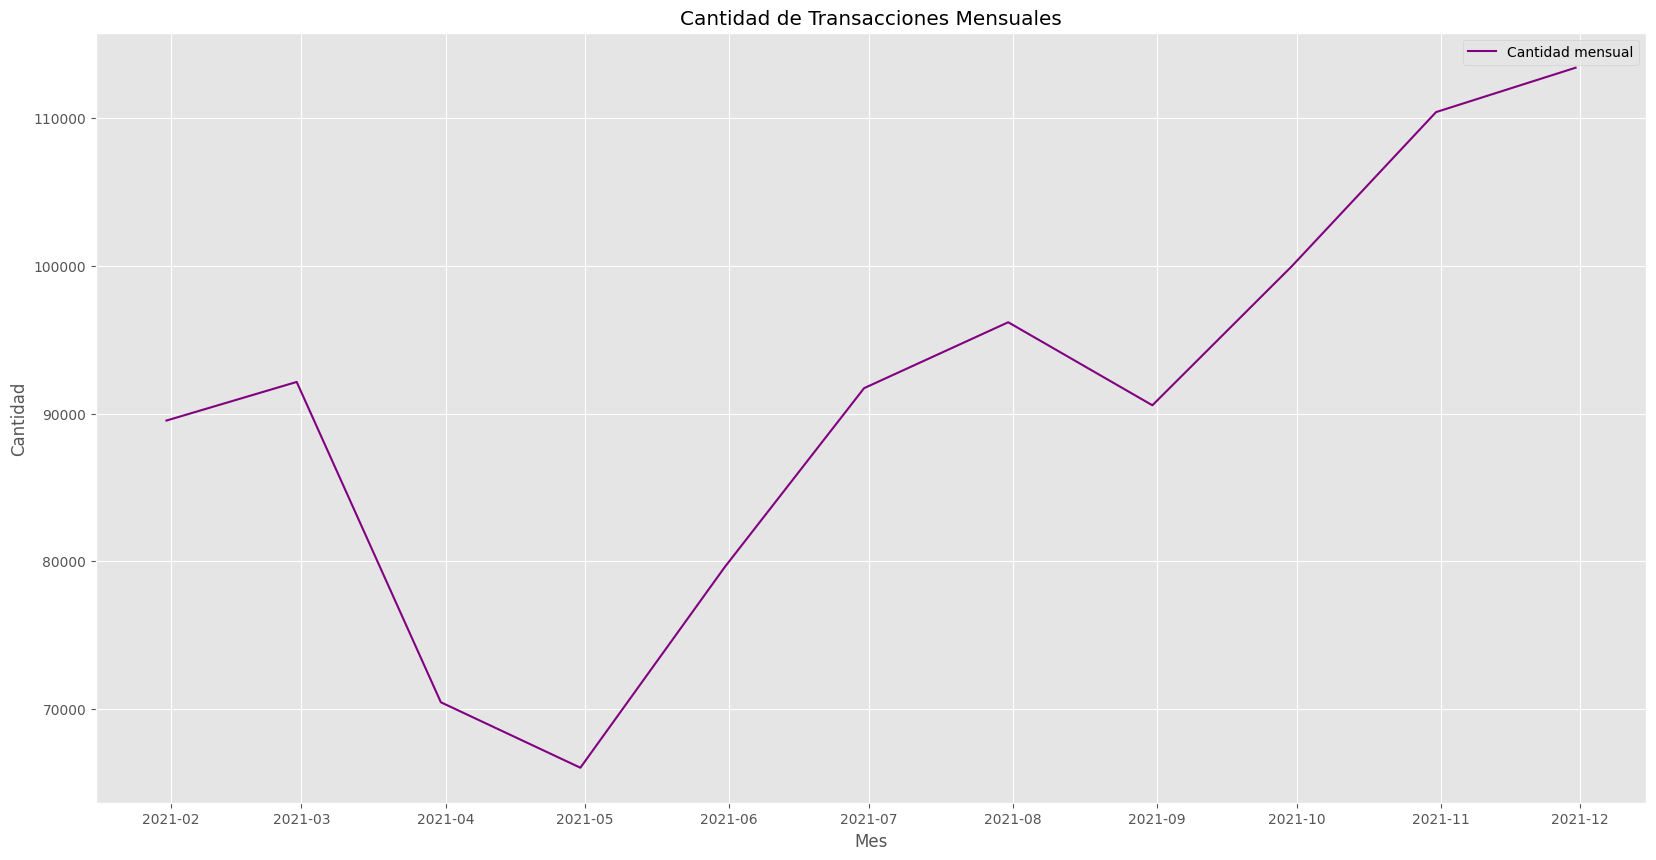

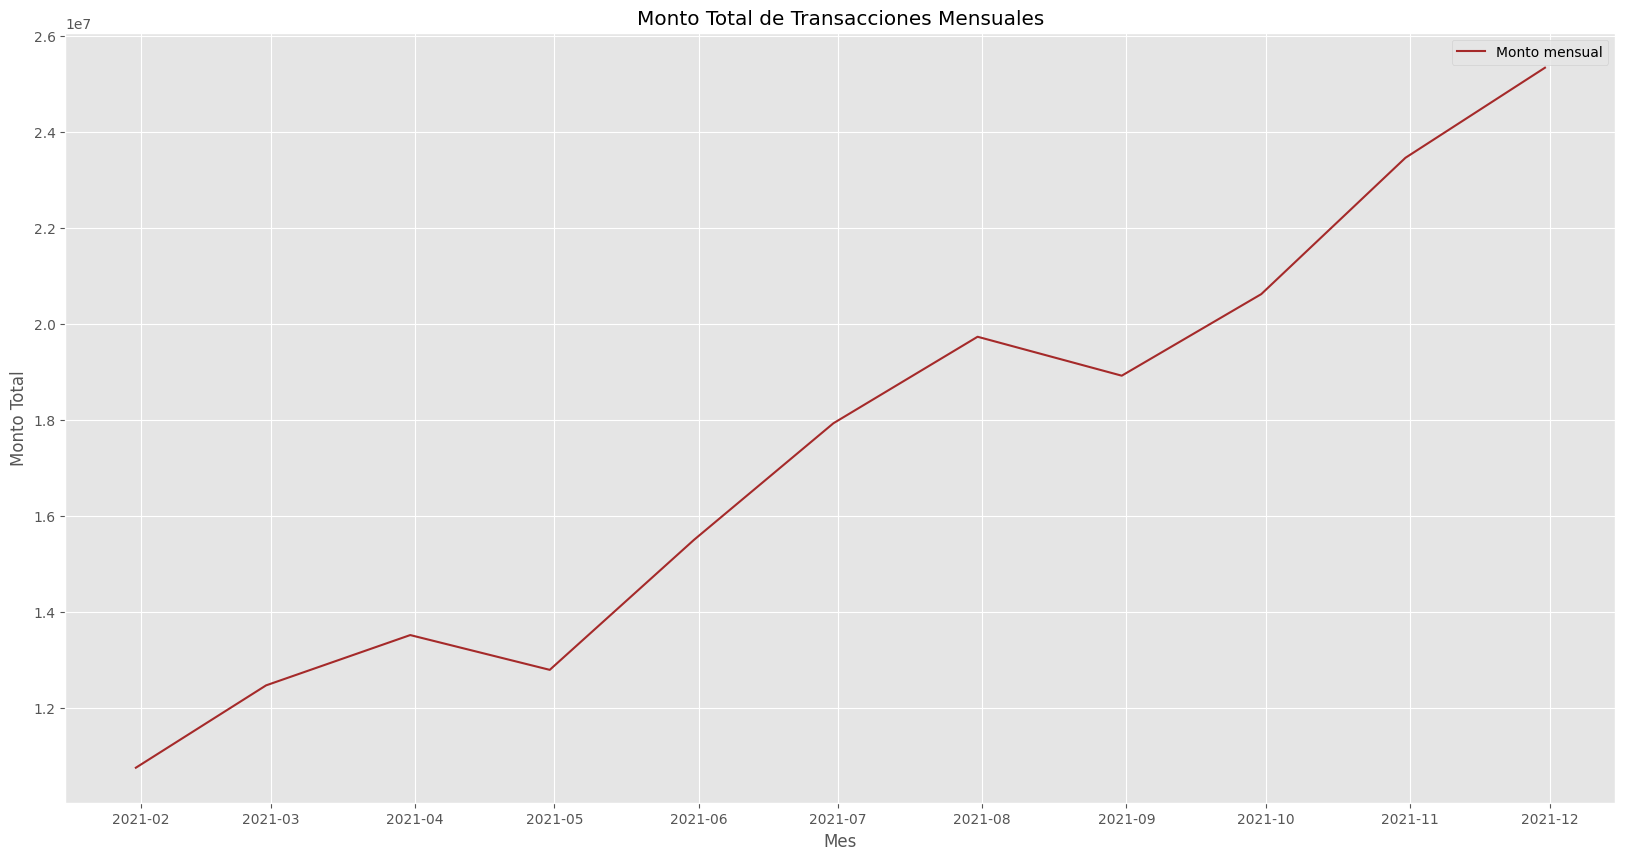

In [40]:
# Análisis mensual
transacciones_mensuales = df.groupby(pd.Grouper(key='transaction_date', freq='M')).size().reset_index(name='cantidad')
monto_mensual = df.groupby(pd.Grouper(key='transaction_date', freq='M'))['transaction_amount'].sum().reset_index()

print(transacciones_mensuales.head())
print(monto_mensual.head())

# Gráficos de análisis mensual
plt.figure(figsize=(20, 10))
plt.plot(transacciones_mensuales['transaction_date'], transacciones_mensuales['cantidad'], color='purple', label='Cantidad mensual')
plt.title("Cantidad de Transacciones Mensuales")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(monto_mensual['transaction_date'], monto_mensual['transaction_amount'], color='brown', label='Monto mensual')
plt.title("Monto Total de Transacciones Mensuales")
plt.xlabel("Mes")
plt.ylabel("Monto Total")
plt.legend()
plt.show()


  transaction_date transaction_type  cantidad
0       2021-01-31          CREDITO     30100
1       2021-01-31           DEBITO     59428
2       2021-02-28          CREDITO     28095
3       2021-02-28           DEBITO     64046
4       2021-03-31          CREDITO     10459
  transaction_date transaction_type  transaction_amount
0       2021-01-31          CREDITO        1933697.4937
1       2021-01-31           DEBITO        8815794.7733
2       2021-02-28          CREDITO        2032752.1613
3       2021-02-28           DEBITO       10433567.1221
4       2021-03-31          CREDITO        1632688.5592


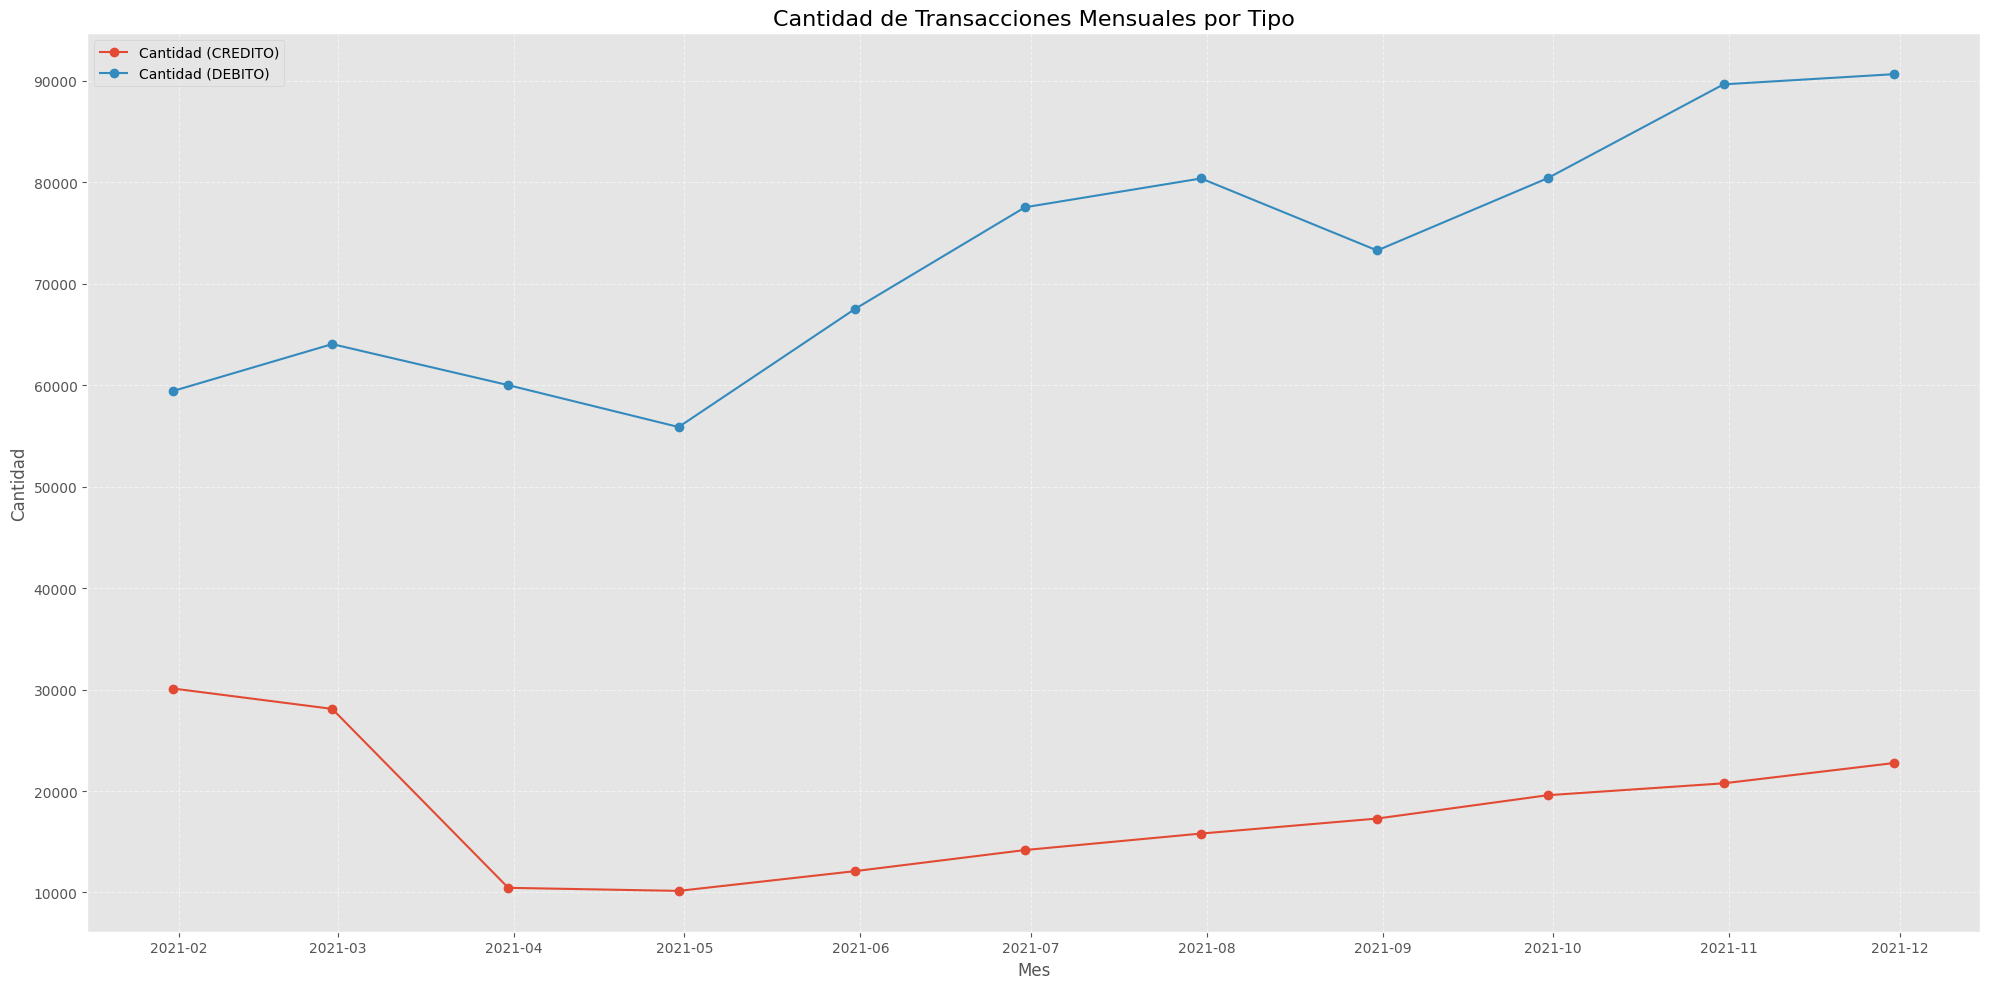

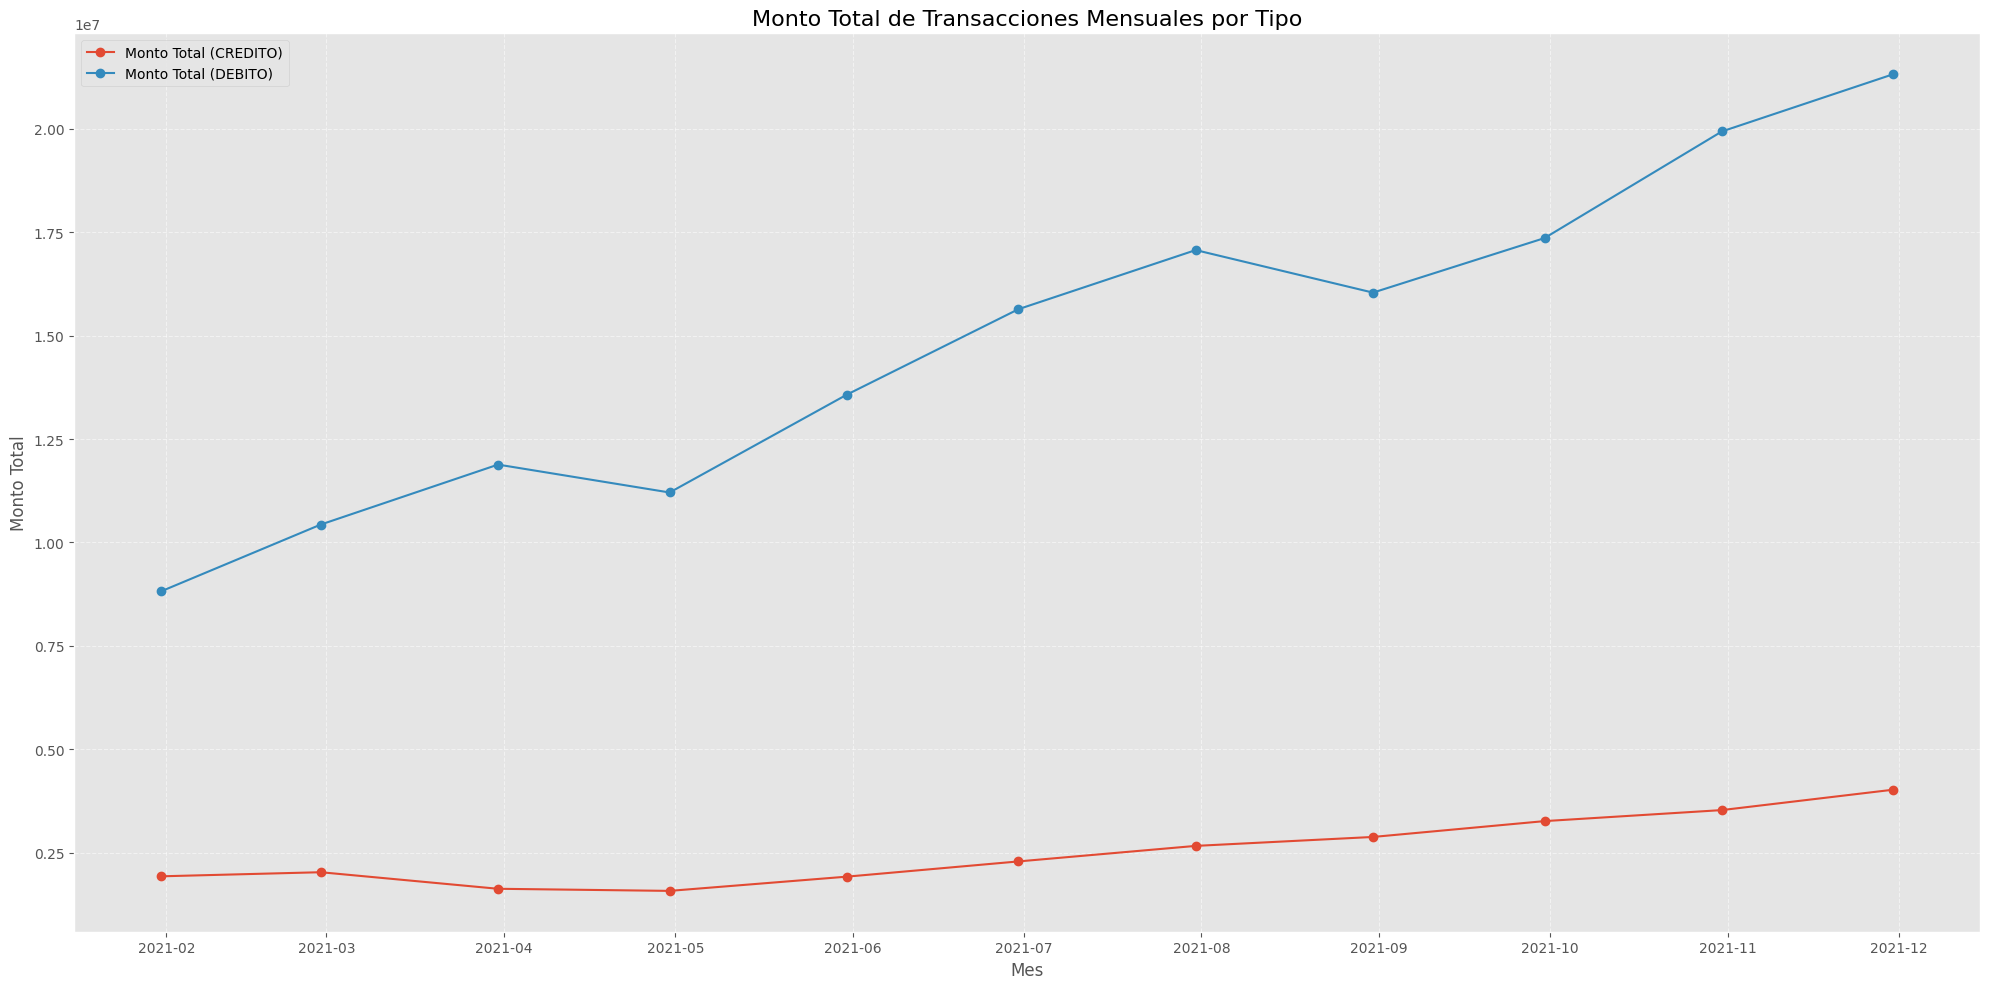

In [41]:

# Análisis mensual por transaction_type
transacciones_mensuales_tipo = df.groupby([pd.Grouper(key='transaction_date', freq='M'), 'transaction_type']) \
    .size().reset_index(name='cantidad')

monto_mensual_tipo = df.groupby([pd.Grouper(key='transaction_date', freq='M'), 'transaction_type']) \
    ['transaction_amount'].sum().reset_index()

# Imprimir ejemplos de las tablas resultantes
print(transacciones_mensuales_tipo.head())
print(monto_mensual_tipo.head())

# Gráfico de cantidad de transacciones mensuales por tipo
plt.figure(figsize=(20, 10))
for tipo in transacciones_mensuales_tipo['transaction_type'].unique():
    data = transacciones_mensuales_tipo[transacciones_mensuales_tipo['transaction_type'] == tipo]
    plt.plot(data['transaction_date'], data['cantidad'], marker='o', label=f'Cantidad ({tipo})')

plt.title("Cantidad de Transacciones Mensuales por Tipo", fontsize=16)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Gráfico de monto total de transacciones mensuales por tipo
plt.figure(figsize=(20, 10))
for tipo in monto_mensual_tipo['transaction_type'].unique():
    data = monto_mensual_tipo[monto_mensual_tipo['transaction_type'] == tipo]
    plt.plot(data['transaction_date'], data['transaction_amount'], marker='o', label=f'Monto Total ({tipo})')

plt.title("Monto Total de Transacciones Mensuales por Tipo", fontsize=16)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Monto Total", fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [42]:
df.head()

merchant_id                               _id  \
15689388  817d18cd3c31e40e9bff0566baae7758  d282461568e06ebad6a14bc095937209   
1907514   817d18cd3c31e40e9bff0566baae7758  0e17de5693b04eacf7a5ede381c01635   
19555549  817d18cd3c31e40e9bff0566baae7758  ff57537a77f98c309a6beb86fa38da95   
15248322  817d18cd3c31e40e9bff0566baae7758  b7f32a750b25f21a2bf158bc557f41c8   
8022707   817d18cd3c31e40e9bff0566baae7758  eaba433eb231d0ca107e6c9505089e7f   

                                subsidiary    transaction_date  \
15689388  7d7a00374bd1b4a5a0c3c98cfa570062 2021-07-02 10:51:32   
1907514   73c9a18fafaa11a5c8e91f09acd3d89e 2021-05-19 19:13:54   
19555549  c70fed7f608d0ae18cd24b233e4a9af0 2021-11-15 19:34:04   
15248322  23b6e598e195241b496b81d95652870e 2021-06-10 14:40:21   
8022707   42b2dfb90bb2f4833e421b9869b5d0fa 2021-11-23 11:40:35   

                            account_number                           user_id  \
15689388  a5a126bb68a00284171f83d0be4ef91a  9a6d0b2a239499b6539b671edfe02cc6   
1907514   59c129c491017c85fd547de52e1f682a  5249a8ae1f4bde0cebf710ef5a80fbfe   
19555549  5c359af4a4957672688585ab015c3c10  e0098f13bb5c41446a2da8ff9ec657ba   
15248322  cb0c2593fad8a92c41d78842f7a5881a  d1a287c0765fe60064efd3c8427fdb7d   
8022707   7b999c12c69e06a3a4601f43c88f6c47  a0e966a5b35c2456e1a8b9848ef05b21   

          transaction_amount transaction_type  fraccionamientos  Fraude  \
15689388            130.7780           DEBITO                 1       0   
1907514             594.4455           DEBITO                 1       0   
19555549             23.7778           DEBITO                 1       0   
15248322            677.6679           DEBITO                 1       0   
8022707              59.4446           DEBITO                 1       0   

          monto_total_24h  proporcion_monto_fraccionado  \
15689388         130.7780                        1.0000   
1907514          594.4455                        1.0000   
19555549          23.7778                        1.0000   
15248322         677.6679                        1.0000   
8022707           59.4446                        1.0000   

          secuencia_transacciones  monto_transaccion  hora  dia  dia_semana  \
15689388                        1           130.7780    10    2           4   
1907514                         1           594.4455    19   19           2   
19555549                        1            23.7778    19   15           0   
15248322                        1           677.6679    14   10           3   
8022707                         1            59.4446    11   23           1   

          mes  anio  
15689388    7  2021  
1907514     5  2021  
19555549   11  2021  
15248322    6  2021  
8022707    11  2021

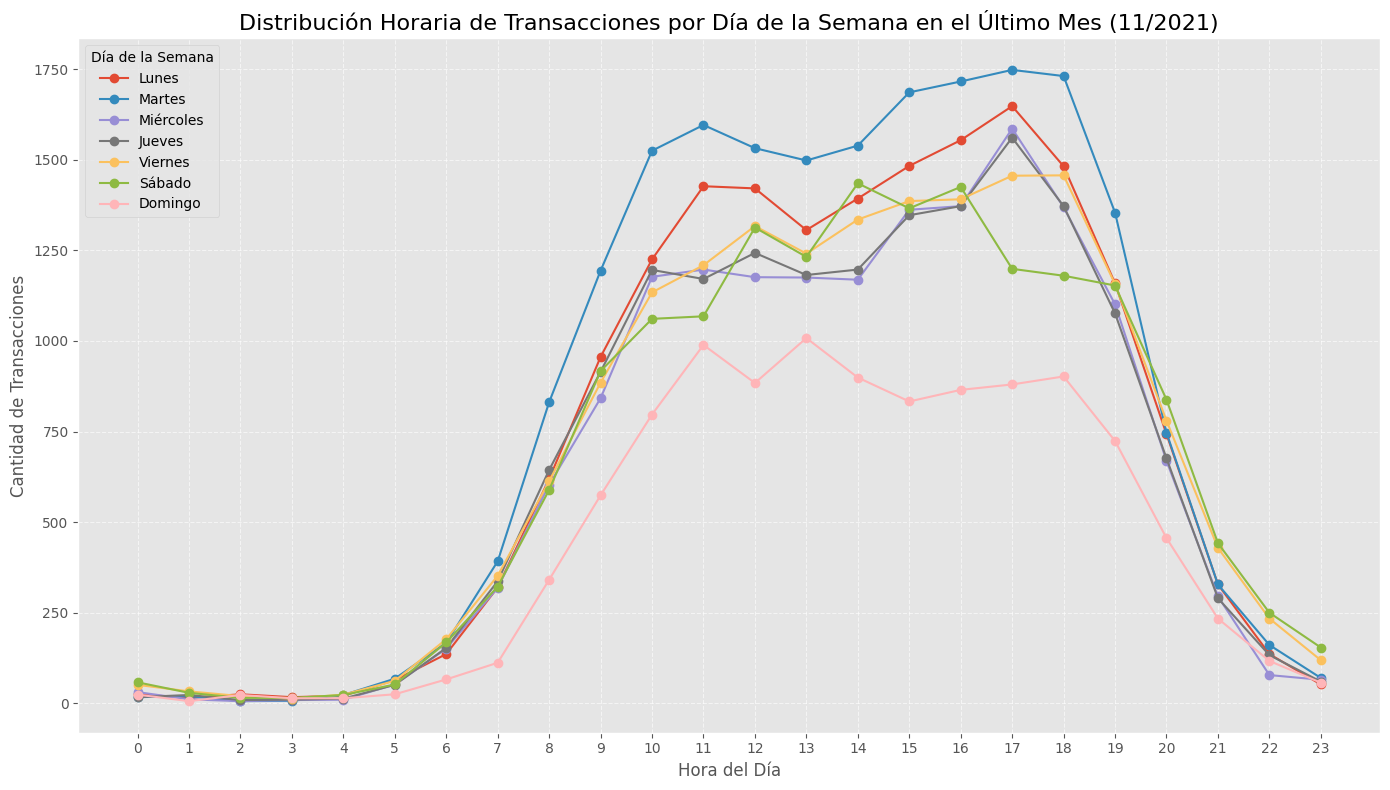

In [43]:
# Filtrar datos para el último mes disponible
ultimo_mes = df['transaction_date'].dt.month.max()
ultimo_anio = df.loc[df['transaction_date'].dt.month == ultimo_mes, 'transaction_date'].dt.year.max()
df_ultimo_mes = df[(df['transaction_date'].dt.month == ultimo_mes) & (df['transaction_date'].dt.year == ultimo_anio)]

# Crear variables de tiempo
df_ultimo_mes['hora'] = df_ultimo_mes['transaction_date'].dt.hour
df_ultimo_mes['dia_semana'] = df_ultimo_mes['transaction_date'].dt.day_name(locale='Spanish')

# Agrupar transacciones por hora y día de la semana
transacciones_agrupadas = df_ultimo_mes.groupby(['hora', 'dia_semana']).size().reset_index(name='cantidad')

# Reordenar los días de la semana
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
transacciones_agrupadas['dia_semana'] = pd.Categorical(transacciones_agrupadas['dia_semana'], categories=orden_dias, ordered=True)

# Pivotear datos para crear líneas por cada día
pivot_data = transacciones_agrupadas.pivot(index='hora', columns='dia_semana', values='cantidad').fillna(0)

# Gráfico de líneas múltiples
plt.figure(figsize=(14, 8))
for dia in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[dia], label=dia, marker='o')  # Líneas con marcadores

# Configuración del gráfico
plt.title(f"Distribución Horaria de Transacciones por Día de la Semana en el Último Mes ({ultimo_mes}/{ultimo_anio})", fontsize=16)
plt.xlabel("Hora del Día", fontsize=12)
plt.ylabel("Cantidad de Transacciones", fontsize=12)
plt.xticks(ticks=range(0, 24), labels=range(0, 24))  # Mostrar horas de 0 a 23
plt.legend(title="Día de la Semana", loc='upper left', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)  # Añadir una cuadrícula suave
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [44]:
df.head()

merchant_id                               _id  \
15689388  817d18cd3c31e40e9bff0566baae7758  d282461568e06ebad6a14bc095937209   
1907514   817d18cd3c31e40e9bff0566baae7758  0e17de5693b04eacf7a5ede381c01635   
19555549  817d18cd3c31e40e9bff0566baae7758  ff57537a77f98c309a6beb86fa38da95   
15248322  817d18cd3c31e40e9bff0566baae7758  b7f32a750b25f21a2bf158bc557f41c8   
8022707   817d18cd3c31e40e9bff0566baae7758  eaba433eb231d0ca107e6c9505089e7f   

                                subsidiary    transaction_date  \
15689388  7d7a00374bd1b4a5a0c3c98cfa570062 2021-07-02 10:51:32   
1907514   73c9a18fafaa11a5c8e91f09acd3d89e 2021-05-19 19:13:54   
19555549  c70fed7f608d0ae18cd24b233e4a9af0 2021-11-15 19:34:04   
15248322  23b6e598e195241b496b81d95652870e 2021-06-10 14:40:21   
8022707   42b2dfb90bb2f4833e421b9869b5d0fa 2021-11-23 11:40:35   

                            account_number                           user_id  \
15689388  a5a126bb68a00284171f83d0be4ef91a  9a6d0b2a239499b6539b671edfe02cc6   
1907514   59c129c491017c85fd547de52e1f682a  5249a8ae1f4bde0cebf710ef5a80fbfe   
19555549  5c359af4a4957672688585ab015c3c10  e0098f13bb5c41446a2da8ff9ec657ba   
15248322  cb0c2593fad8a92c41d78842f7a5881a  d1a287c0765fe60064efd3c8427fdb7d   
8022707   7b999c12c69e06a3a4601f43c88f6c47  a0e966a5b35c2456e1a8b9848ef05b21   

          transaction_amount transaction_type  fraccionamientos  Fraude  \
15689388            130.7780           DEBITO                 1       0   
1907514             594.4455           DEBITO                 1       0   
19555549             23.7778           DEBITO                 1       0   
15248322            677.6679           DEBITO                 1       0   
8022707              59.4446           DEBITO                 1       0   

          monto_total_24h  proporcion_monto_fraccionado  \
15689388         130.7780                        1.0000   
1907514          594.4455                        1.0000   
19555549          23.7778                        1.0000   
15248322         677.6679                        1.0000   
8022707           59.4446                        1.0000   

          secuencia_transacciones  monto_transaccion  hora  dia  dia_semana  \
15689388                        1           130.7780    10    2           4   
1907514                         1           594.4455    19   19           2   
19555549                        1            23.7778    19   15           0   
15248322                        1           677.6679    14   10           3   
8022707                         1            59.4446    11   23           1   

          mes  anio  
15689388    7  2021  
1907514     5  2021  
19555549   11  2021  
15248322    6  2021  
8022707    11  2021

In [45]:
df['secuencia_transacciones'].value_counts()

secuencia_transacciones
1     975189
2      11868
3       4536
4       2855
5       1832
6       1207
7        810
8        551
9        374
10       259
11       169
12       125
13        78
14        49
15        31
16        24
17        17
18        11
19         8
20         5
22         1
21         1
Name: count, dtype: int64

In [46]:
df.columns

Index(['merchant_id', '_id', 'subsidiary', 'transaction_date',
       'account_number', 'user_id', 'transaction_amount', 'transaction_type',
       'fraccionamientos', 'Fraude', 'monto_total_24h',
       'proporcion_monto_fraccionado', 'secuencia_transacciones',
       'monto_transaccion', 'hora', 'dia', 'dia_semana', 'mes', 'anio'],
      dtype='object')

### ¿Existe multicolinealidad en nuestros datos?

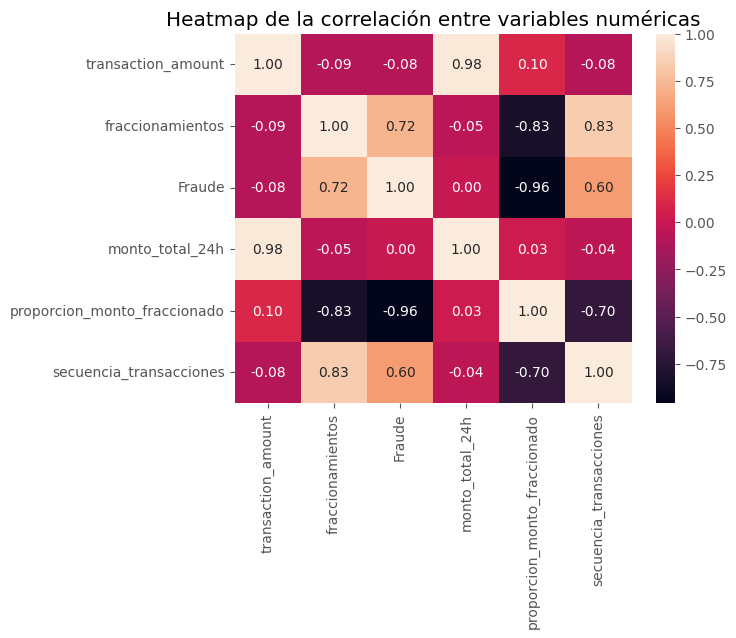

In [47]:
# Calcula la matriz de correlación
correlation = df[var_numericas].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.title('Heatmap de la correlación entre variables numéricas')
plt.show()

### Si la correlación supera 0,5, nuestro código identificará y devolverá los pares que presenten una alta correlación.

In [48]:
# Matriz de correlación del DataFrame
correlacion = df[var_numericas].corr()

# Obtener pares de columnas con correlación > 0.5
pares_alta_corr = [(col1, col2, correlacion.loc[col1, col2]) 
                   for i, col1 in enumerate(correlacion.columns) 
                   for col2 in correlacion.columns[i+1:] 
                   if abs(correlacion.loc[col1, col2]) > 0.5]

# Verificar si existen pares con alta correlación
if pares_alta_corr:

    for col1, col2, corr in pares_alta_corr:
        print(f"{col1} - {col2} Correlación: {corr}")
else:
    print("No hay columnas con alta correlación")


transaction_amount - monto_total_24h Correlación: 0.9827927178786678
fraccionamientos - Fraude Correlación: 0.7241346319267501
fraccionamientos - proporcion_monto_fraccionado Correlación: -0.8307167526748439
fraccionamientos - secuencia_transacciones Correlación: 0.8317478716366422
Fraude - proporcion_monto_fraccionado Correlación: -0.9601963715206714
Fraude - secuencia_transacciones Correlación: 0.602297438883414
proporcion_monto_fraccionado - secuencia_transacciones Correlación: -0.6971358028223982


### Eliminar una variables que presenta alta correlacion

In [49]:
df3 = df.copy()

In [50]:
df3.drop(['_id','subsidiary','account_number','user_id',
       'account_number', 'user_id', 'transaction_date',
       'fraccionamientos',  'monto_total_24h',
       'proporcion_monto_fraccionado', 'monto_transaccion', 
       'dia_semana', 'mes', 'anio', 'dia_semana'],axis=1,inplace=True)

In [51]:
df3.head()

merchant_id  transaction_amount  \
15689388  817d18cd3c31e40e9bff0566baae7758            130.7780   
1907514   817d18cd3c31e40e9bff0566baae7758            594.4455   
19555549  817d18cd3c31e40e9bff0566baae7758             23.7778   
15248322  817d18cd3c31e40e9bff0566baae7758            677.6679   
8022707   817d18cd3c31e40e9bff0566baae7758             59.4446   

         transaction_type  Fraude  secuencia_transacciones  hora  dia  
15689388           DEBITO       0                        1    10    2  
1907514            DEBITO       0                        1    19   19  
19555549           DEBITO       0                        1    19   15  
15248322           DEBITO       0                        1    14   10  
8022707            DEBITO       0                        1    11   23

In [52]:
len((df3.drop('Fraude', axis = 'columns')).columns)

6

Partición en train y test

In [53]:
#70% entrenamiento 30% test
X_train, X_test, y_train, y_test = train_test_split(
                                        df3.drop('Fraude', axis = 'columns'),
                                        df3['Fraude'],
                                        train_size   = 0.7,
                                        random_state = 87,
                                        stratify=df3['Fraude'],
                                        shuffle      = True
                                    )

Corrección de desbalanceos

In [54]:
df3['Fraude'].value_counts(normalize=True)

Fraude
0   0.9633
1   0.0367
Name: proportion, dtype: float64

Para aumentar la representación de la clase minoritaria se hace un oversampling. En este caso, el método consiste en samplear observaciones de la clase minoritaria con reposición.

In [55]:
# Aplicar sobremuestreo para balancear las clases de la variable objetivo en el conjunto de entrenamiento
sobremuestreador = RandomOverSampler(sampling_strategy='minority')

# Ajustar y transformar los datos de entrenamiento
X_train_balanceado, y_train_balanceado = sobremuestreador.fit_resample(X_train, y_train)

# Mostrar la composición de las clases en el conjunto de entrenamiento balanceado
print("Composición del conjunto de entrenamiento balanceado:")
print(y_train_balanceado.value_counts())

# Mostrar la composición de las clases en el conjunto de prueba (sin cambios)
print("\nComposición del conjunto de prueba:")
print(y_test.value_counts())

Composición del conjunto de entrenamiento balanceado:
Fraude
0    674325
1    674325
Name: count, dtype: int64

Composición del conjunto de prueba:
Fraude
0    288996
1     11004
Name: count, dtype: int64


Escalar Variables y encoder

Se crea pipeline de preprocesamiento escalando las variables numéricas y el encoder para las categóricas

In [56]:


# Pipeline para transformar variables numéricas
transformador_numerico = Pipeline(
    steps=[('escalador', StandardScaler())]  # Estandariza las variables numéricas (media=0, desviación estándar=1)
)

# Pipeline para transformar variables categóricas
transformador_categorico = Pipeline(
    steps=[('codificador_onehot', OneHotEncoder(handle_unknown='ignore'))]  # Codifica las categorías en variables dummy
)

# Configuración del preprocesador para aplicar las transformaciones
preprocesador = ColumnTransformer(
    transformers=[
        ('numericas', transformador_numerico, make_column_selector(dtype_include=np.number)),  # Variables numéricas
        ('categoricas', transformador_categorico, make_column_selector(dtype_include='object'))  # Variables categóricas
    ],
    remainder='passthrough'  # Mantiene las columnas no seleccionadas sin cambios
)


Otra forma manual

In [57]:
# Crear variables dummy para las columnas categóricas del DataFrame
df_dummies = pd.get_dummies(
    df3,          # DataFrame original
    drop_first=True,  # Elimina la primera categoría para evitar colinealidad
    dtype=int        # Asegura que las variables dummy sean de tipo entero
)

# Mostrar un resumen de las nuevas columnas generadas
print("Variables originales:", df3.shape[1])
print("Variables después de generar dummies:", df_dummies.shape[1])


Variables originales: 7
Variables después de generar dummies: 8


In [58]:
#70% entrenamiento 30% test
X_train2, X_test2, y_train2, y_test2 = train_test_split(
                                        df_dummies.drop('Fraude', axis = 'columns'),
                                        df_dummies['Fraude'],
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        stratify=df3['Fraude'],
                                        shuffle      = True
                                    )

In [59]:
# Dividir los datos en entrenamiento (70%) y prueba (30%) de manera estratificada
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_dummies.drop('Fraude', axis='columns'),  # Variables independientes
    df_dummies['Fraude'],                      # Variable objetivo
    train_size=0.7,                            # Proporción de datos para entrenamiento
    random_state=84,                         # Semilla para reproducibilidad
    stratify=df_dummies['Fraude'],             # Asegura que las proporciones de la clase objetivo sean consistentes
    shuffle=True                               # Mezcla los datos antes de dividirlos
)

# Mostrar información sobre las divisiones
print("Tamaño del conjunto de entrenamiento:")
print(f"X_train2: {X_train2.shape}, y_train2: {y_train2.shape}")

print("\nTamaño del conjunto de prueba:")
print(f"X_test2: {X_test2.shape}, y_test2: {y_test2.shape}")


Tamaño del conjunto de entrenamiento:
X_train2: (700000, 7), y_train2: (700000,)

Tamaño del conjunto de prueba:
X_test2: (300000, 7), y_test2: (300000,)


In [60]:
from sklearn.preprocessing import StandardScaler
#standar_scaler = preprocessing.StandardScaler()
standar_scaler = StandardScaler()

x_minmax = standar_scaler.fit_transform(X_train2)
X_train2=x_minmax
x_minmax1 = standar_scaler.fit_transform(X_test2)
X_test2=x_minmax1

In [61]:


# Inicializar el escalador estándar
escalador_estandar = StandardScaler()

# Escalar los datos de entrenamiento
X_train_escalado = escalador_estandar.fit_transform(X_train2)

# Escalar los datos de prueba (usando los parámetros del entrenamiento)
X_test_escalado = escalador_estandar.transform(X_test2)

# Asignar los datos escalados a las variables originales
X_train2 = X_train_escalado
X_test2 = X_test_escalado

# Verificar las transformaciones
print("Media y desviación estándar de las variables en el conjunto de entrenamiento escalado:")
print(f"Media: {X_train2.mean(axis=0)}, Desviación estándar: {X_train2.std(axis=0)}")


Media y desviación estándar de las variables en el conjunto de entrenamiento escalado:
Media: [ 3.85773952e-17 -6.32078517e-17  4.25310580e-18 -1.12671777e-17
  2.69904733e-17  6.87602356e-17  6.11777295e-17], Desviación estándar: [1. 1. 1. 1. 1. 1. 1.]


# Paso 3: Definir el modelo analítico.

XGBoost

In [62]:
modelo_xgboost = XGBClassifier(
    n_jobs=-1,
    use_label_encoder=False,
    random_state=123
)

pipeline_xgboost = Pipeline([
    ('preprocesamiento', preprocesador),  
    ('modelo', modelo_xgboost)          
])

pipeline_xgboost.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compos...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=123, ...))])

In [63]:
# Predicciones
y_pred_xg = pipeline_xgboost.predict(X_test)
y_pred_proba_xg = pipeline_xgboost.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xg, target_names=["No Fraude", "Fraude"]))



Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      1.00      0.99    288996
      Fraude       0.95      0.74      0.83     11004

    accuracy                           0.99    300000
   macro avg       0.97      0.87      0.91    300000
weighted avg       0.99      0.99      0.99    300000



In [64]:
# Métricas de evaluación
recall_xg = recall_score(y_test, y_pred_xg)
precision_xg = precision_score(y_test, y_pred_xg)
f1_xg = f1_score(y_test, y_pred_xg)
accuracy_xg = accuracy_score(y_test, y_pred_xg)
roc_auc_xg = roc_auc_score(y_test, y_pred_proba_xg)

print("\nMétricas de Evaluación del Modelo XGBoost:")
print(f"Recall: {recall_xg:.4f}")
print(f"Precision: {precision_xg:.4f}")
print(f"F1 Score: {f1_xg:.4f}")
print(f"Accuracy: {accuracy_xg:.4f}")
print(f"ROC AUC: {roc_auc_xg:.4f}")


Métricas de Evaluación del Modelo XGBoost:
Recall: 0.7425
Precision: 0.9517
F1 Score: 0.8341
Accuracy: 0.9892
ROC AUC: 0.9688


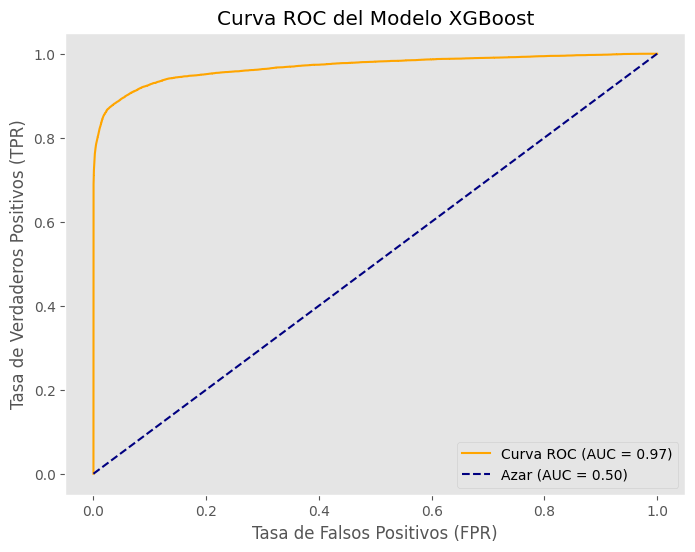

In [65]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xg)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_xg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo XGBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()

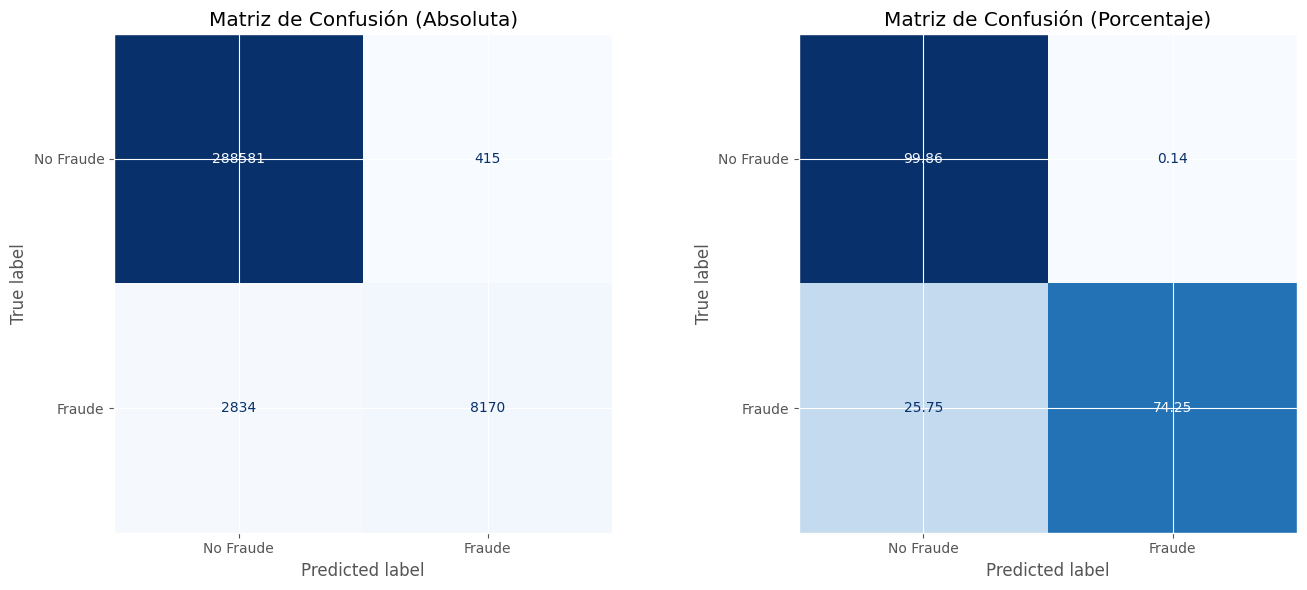

In [66]:
# Matriz de Confusión 
cm_absolute = confusion_matrix(y_test, y_pred_xg)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Validación Cruzada

In [137]:

kf = KFold(n_splits=5, shuffle=True, random_state=123)
auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

cv_scores = cross_val_score(pipeline_xgboost, X_train, y_train, cv=kf, scoring=auc_roc_scorer, n_jobs=-1)

print("Resultados de la Validación Cruzada (AUC-ROC):")
print(f"Scores por fold: {cv_scores}")

print(f"AUC-ROC promedio: {cv_scores.mean():.4f}")
print(f"AUC-ROC desviación estándar: {cv_scores.std():.4f}")


Resultados de la Validación Cruzada (AUC-ROC):
Scores por fold: [0.96998387 0.96945124 0.9707269  0.97148672 0.96840811]
AUC-ROC promedio: 0.9700
AUC-ROC desviación estándar: 0.0011


XGBoost con ajuste de hiperparámetros

In [67]:
modelo_xgb = XGBClassifier(
    n_jobs=-1,                 # Usar todos los núcleos disponibles
    use_label_encoder=False,   # Evitar advertencias
    random_state=123           # Semilla para reproducibilidad
)

# Configuración de la validación cruzada estratificada
cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)

# Definición de los hiperparámetros a ajustar
parametros_xgb = {
    "n_estimators": [50, 100],     # Número de árboles
    "max_depth": [1, 2, 3, 4],     # Profundidad máxima de los árboles
    "learning_rate": [0.01, 0.1]   # Tasa de aprendizaje
}

# Configuración de GridSearchCV
grid_xgb = GridSearchCV(
    estimator=modelo_xgb,
    param_grid=parametros_xgb,
    cv=cv,
    verbose=2,  # Mostrar progreso del ajuste
    n_jobs=-1,  # Paralelizar en todos los núcleos disponibles
    scoring='f1'  # Métrica utilizada para optimizar
)

grid_xgb.fit(X_train2, y_train2)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_ty...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=123, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [1, 2, 3, 4], 'n_estimators': [50, 100]},
             scoring='f1', verbose=2)

In [68]:
print("Mejores Hiperparámetros:", grid_xgb.best_params_)

Mejores Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [69]:
# Predicción en el conjunto de prueba
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test2)
y_pred_proba_xgb = grid_xgb.best_estimator_.predict_proba(X_test2)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test2, y_pred_xgb, target_names=["No Fraude", "Fraude"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.98      1.00      0.99    288996
      Fraude       0.97      0.36      0.52     11004

    accuracy                           0.98    300000
   macro avg       0.97      0.68      0.75    300000
weighted avg       0.98      0.98      0.97    300000



In [70]:
 #Métricas de evaluación
recall_xgb = recall_score(y_test2, y_pred_xgb)
precision_xgb = precision_score(y_test2, y_pred_xgb)
f1_xgb = f1_score(y_test2, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test2, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test2, y_pred_proba_xgb)

print("\nMétricas de Evaluación del Modelo XGBoost:")
print(f"Recall: {recall_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")


Métricas de Evaluación del Modelo XGBoost:
Recall: 0.3562
Precision: 0.9691
F1 Score: 0.5210
Accuracy: 0.9760
ROC AUC: 0.9144


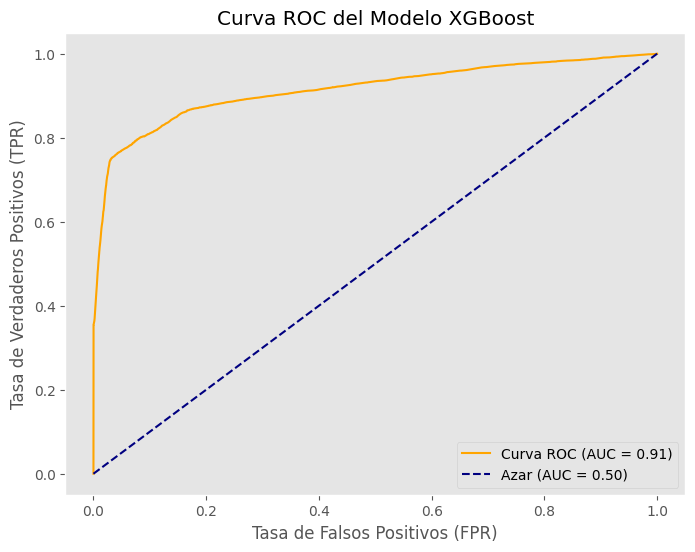

In [71]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo XGBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()

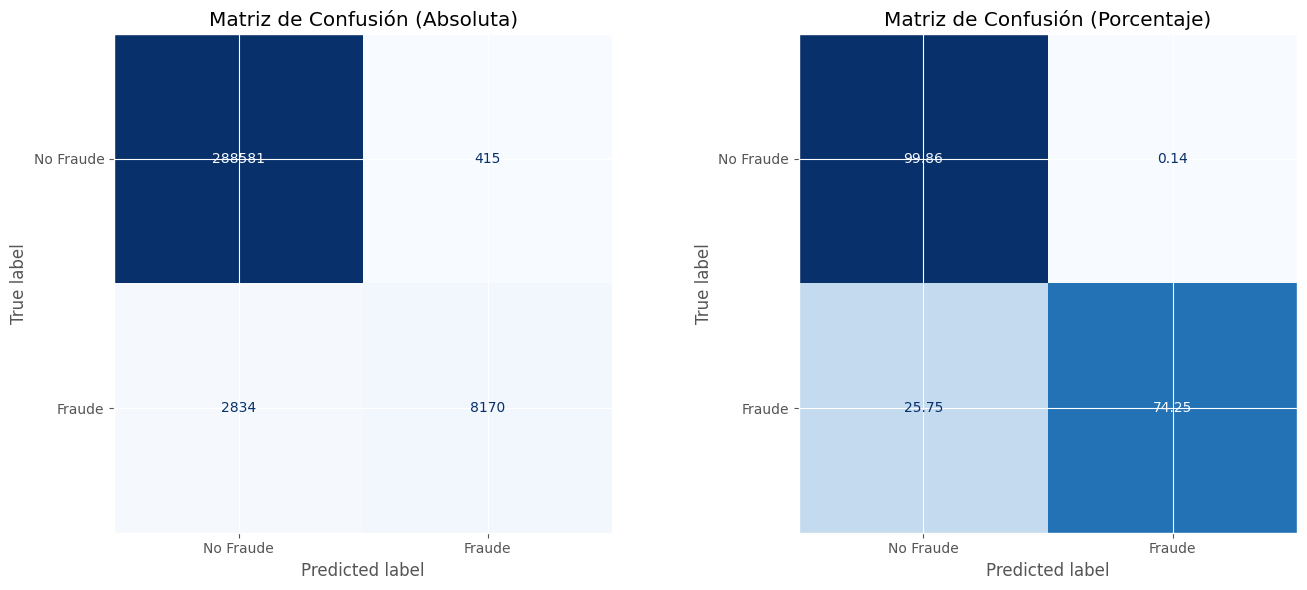

In [72]:
# Crear una figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Gradient Boosting

In [73]:
modelo_gb = GradientBoostingClassifier(random_state=1234)

pipeline_gb = Pipeline([
    ('preprocesamiento', preprocesador),  
    ('modelo', modelo_gb)                
])

pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFEF621790>)])),
                ('modelo', GradientBoostingClassifier(random_state=1234))])

In [74]:
# Predicciones
y_pred_gb = pipeline_gb.predict(X_test)
y_pred_proba_gb = pipeline_gb.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_gb, target_names=["No Fraude", "Fraude"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      1.00      0.99    288996
      Fraude       0.95      0.74      0.83     11004

    accuracy                           0.99    300000
   macro avg       0.97      0.87      0.91    300000
weighted avg       0.99      0.99      0.99    300000



In [75]:
# Métricas de evaluación
recall_gb = recall_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print("\nMétricas de Evaluación del Modelo Gradient Boosting:")
print(f"Recall: {recall_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"ROC AUC: {roc_auc_gb:.4f}")


Métricas de Evaluación del Modelo Gradient Boosting:
Recall: 0.7437
Precision: 0.9500
F1 Score: 0.8343
Accuracy: 0.9892
ROC AUC: 0.9654


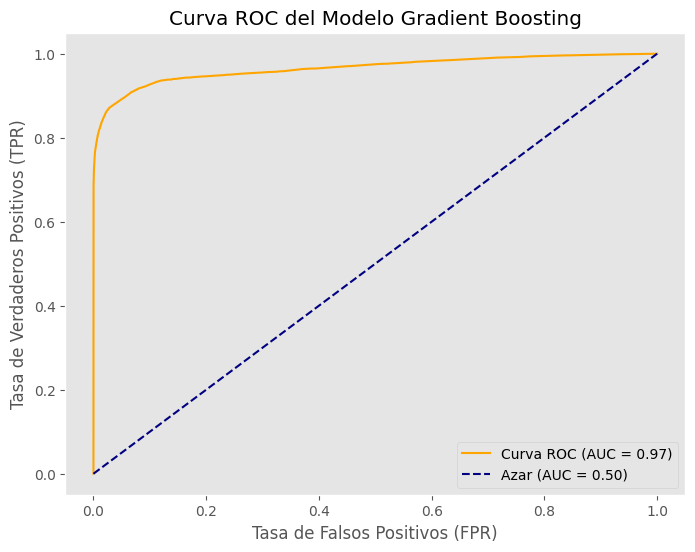

In [76]:

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo Gradient Boosting')
plt.legend(loc="lower right")
plt.grid()
plt.show()

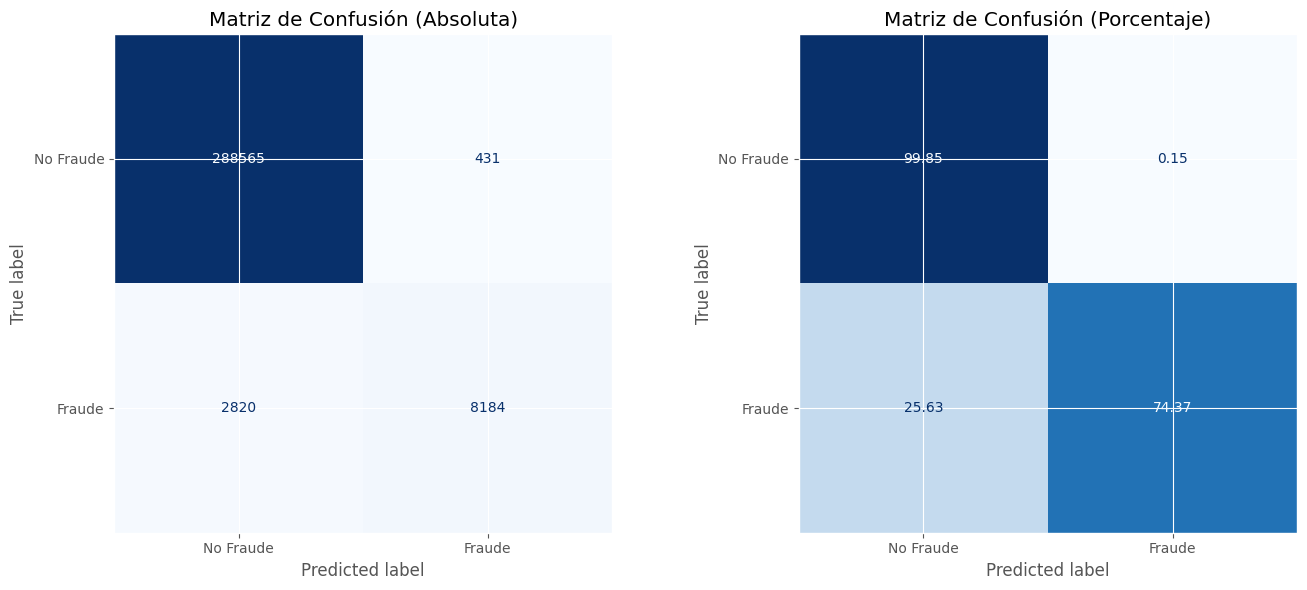

In [77]:
# Matriz de Confusión Absoluta y Porcentual
cm_absolute = confusion_matrix(y_test, y_pred_gb)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

AdaBoost

In [78]:
modelo_ada = AdaBoostClassifier(random_state=1234)

pipeline_ada = Pipeline([
    ('preprocesamiento', preprocesador),  
    ('modelo', modelo_ada)               
])

pipeline_ada.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFEF621790>)])),
                ('modelo', AdaBoostClassifier(random_state=1234))])

In [79]:
# Predicciones
y_pred_ada = pipeline_ada.predict(X_test)
y_pred_proba_ada = pipeline_ada.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_ada, target_names=["No Fraude", "Fraude"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      1.00      0.99    288996
      Fraude       0.97      0.71      0.82     11004

    accuracy                           0.99    300000
   macro avg       0.98      0.86      0.91    300000
weighted avg       0.99      0.99      0.99    300000



In [80]:
# Métricas de evaluación
recall_ada = recall_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
roc_auc_ada = roc_auc_score(y_test, y_pred_proba_ada)

print("\nMétricas de Evaluación del Modelo AdaBoost:")
print(f"Recall: {recall_ada:.4f}")
print(f"Precision: {precision_ada:.4f}")
print(f"F1 Score: {f1_ada:.4f}")
print(f"Accuracy: {accuracy_ada:.4f}")
print(f"ROC AUC: {roc_auc_ada:.4f}")


Métricas de Evaluación del Modelo AdaBoost:
Recall: 0.7125
Precision: 0.9677
F1 Score: 0.8207
Accuracy: 0.9886
ROC AUC: 0.9640


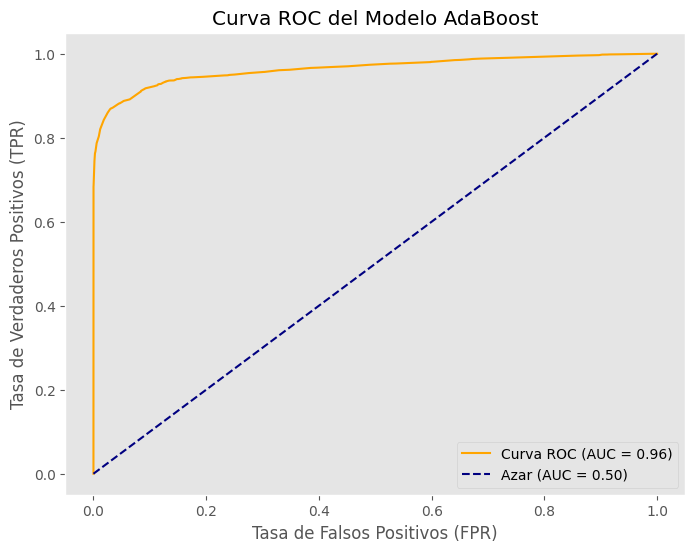

In [81]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_ada)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo AdaBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()

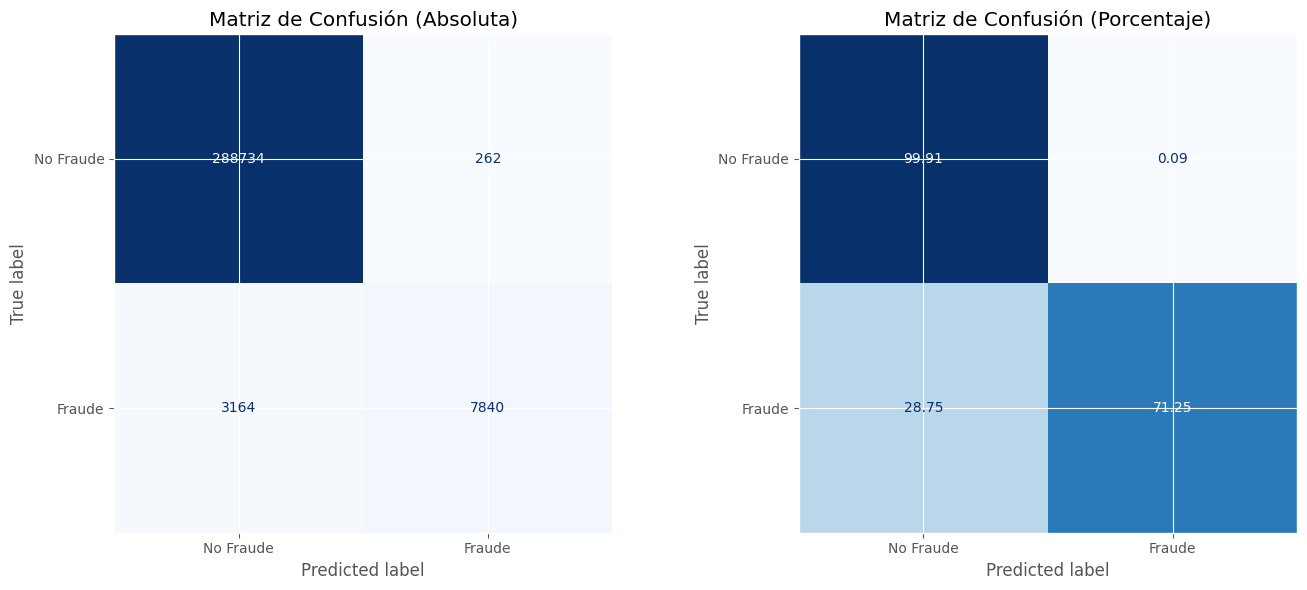

In [82]:
# Matriz de Confusión Absoluta y Porcentual
cm_absolute = confusion_matrix(y_test, y_pred_ada)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Random Forest

In [83]:
modelo_rf = RandomForestClassifier(random_state=1234)

pipeline_rf = Pipeline([
    ('preprocessing', preprocesador),
    ('modelo', modelo_rf)
])

pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFEF621790>)])),
                ('modelo', RandomForestClassifier(random_state=1234))])

In [84]:
# Predicciones del modelo
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]


print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=["Clase 0 (No Fraude)", "Clase 1 (Fraude)"]))

Reporte de Clasificación:
                     precision    recall  f1-score   support

Clase 0 (No Fraude)       0.99      1.00      0.99    288996
   Clase 1 (Fraude)       0.93      0.74      0.82     11004

           accuracy                           0.99    300000
          macro avg       0.96      0.87      0.91    300000
       weighted avg       0.99      0.99      0.99    300000



In [85]:
# Métricas de evaluación
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("\nMétricas de Evaluación:")
print(f"Recall: {recall_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")


Métricas de Evaluación:
Recall: 0.7380
Precision: 0.9306
F1 Score: 0.8232
Accuracy: 0.9884
ROC AUC: 0.9404


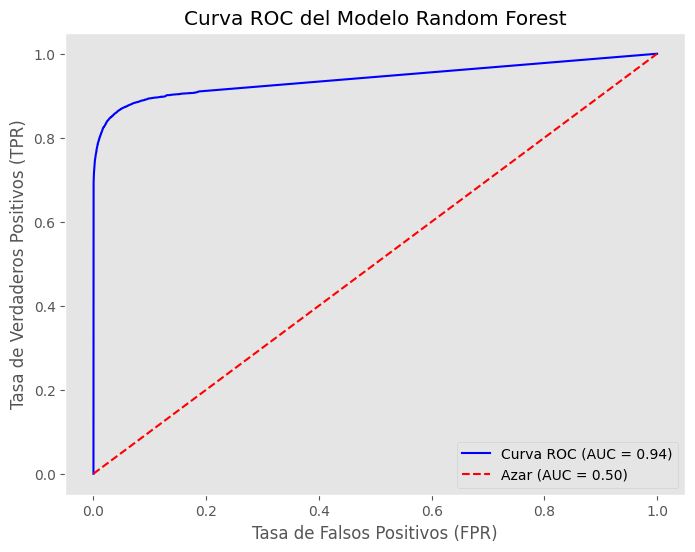

In [86]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()


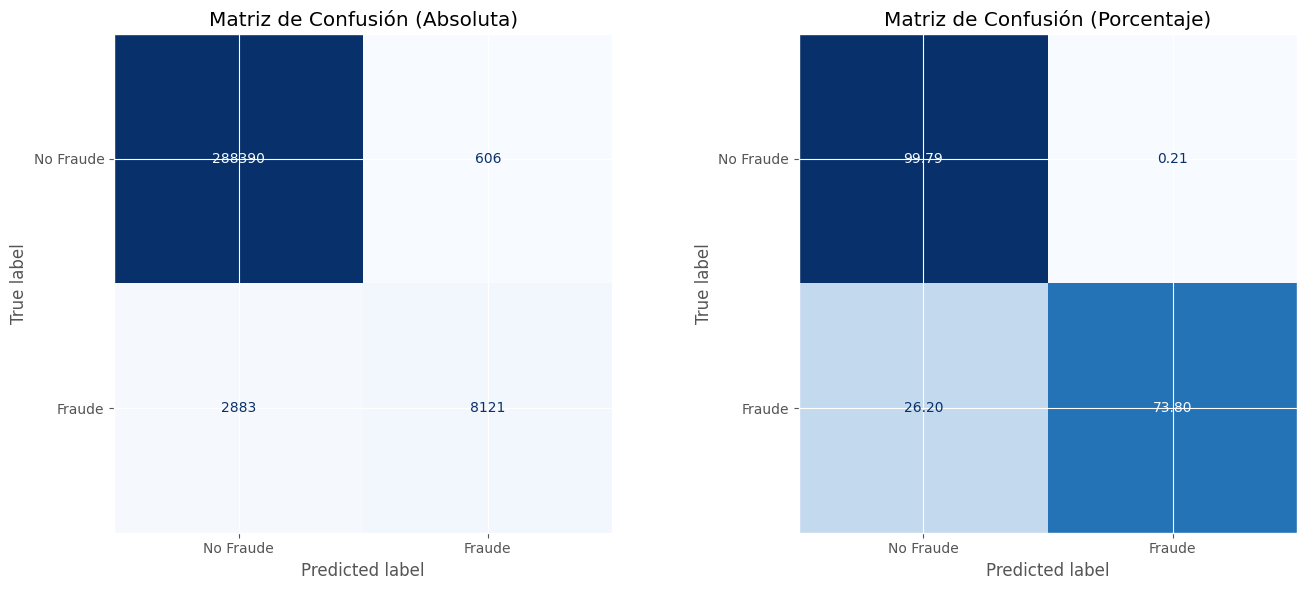

In [87]:

# Matriz de Confusión
cm_absolute = confusion_matrix(y_test, y_pred_rf)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Random Forest con class_weight='balanced_subsample

In [88]:
modelo_rf2 = RandomForestClassifier(
    class_weight='balanced_subsample',  # Ajusta los pesos de las clases
    random_state=87,                  # Semilla para reproducibilidad
    n_estimators=100,                   # Número de árboles en el bosque
    max_depth=None,                     # Profundidad máxima de los árboles
    min_samples_split=2,                # Mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=1                  # Mínimo de muestras requeridas en una hoja
)

pipeline_rf2 = Pipeline([
    ('preprocesador', preprocesador),  
    ('modelo', modelo_rf2)      
])

pipeline_rf2.fit(X_train, y_train)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFEF621790>)])),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        random_state=87))])

In [89]:
# Predicciones del modelo
y_pred_rf2 = pipeline_rf2.predict(X_test)
y_pred_proba_rf2 = pipeline_rf2.predict_proba(X_test)[:, 1]

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_rf2, target_names=["No Fraude", "Fraude"]))

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      0.97      0.98    288996
      Fraude       0.54      0.82      0.65     11004

    accuracy                           0.97    300000
   macro avg       0.76      0.89      0.81    300000
weighted avg       0.98      0.97      0.97    300000



In [90]:
# Métricas de evaluación
recall_rf2 = recall_score(y_test, y_pred_rf2)
precision_rf2 = precision_score(y_test, y_pred_rf2)
f1_rf2= f1_score(y_test, y_pred_rf2)
accuracy_rf2 = accuracy_score(y_test, y_pred_rf2)
roc_auc_rf2 = roc_auc_score(y_test, y_pred_proba_rf2)

print("\nMétricas de Evaluación del Modelo Random Forest Personalizado:")
print(f"Recall: {recall_rf2:.4f}")
print(f"Precision: {precision_rf2:.4f}")
print(f"F1 Score: {f1_rf2:.4f}")
print(f"Accuracy: {accuracy_rf2:.4f}")
print(f"ROC AUC: {roc_auc_rf2:.4f}")





Métricas de Evaluación del Modelo Random Forest Personalizado:
Recall: 0.8153
Precision: 0.5356
F1 Score: 0.6465
Accuracy: 0.9673
ROC AUC: 0.9362


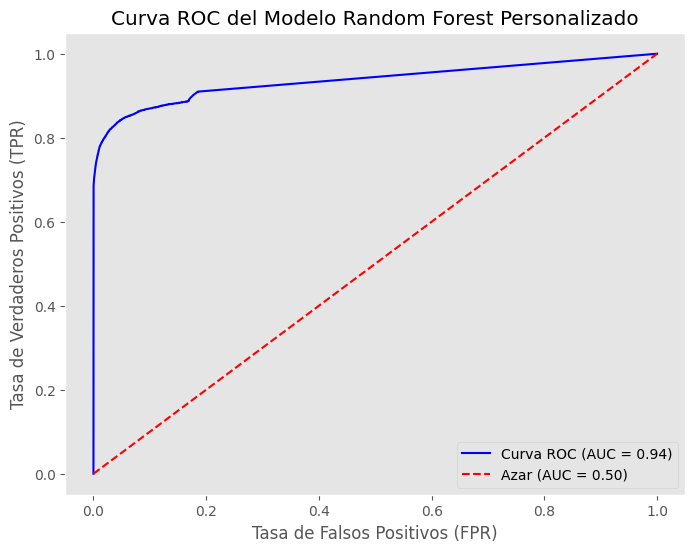

In [91]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo Random Forest Personalizado')
plt.legend(loc="lower right")
plt.grid()
plt.show()

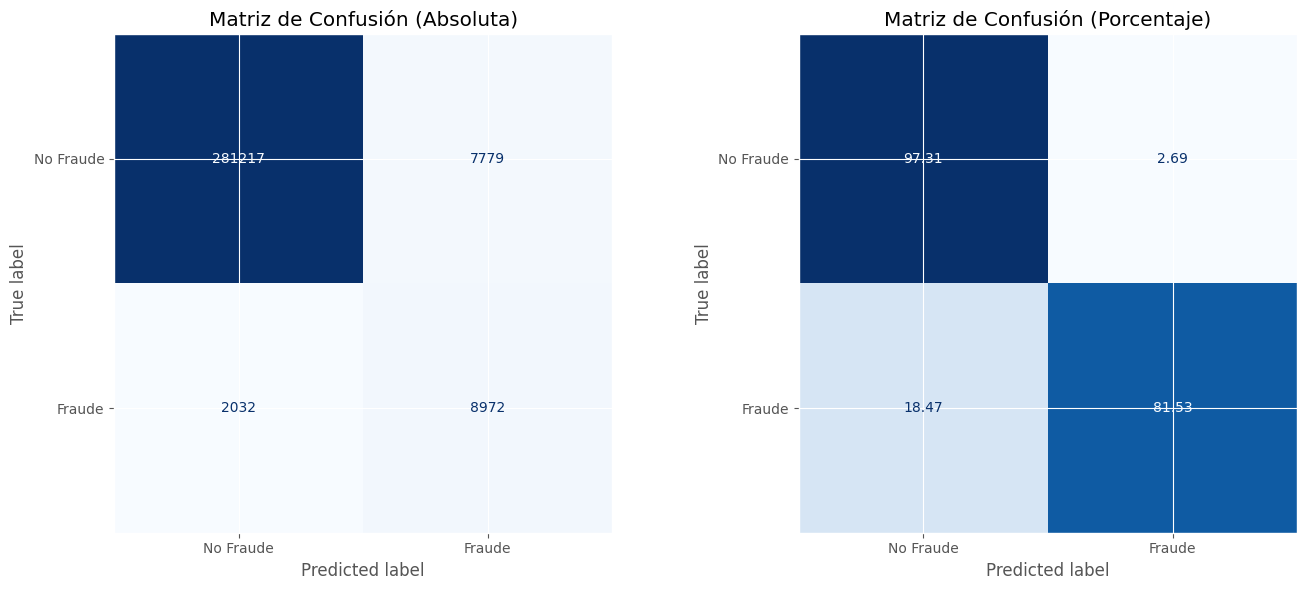

In [92]:
# Matriz de Confusión
cm_absolute = confusion_matrix(y_test, y_pred_rf2)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Decision Tree Classifier

In [93]:
modelo_dt = DecisionTreeClassifier(random_state=1234)

pipeline_dt = Pipeline([
    ('preprocesamiento', preprocesador), 
    ('modelo', modelo_dt)                
])

pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFEF621790>)])),
                ('modelo', DecisionTreeClassifier(random_state=1234))])

In [94]:
# Predicciones
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_proba_dt = pipeline_dt.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_dt, target_names=["No Fraude", "Fraude"]))



Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      1.00      0.99    288996
      Fraude       0.91      0.73      0.81     11004

    accuracy                           0.99    300000
   macro avg       0.95      0.87      0.90    300000
weighted avg       0.99      0.99      0.99    300000



In [95]:
# Métricas de evaluación
recall_dt = recall_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print("\nMétricas de Evaluación del Modelo Decision Tree:")
print(f"Recall: {recall_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"ROC AUC: {roc_auc_dt:.4f}")


Métricas de Evaluación del Modelo Decision Tree:
Recall: 0.7331
Precision: 0.9141
F1 Score: 0.8137
Accuracy: 0.9877
ROC AUC: 0.9132


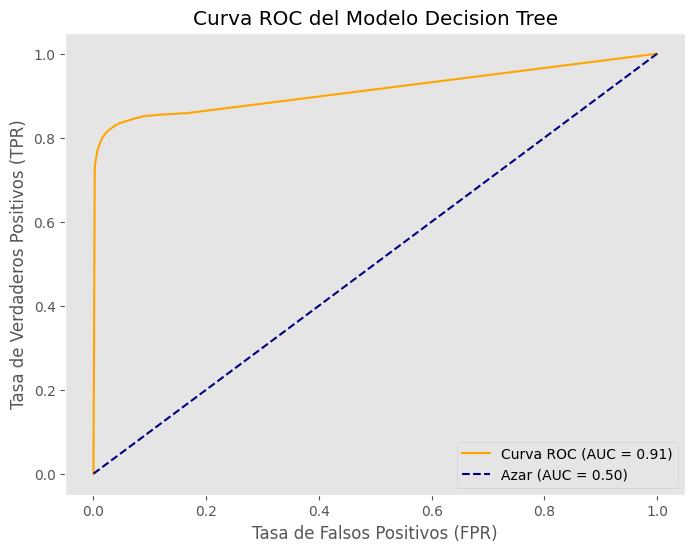

In [96]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo Decision Tree')
plt.legend(loc="lower right")
plt.grid()
plt.show()

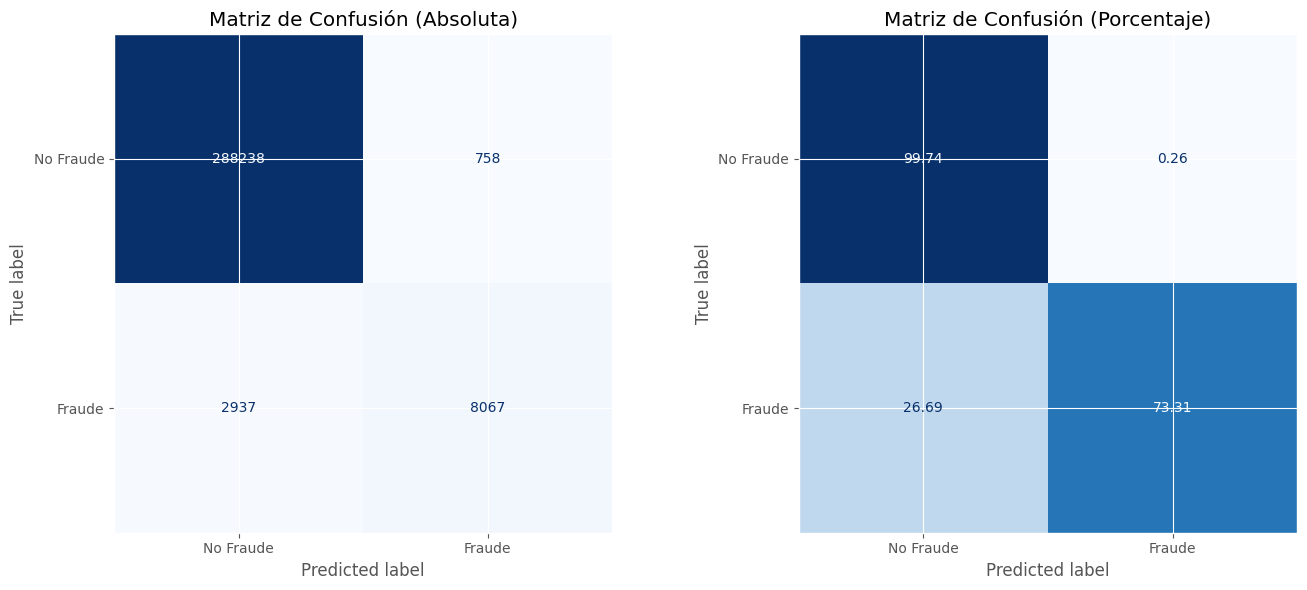

In [97]:
# Matriz de Confusión Absoluta y Porcentual
cm_absolute = confusion_matrix(y_test, y_pred_dt)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Regresión logística con seleccion de variables

Se utilizó el método RFECV con validación cruzada para identificar las variables que optimizan el modelo según el F1-Score. 

In [98]:

from sklearn.feature_selection import RFECV

modelo_rl = LogisticRegression(random_state=87)

cv = KFold(n_splits=3, shuffle=True, random_state=87)

selector = RFECV(estimator=modelo_rl, step=1, cv=cv, scoring='f1', verbose=2)

selector.fit(X_train2, y_train2)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFECV(cv=KFold(n_splits=3, random_state=87, shuffle=True),
      estimator=LogisticRegression(random_state=87), scoring='f1', verbose=2)

In [99]:
# Variables seleccionadas
print("\nNúmero de características seleccionadas:", selector.n_features_)
print("Características seleccionadas:", selector.support_)


Número de características seleccionadas: 1
Características seleccionadas: [False  True False False False False False]


In [100]:
# Predicciones con las variables seleccionadas
y_pred_rl = selector.predict(X_test2)
y_pred_proba_rl = selector.predict_proba(X_test2)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test2, y_pred_rl, target_names=["No Fraude", "Fraude"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      1.00      0.99    288996
      Fraude       1.00      0.68      0.81     11004

    accuracy                           0.99    300000
   macro avg       0.99      0.84      0.90    300000
weighted avg       0.99      0.99      0.99    300000



In [101]:
# Métricas de evaluación
recall_rl = recall_score(y_test2, y_pred_rl)
precision_rl = precision_score(y_test2, y_pred_rl)
f1_rl = f1_score(y_test2, y_pred_rl)
accuracy_rl = accuracy_score(y_test2, y_pred_rl)
roc_auc_rl = roc_auc_score(y_test2, y_pred_proba_rl)

print("\nMétricas de Evaluación del Modelo de Regresión Logística:")
print(f"Recall: {recall_rl:.4f}")
print(f"Precision: {precision_rl:.4f}")
print(f"F1 Score: {f1_rl:.4f}")
print(f"Accuracy: {accuracy_rl:.4f}")
print(f"ROC AUC: {roc_auc_rl:.4f}")


Métricas de Evaluación del Modelo de Regresión Logística:
Recall: 0.6763
Precision: 1.0000
F1 Score: 0.8069
Accuracy: 0.9881
ROC AUC: 0.8381


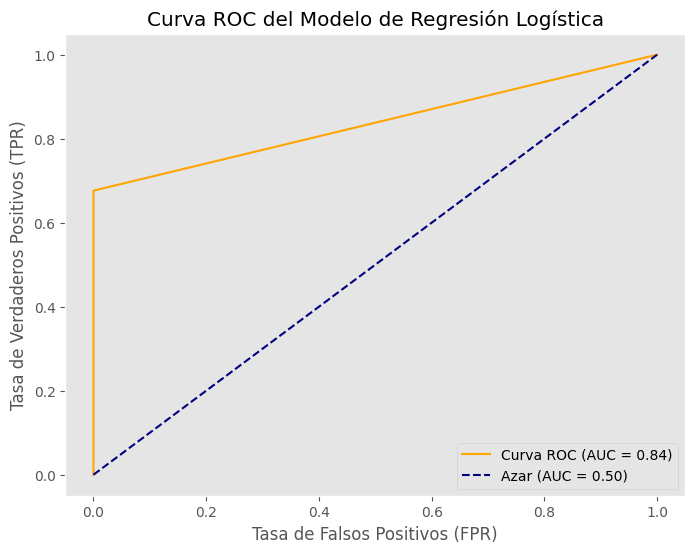

In [102]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_proba_rl)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_rl:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo de Regresión Logística')
plt.legend(loc="lower right")
plt.grid()
plt.show()

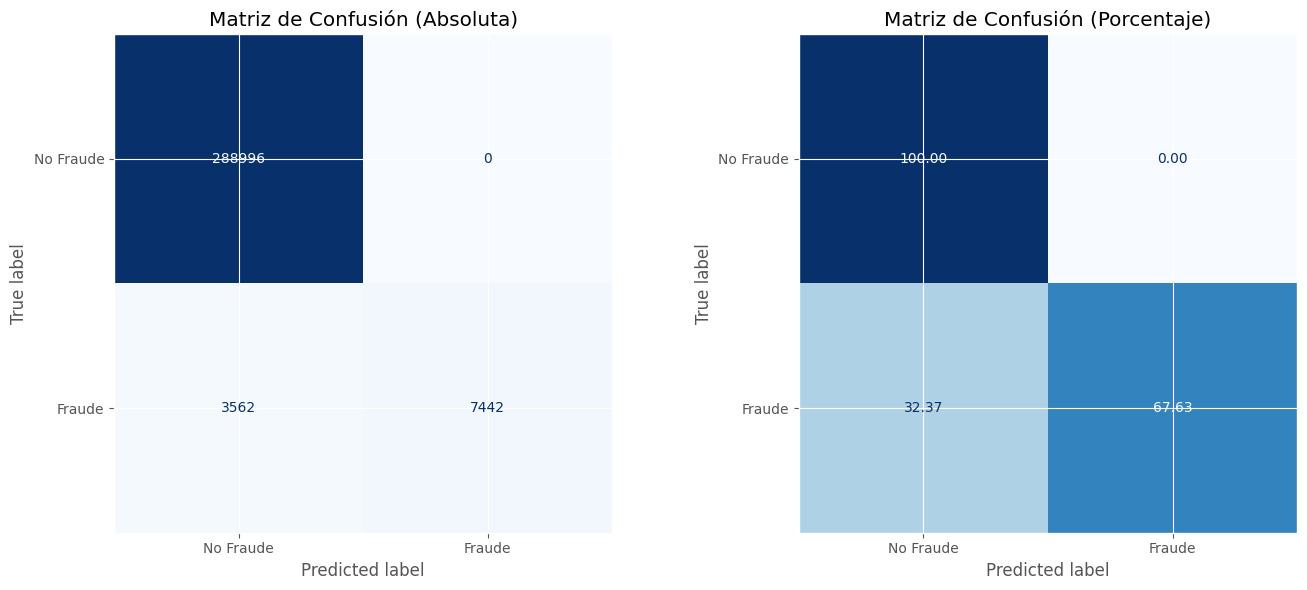

In [103]:
# Matriz de Confusión Absoluta y Porcentual
cm_absolute = confusion_matrix(y_test2, y_pred_rl)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

Regresión Logística con Class Weighting (solución al desbalanceo)

Se ajustaron los pesos de las clases para abordar el desbalanceo, asignando mayor importancia a la clase minoritaria, mejorando el equilibrio entre precisión y recall en el modelo.

In [104]:

# Modelo de regresión logística con ajustes
modelo_cw = LogisticRegressionCV(class_weight='balanced', random_state=1234, cv=5, scoring='f1')

pipeline_cw = Pipeline([
    ('preprocessing', preprocesador), 
    ('modelo', modelo_cw)
])

pipeline_cw.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericas',
                                                  Pipeline(steps=[('escalador',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF567CB050>),
                                                 ('categoricas',
                                                  Pipeline(steps=[('codificador_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFEF621790>)])),
                ('modelo',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      random_state=1234, scoring='f1'))])

In [105]:

# Predicciones en el conjunto de prueba
y_pred_cw = pipeline_cw.predict(X_test)
y_pred_proba_cw = pipeline_cw.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_cw, target_names=["No Fraude", "Fraude"]))




Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      0.91      0.95    288996
      Fraude       0.25      0.82      0.38     11004

    accuracy                           0.90    300000
   macro avg       0.62      0.86      0.67    300000
weighted avg       0.97      0.90      0.93    300000



In [106]:
# Métricas de evaluación
recall_cw = recall_score(y_test, y_pred_cw)
precision_cw = precision_score(y_test, y_pred_cw)
f1_cw = f1_score(y_test, y_pred_cw)
accuracy_cw = accuracy_score(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_pred_proba_cw)

print("\nMétricas de Evaluación del Modelo LogisticRegression con Class Weighting:")
print(f"Recall: {recall_cw:.4f}")
print(f"Precision: {precision_cw:.4f}")
print(f"F1 Score: {f1_cw:.4f}")
print(f"Accuracy: {accuracy_cw:.4f}")
print(f"ROC AUC: {roc_auc_cw:.4f}")


Métricas de Evaluación del Modelo LogisticRegression con Class Weighting:
Recall: 0.8234
Precision: 0.2496
F1 Score: 0.3831
Accuracy: 0.9027
ROC AUC: 0.9386


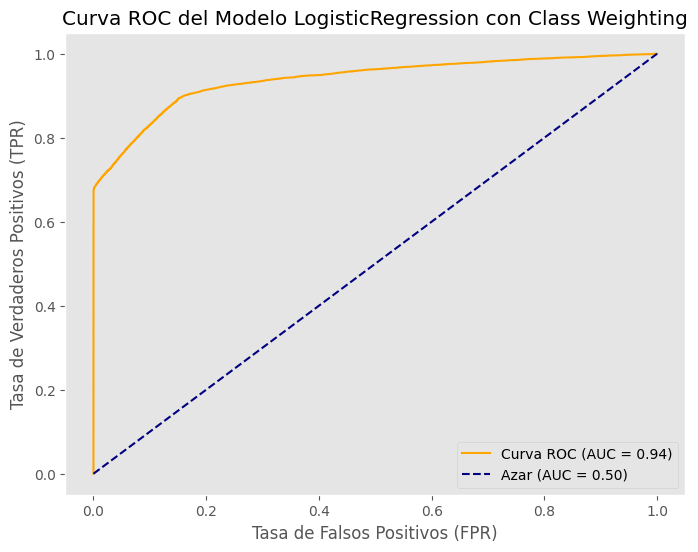

In [107]:

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_cw)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_cw:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo LogisticRegression con Class Weighting')
plt.legend(loc="lower right")
plt.grid()
plt.show()

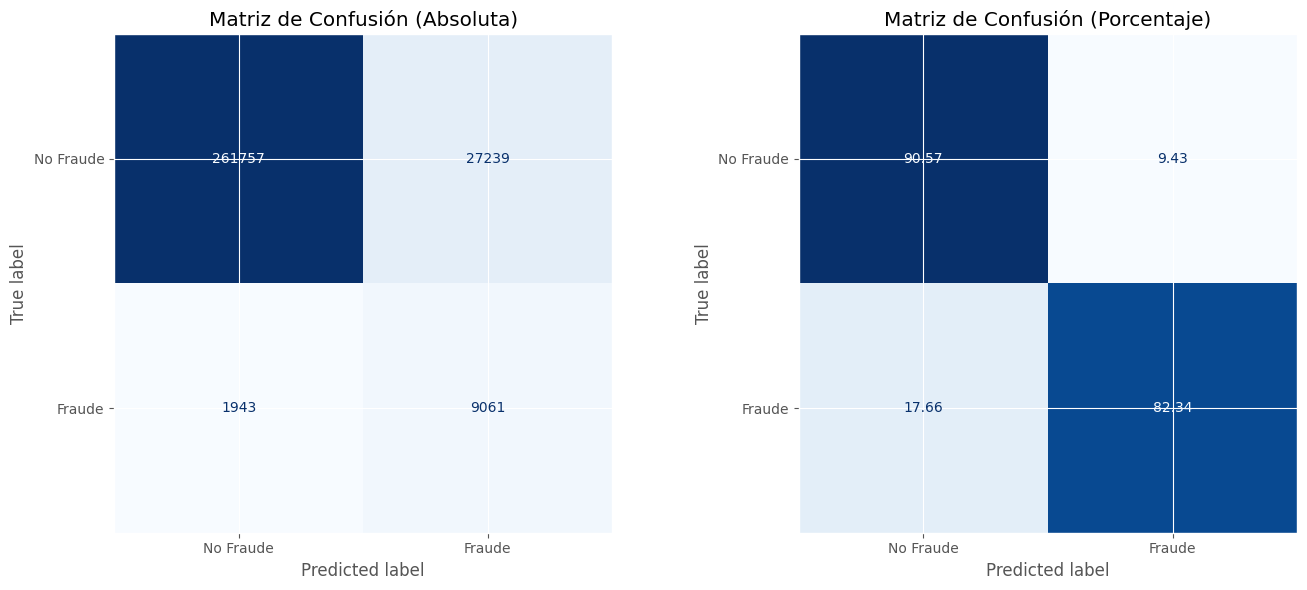

In [108]:
# Matriz de Confusión 
cm_absolute = confusion_matrix(y_test, y_pred_cw)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

In [111]:
from sklearn.ensemble import HistGradientBoostingClassifier
modelo_hgb = HistGradientBoostingClassifier(random_state=1234)

# Entrenar el modelo con los datos de entrenamiento
modelo_hgb.fit(X_train2, y_train2)

HistGradientBoostingClassifier(random_state=1234)

In [112]:
# Predicciones
y_pred_hgb = modelo_hgb.predict(X_test2)
y_pred_proba_hgb = modelo_hgb.predict_proba(X_test2)[:, 1]

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test2, y_pred_hgb, target_names=["No Fraude", "Fraude"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      1.00      0.99    288996
      Fraude       1.00      0.68      0.81     11004

    accuracy                           0.99    300000
   macro avg       0.99      0.84      0.90    300000
weighted avg       0.99      0.99      0.99    300000



In [113]:
# Métricas de evaluación
recall_hgb = recall_score(y_test2, y_pred_hgb)
precision_hgb = precision_score(y_test2, y_pred_hgb)
f1_hgb = f1_score(y_test2, y_pred_hgb)
accuracy_hgb = accuracy_score(y_test2, y_pred_hgb)
roc_auc_hgb = roc_auc_score(y_test2, y_pred_proba_hgb)

print("\nMétricas de Evaluación del Modelo HistGradientBoostingClassifier:")
print(f"Recall: {recall_hgb:.4f}")
print(f"Precision: {precision_hgb:.4f}")
print(f"F1 Score: {f1_hgb:.4f}")
print(f"Accuracy: {accuracy_hgb:.4f}")
print(f"ROC AUC: {roc_auc_hgb:.4f}")


Métricas de Evaluación del Modelo HistGradientBoostingClassifier:
Recall: 0.6788
Precision: 0.9971
F1 Score: 0.8077
Accuracy: 0.9881
ROC AUC: 0.9697


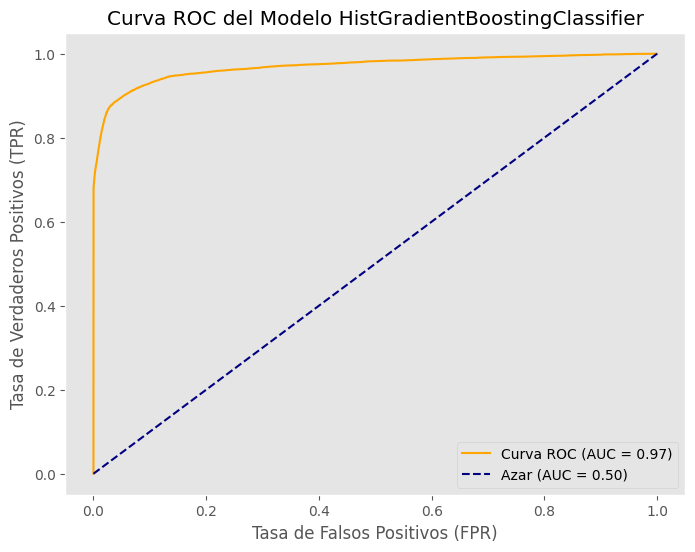

In [114]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_proba_hgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc_hgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo HistGradientBoostingClassifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

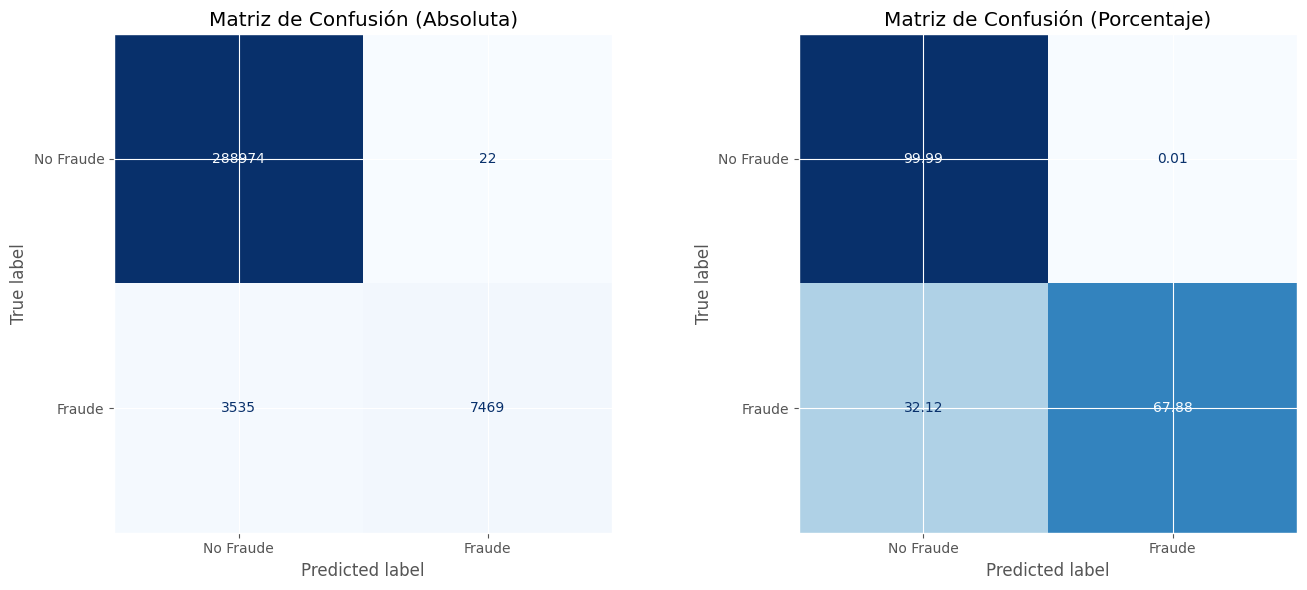

In [115]:
# Matriz de Confusión Absoluta y Porcentual
cm_absolute = confusion_matrix(y_test2, y_pred_hgb)
cm_percentage = cm_absolute.astype('float') / cm_absolute.sum(axis=1)[:, np.newaxis] * 100

# Crear una figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz absoluta
cmd_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=["No Fraude", "Fraude"])
cmd_absolute.plot(cmap='Blues', values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión (Absoluta)")

# Matriz porcentual
cmd_percentage = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["No Fraude", "Fraude"])
cmd_percentage.plot(cmap='Blues', values_format='.2f', ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión (Porcentaje)")

plt.tight_layout()
plt.show()

# Paso 3.1  Trazar el flujo de datos y explicar bajo cuál criterio seleccionó el modelo final.

Para evaluar los modelos entrenados en este ejercicio, se consideraron varias métricas relevantes. De estas, se priorizaron las siguientes debido a su relevancia para los objetivos de clasificación en un conjunto de datos desbalanceado:

1. F1 Score

El F1 Score combina precisión y sensibilidad en una única métrica, siendo especialmente útil en escenarios donde las clases están desbalanceadas. Dado que nuestro conjunto de datos tiene una distribución desbalanceada entre las clases, el F1 Score fue una métrica clave en este análisis, ya que refleja mejor el rendimiento del modelo en este contexto.

2. Curva ROC y Área bajo la Curva (AUC)

La curva ROC evalúa la capacidad del modelo para distinguir entre clases positivas y negativas en diferentes umbrales. El área bajo esta curva (AUC) mide la calidad general del modelo de clasificación. Un AUC más alto indica que el modelo tiene un mejor rendimiento. Esta métrica es crucial porque permite identificar qué tan lejos está la curva ROC de la línea diagonal (y = x), lo que se traduce en un modelo más confiable.

# Modelo Seleccionado

En base a las métricas evaluadas, el modelo seleccionado fue XGBoost, ya que mostró el mejor equilibrio entre F1 Score y ROC-AUC, lo que indica un rendimiento sólido tanto en términos de clasificación general como en la capacidad para diferenciar entre clases en un escenario desbalanceado.

Aunque se analizaron otras métricas como Recall y Precision, estas dos métricas seleccionadas fueron las más relevantes para el contexto del problema.

In [109]:
# Comparar modelos
compare_models = ['Logistic Regression', 'Logistic Regression class_weight','Random Forest', 'Random Forest class_weight', 'Gradient Boosting', 'XGBoost', 'XGBoost parametros', 'AdaBoost', 'Decision Tree']

# Crear un diccionario con los resultados de los modelos
data = {
    'Accuracy': [accuracy_rl,accuracy_cw, accuracy_rf, accuracy_rf2, accuracy_gb,  accuracy_xg, accuracy_xgb, accuracy_ada, accuracy_dt],
    'Recall': [recall_rl, accuracy_cw, recall_rf, recall_rf2, recall_gb, recall_xg, recall_xgb, recall_ada, recall_dt],
    'Precision': [precision_rl, accuracy_cw, precision_rf, precision_rf2, precision_gb, precision_xg, precision_xgb, precision_ada, precision_dt],
    'f1_score': [f1_rl, accuracy_cw, f1_rf, f1_rf2, f1_gb, f1_xg, f1_xgb, f1_ada, f1_dt],
    'ROC_AUC': [roc_auc_rl, accuracy_cw, roc_auc_rf, roc_auc_rf2, roc_auc_gb, roc_auc_xg, roc_auc_xgb, roc_auc_ada, roc_auc_dt],
    'Description': [
        '',
        '',
        '',
        '',
        '',
        'best model',
        '',
        '',
        ''
    ]
}

# Crear un DataFrame con los resultados
result = pd.DataFrame(data=data, index=compare_models)

# Mostrar los resultados

result

Accuracy  Recall  Precision  f1_score  \
Logistic Regression                 0.9881  0.6763     1.0000    0.8069   
Logistic Regression class_weight    0.9027  0.9027     0.9027    0.9027   
Random Forest                       0.9884  0.7380     0.9306    0.8232   
Random Forest class_weight          0.9673  0.8153     0.5356    0.6465   
Gradient Boosting                   0.9892  0.7437     0.9500    0.8343   
XGBoost                             0.9892  0.7425     0.9517    0.8341   
XGBoost parametros                  0.9760  0.3562     0.9691    0.5210   
AdaBoost                            0.9886  0.7125     0.9677    0.8207   
Decision Tree                       0.9877  0.7331     0.9141    0.8137   

                                  ROC_AUC Description  
Logistic Regression                0.8381              
Logistic Regression class_weight   0.9027              
Random Forest                      0.9404              
Random Forest class_weight         0.9362              
Gradient Boosting                  0.9654              
XGBoost                            0.9688  best model  
XGBoost parametros                 0.9144              
AdaBoost                           0.9640              
Decision Tree                      0.9132


Es fundamental evitar el overfitting, conocido como sobreajuste, en el cual un modelo muestra un rendimiento excelente al trabajar con los datos de entrenamiento pero falla al generalizar con nuevos datos. Aunque en ocasiones se sacrifica algo de rendimiento en los datos de entrenamiento, este compromiso asegura un modelo más robusto y confiable en escenarios reales.

Para prevenir el overfitting y mejorar la calidad del modelo, es crucial implementar las siguientes estrategias:

Ajuste de hiperparámetros: Permite encontrar la configuración óptima del modelo.

Selección de variables: Identifica las características más relevantes y evita ruido innecesario.

Solución del desbalance de clases: Mejora la capacidad del modelo para manejar clases minoritarias.

Validación cruzada: Garantiza que el rendimiento del modelo sea consistente en diferentes subconjuntos de datos.

Aunque varios modelos presentaron valores similares en la métrica ROC-AUC, el modelo seleccionado destacó por la forma en que su curva ROC se ajustó al problema específico, mostrando un equilibrio entre las métricas de desempeño y su capacidad de generalización. Este enfoque asegura que el modelo sea efectivo no solo en el conjunto de entrenamiento, sino también en escenarios prácticos.

# Las variables más determinantes en el modelo de XGBoost.

In [170]:

import shap

def analyze_shap(pipeline_model, X_test, idx=0, dependency_feature="secuencia_transacciones"):
    modelo = pipeline_model.named_steps['modelo']
    preprocessor = pipeline_model.named_steps['preprocesamiento']

    X_test_processed = preprocessor.transform(X_test)
    
    if hasattr(preprocessor, "get_feature_names_out"):
        processed_feature_names = preprocessor.get_feature_names_out(input_features=X_test.columns)
    else:
        processed_feature_names = X_test.columns

    # Convertir X_test_processed a un DataFrame con los nombres de las columnas transformadas
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)

    explainer = shap.TreeExplainer(modelo)
    
    shap_values = explainer(X_test_processed_df)
 
    print("Generando el gráfico de resumen...")
    plt.figure(figsize=(12, 8))  # Configuración de tamaño
    shap.summary_plot(shap_values, X_test_processed_df, show=True)

    print(f"Generando el gráfico de fuerza para el índice {idx}...")
    try:
        # Ajuste necesario para TreeExplainer en modelos de clasificación binaria
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
        shap.force_plot(
            expected_value,
            shap_values[idx].values,
            X_test_processed_df.iloc[idx],
            matplotlib=True
        )
        plt.gcf().set_size_inches(12, 3)  
    except Exception as e:
        print(f"Error en Force Plot: {e}")

    print(f"Generando el gráfico de dependencia para {dependency_feature}...")
    try:
        if dependency_feature in X_test.columns:
            processed_feature = [name for name in processed_feature_names if dependency_feature in name][0]
        else:
            processed_feature = dependency_feature
        plt.figure(figsize=(20, 10))  # Configuración de tamaño
        shap.dependence_plot(processed_feature, shap_values.values, X_test_processed_df, show=True)
    except Exception as e:
        print(f"Error en Dependence Plot: {e}")

    print("Análisis SHAP completado.")


In [172]:
df3.columns

Index(['merchant_id', 'transaction_amount', 'transaction_type', 'Fraude',
       'secuencia_transacciones', 'hora', 'dia'],
      dtype='object')

Generando el gráfico de resumen...


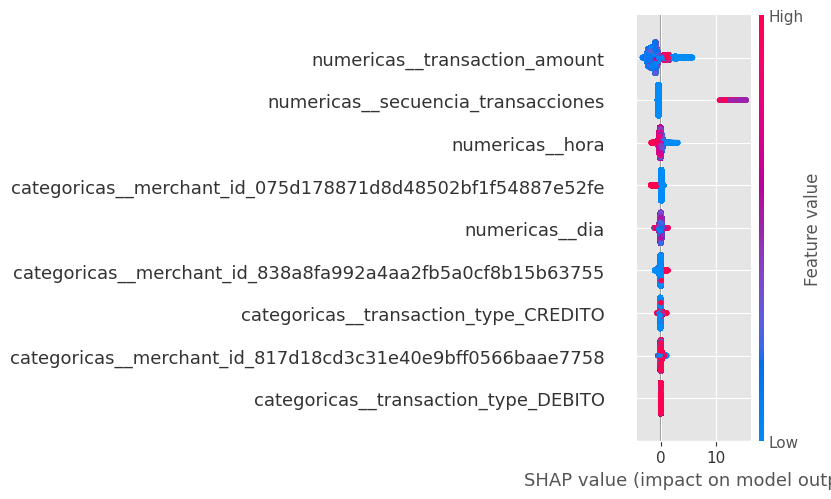

Generando el gráfico de fuerza para el índice 0...


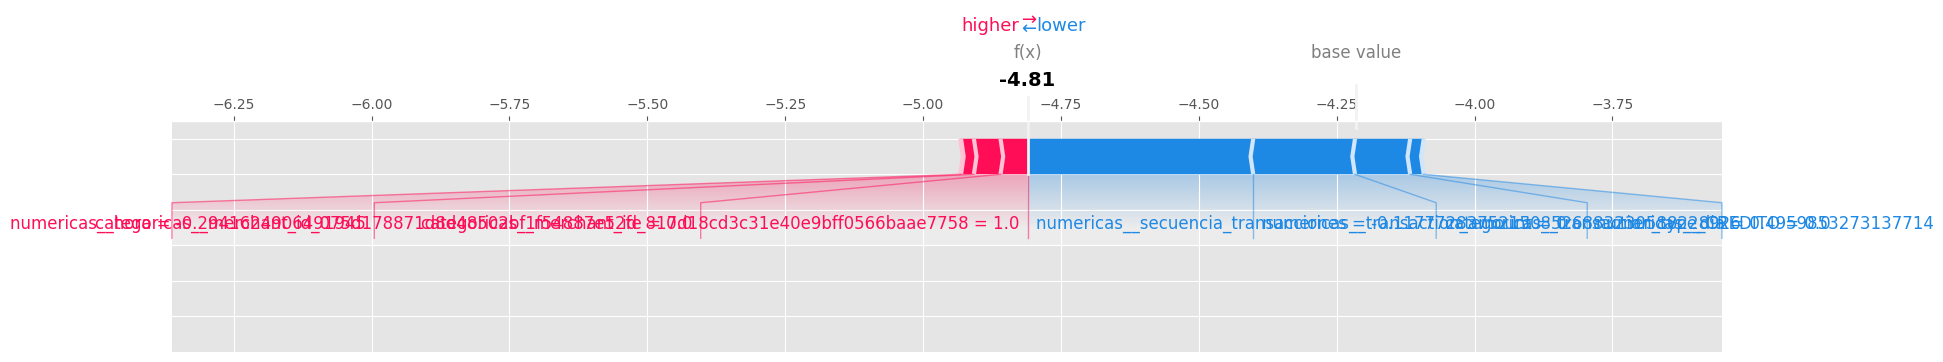

Generando el gráfico de dependencia para transaction_amount...


<Figure size 1200x300 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

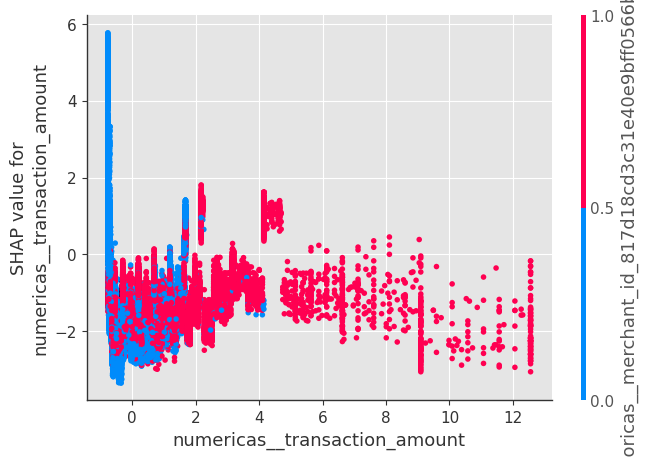

Análisis SHAP completado.


In [173]:
analyze_shap(pipeline_xgboost, X_test, idx=0, dependency_feature="transaction_amount")

In [162]:
df3.columns

Index(['merchant_id', 'transaction_amount', 'transaction_type', 'Fraude',
       'secuencia_transacciones', 'hora', 'dia'],
      dtype='object')

Generando el gráfico de resumen...


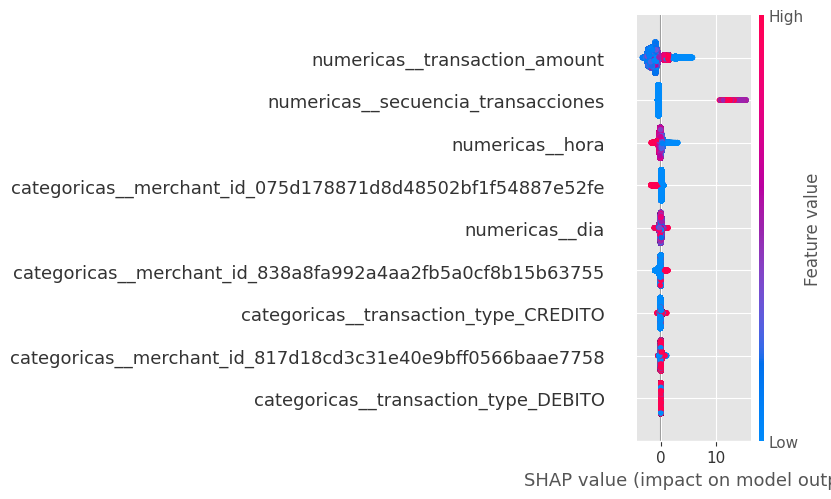

Generando el gráfico de fuerza para el índice 0...


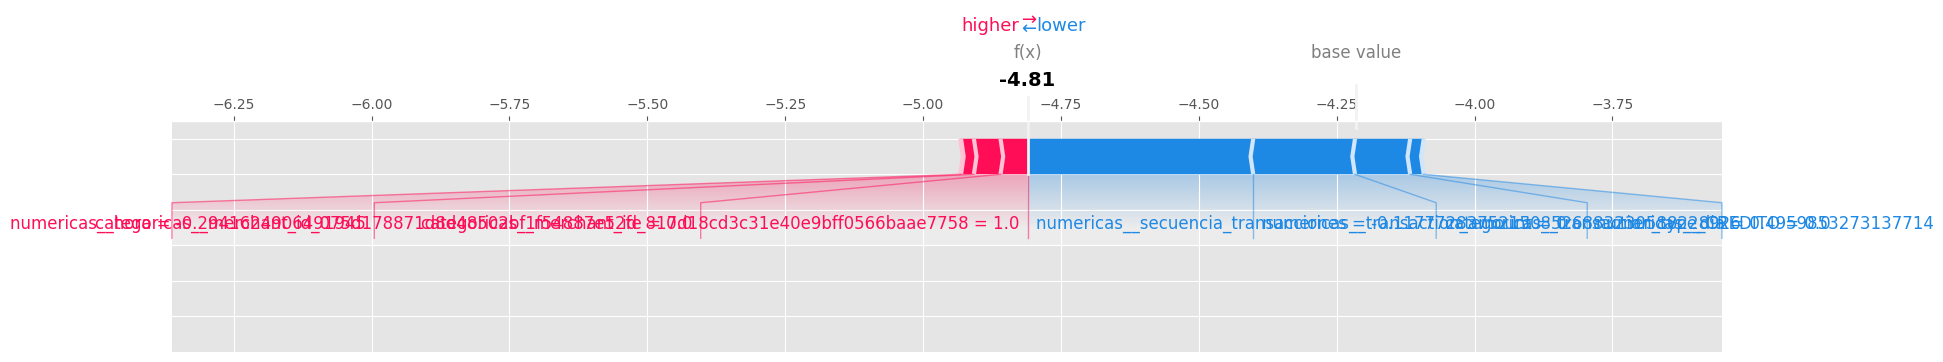

Generando el gráfico de dependencia para merchant_id...


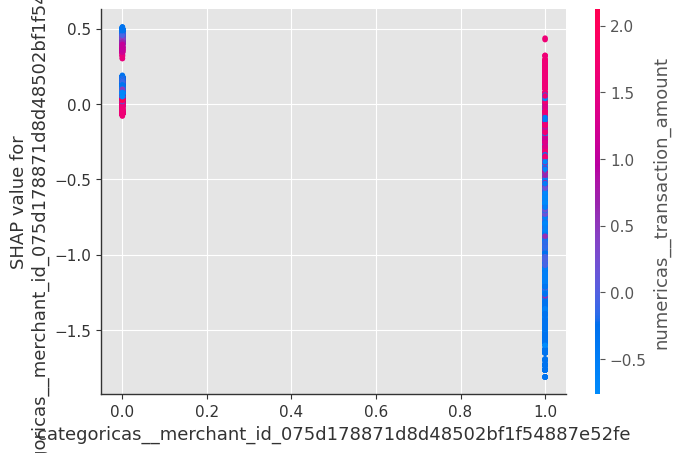

Análisis SHAP completado.


In [163]:
analyze_shap(pipeline_xgboost, X_test, idx=0, dependency_feature="merchant_id")

Generando el gráfico de resumen...


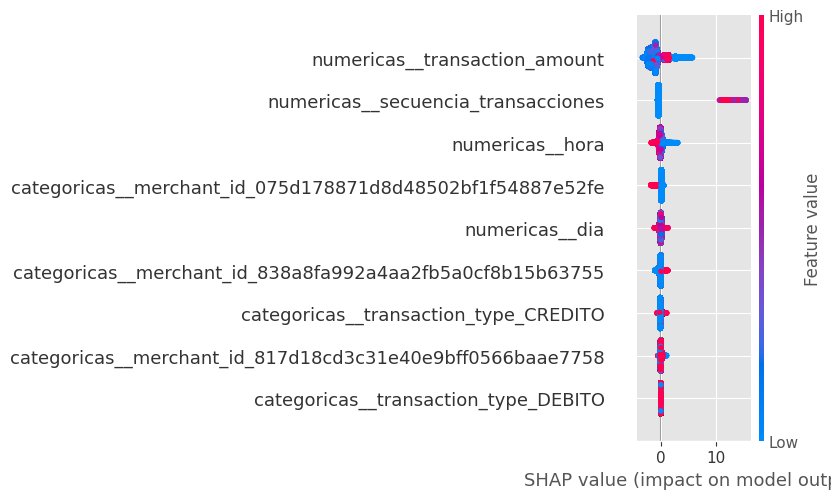

Generando el gráfico de fuerza para el índice 0...


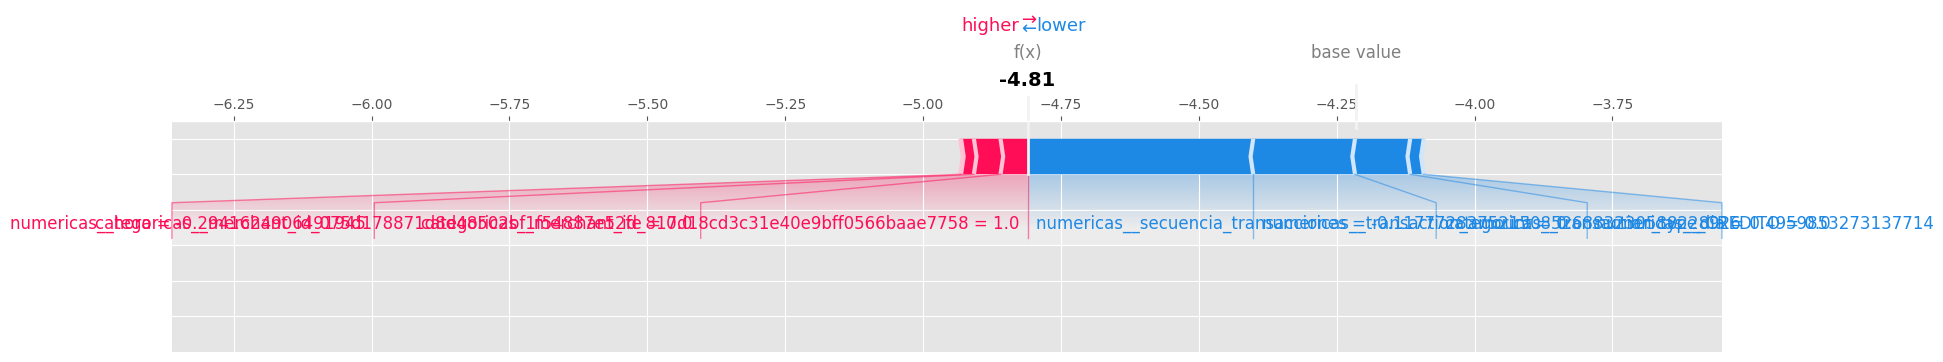

Generando el gráfico de dependencia para transaction_type...


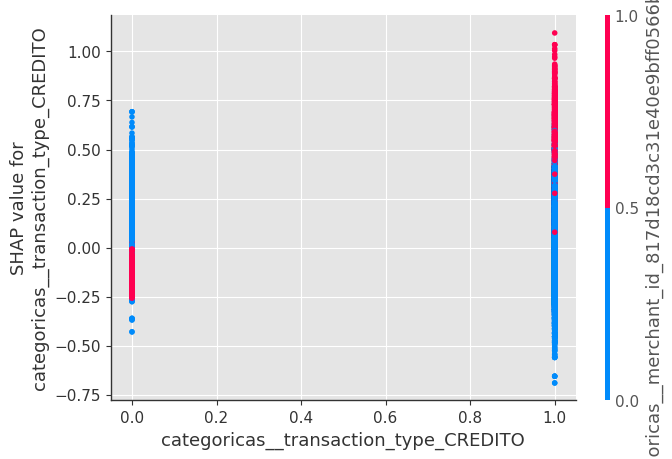

Análisis SHAP completado.


In [164]:
analyze_shap(pipeline_xgboost, X_test, idx=0, dependency_feature="transaction_type")

Generando el gráfico de resumen...


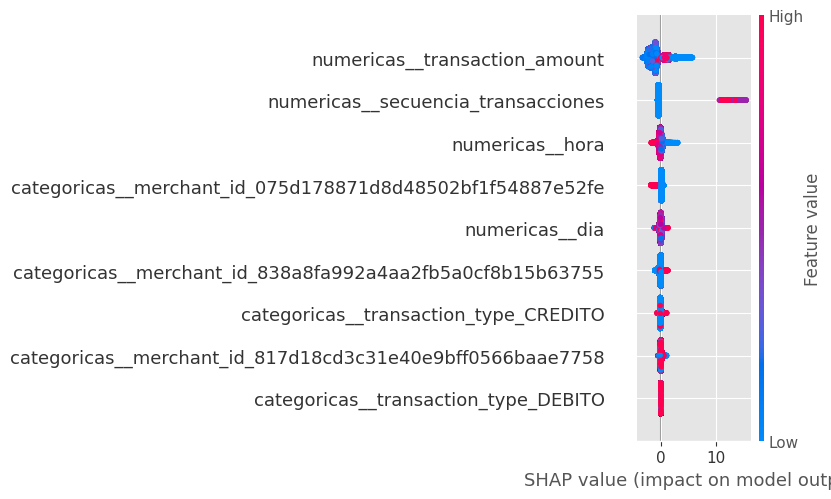

Generando el gráfico de fuerza para el índice 0...


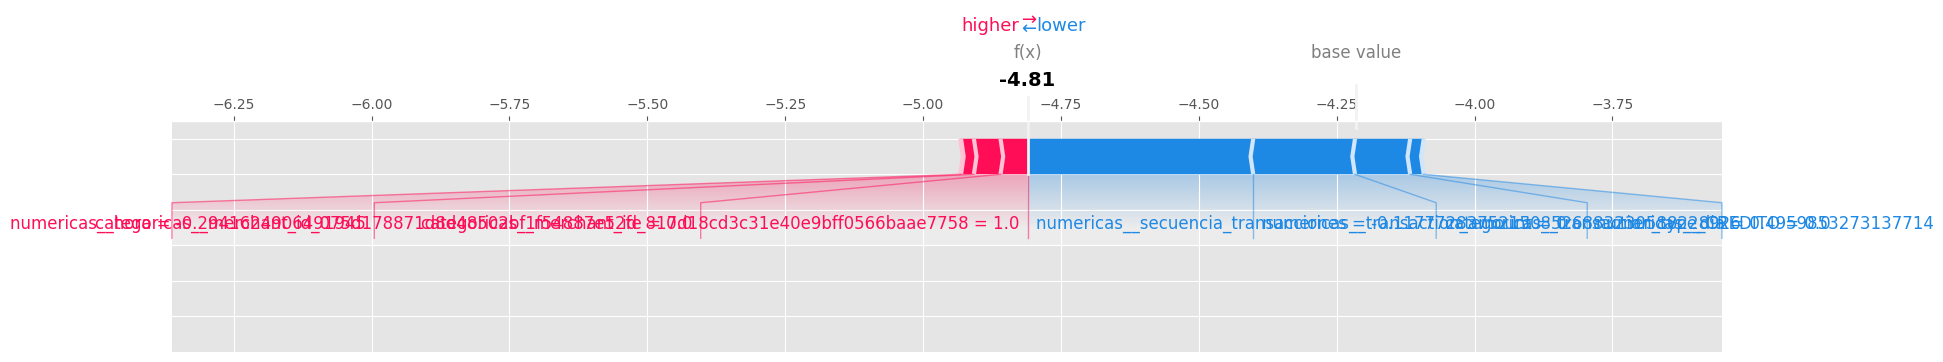

Generando el gráfico de dependencia para secuencia_transacciones...


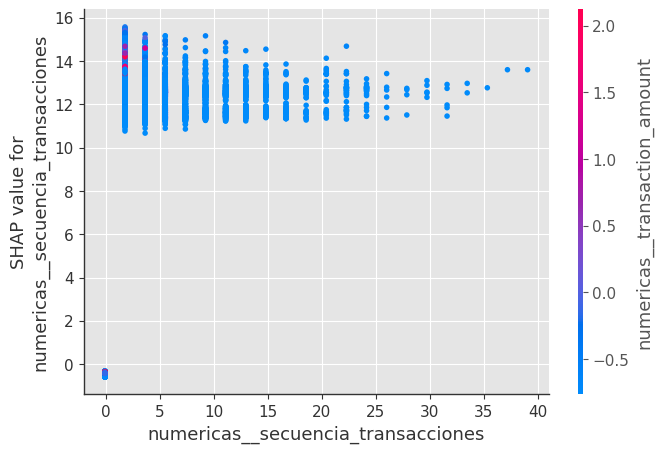

Análisis SHAP completado.


In [165]:
analyze_shap(pipeline_xgboost, X_test, idx=0, dependency_feature="secuencia_transacciones")

Generando el gráfico de resumen...


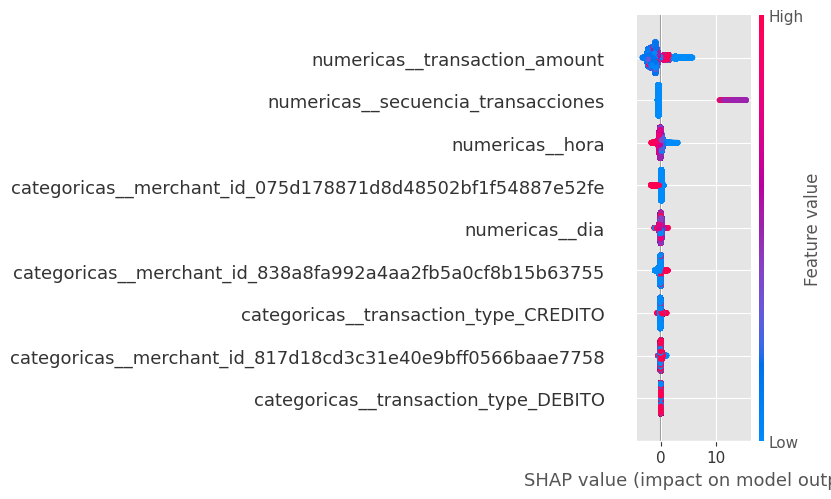

Generando el gráfico de fuerza para el índice 0...


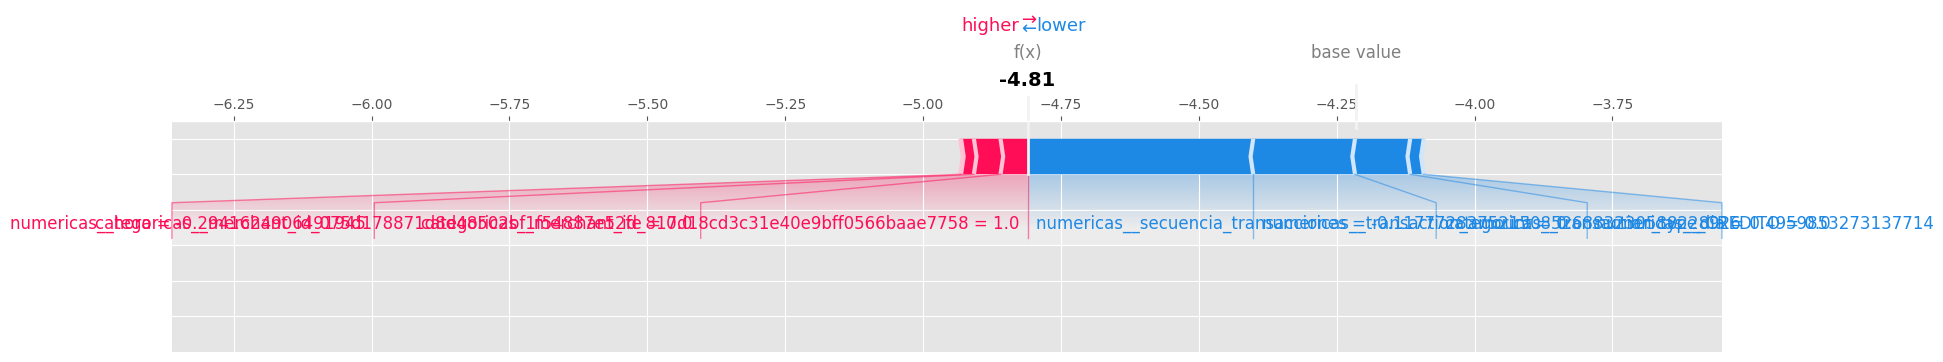

Generando el gráfico de dependencia para dia...


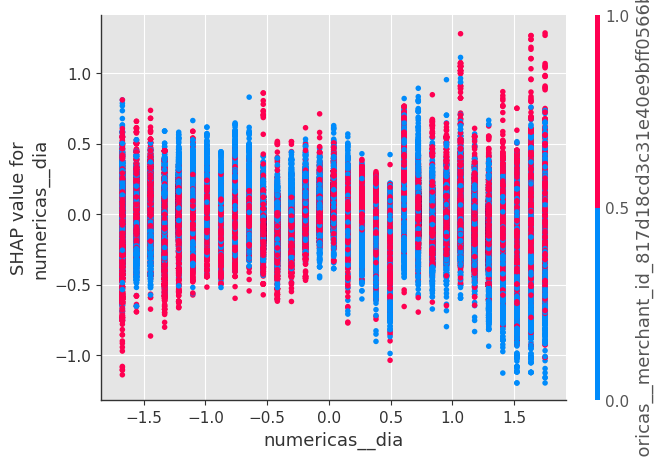

Análisis SHAP completado.


In [166]:
analyze_shap(pipeline_xgboost, X_test, idx=0, dependency_feature="dia")

Generando el gráfico de resumen...


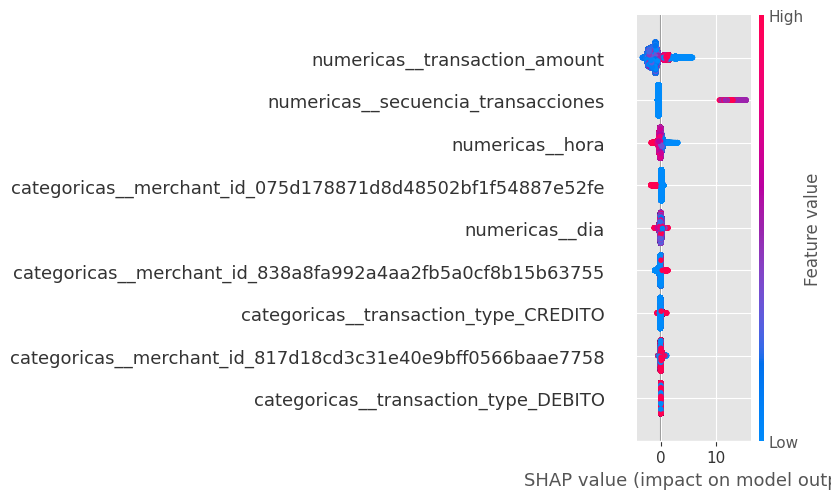

Generando el gráfico de fuerza para el índice 0...


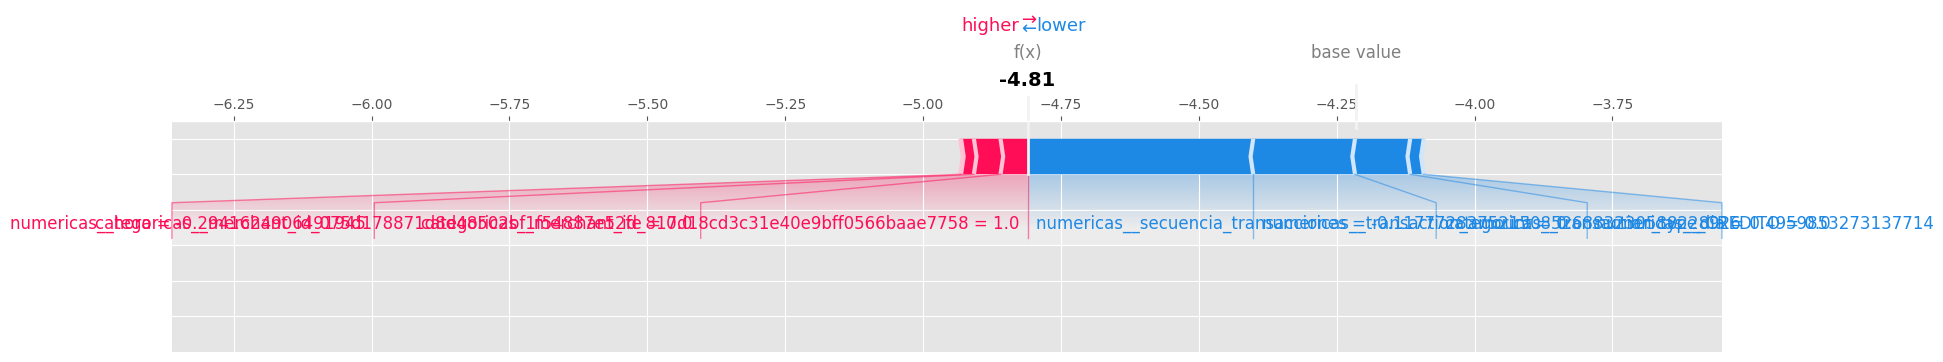

Generando el gráfico de dependencia para hora...


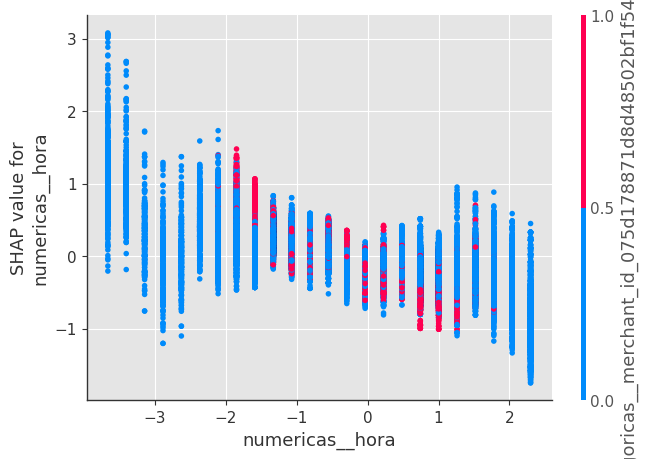

Análisis SHAP completado.


In [167]:
analyze_shap(pipeline_xgboost, X_test, idx=0, dependency_feature="hora")

# Paso 3.2 Proponga con qué frecuencia deben actualizarse los datos y por qué.

1. Recolección de Información: 

Captura de datos en tiempo real con una ventana de actualización diaria (día vencido). Esto permite identificar patrones recientes en los fraccionamientos transaccionales y mantener los modelos actualizados.

2. Procesamiento y Análisis:

Realizar agrupamientos y detección de fraccionamientos transaccionales diariamente para capturar irregularidades con rapidez.
Depuración y tratamiento de datos para valores atípicos al final de cada ciclo de predicción y entrenamiento (cada 24 horas).

3. Modelo y Ajustes:

Reentrenamiento del modelo semanalmente o cuando se observe un cambio significativo en los datos (p. ej., un cambio en los patrones de fraude).
Ajuste de hiperparámetros cada 15 días o mensualmente para garantizar la mejor performance del modelo.


# Paso 3.3 Diseñar una arquitectura ideal y los recursos necesarios para desplegar su propuesta (Opcional)

## 1: Amazon SageMaker:

**Entrenar el modelo:** En esta fase, se utiliza SageMaker para entrenar un modelo de Machine Learning con los datos disponibles.

**Desplegar el modelo:** Una vez entrenado, el modelo se convierte en un archivo binario que se despliega como un endpoint en SageMaker. Este endpoint es accesible para recibir solicitudes y generar predicciones.

## 2: AWS Lambda:

**Configurar la función Lambda:** Se crea una función Lambda que actúa como intermediaria entre el API Gateway y el endpoint de SageMaker.

**Invocar el endpoint:** La función Lambda recibe los datos de entrada desde el API Gateway, invoca el endpoint de SageMaker con estos datos y obtiene la predicción del modelo. Lambda procesa esta solicitud de forma asincrónica y gestiona la comunicación con SageMaker.

## 3: Amazon API Gateway:

**Crear la API REST:** Se configura una API en API Gateway para recibir solicitudes de los usuarios. Esta API tiene métodos definidos (como POST) que permiten enviar datos de entrada.

**Integrar con Lambda:** La API Gateway envía las solicitudes a la función Lambda. Los datos de entrada del usuario se transmiten a Lambda, que a su vez los envía al endpoint de SageMaker para obtener las predicciones.

**Devolver la respuesta:** Una vez que Lambda recibe la predicción de SageMaker, esta respuesta se envía de vuelta al API Gateway, que luego la entrega al usuario final.

En resumen, el flujo asegura que los usuarios puedan interactuar con el modelo de ML a través de una API RESTful, con AWS Lambda actuando como intermediario para gestionar la comunicación con el endpoint de SageMaker.